# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [39]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


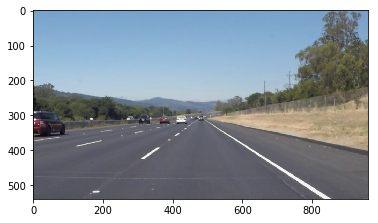

In [40]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [41]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [42]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 314 
 x2: 856 y2: 535

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 883 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 313 
 x2: 863 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 312 
 x2: 855 y2: 523

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 370

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 680

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.76642834303

 RightSlope Average: 
 0.589205557021

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 875 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 443 Ly1 : 340 
 Lx2: 182 Ly2: 540


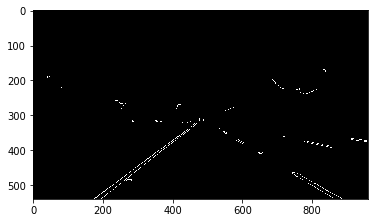

In [47]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

#Import the images for conversion

#Read test images from local folder
#1: Solid White Curve
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#2: Solid White Right
#image = mpimg.imread('test_images/solidWhiteRight.jpg')

#3: Solid Yellow Curve
#image = mpimg.imread('test_images/solidYellowCurve.jpg')

#4: solidYellowCurve2
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')

#5: solidYellowLeft
#image = mpimg.imread('test_images/solidYellowLeft.jpg')

#6: whiteCarLaneSwitch
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

height = np.size(image, 0)
width = np.size(image, 1)
print("Image Height :", height, "Image Width:", width)

Xcenter = width/2
Ycenter = height/2


#Grayscale conversion
# Read in the image and convert to grayscale
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
#plt.imshow(gray, cmap='gray')



# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)



# Define our parameters for Canny and run it
low_threshold = 125
high_threshold = 255
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
#plt.imshow(edges, cmap='Greys_r')



# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(100,imshape[0]),(500, 280), (900, 500), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 40    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 200    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

SlopeM = 0
LeftSlopeAvg = 0
RightSlopeAvg = 0
LIntercept = 0
RIntercept = 0
Intercept = 0
LeftXMedian = 0
RightXMedian = 0
LInterceptMedian = 0
RInterceptMedian = 0

#Top x,y coordinates for Left Lane
Lx1 = 0
Ly1 = 0

#Bottom x,Y coordinates for Left Lane
Lx2 = 0
Ly2 = height


#Top x,y coordinates for Right Lane
Rx1 = 0
Ry1 = 0

#Bottom x,y coordinates for Right Lane
Rx2 = 0
Ry2 = height 

#Define empty arrays to store identified x,y coordinates
Lx = []
Ly = []
Rx = []
Ry = []

#Define empty arrays to store the Left and Right Lane slope values
LeftSlope = []
RightSlope = []


#Identify the Lane line segments from the image to extract x,y coordinates 

for line in lines:
    for x1,y1,x2,y2 in line:
        
        #Find the slope of line
        SlopeM = (y1-y2)/(x1-x2)

        #Evaluate if slope is for Left lane or Right lane
        #For negative slope, identify as segments for Left lane
        if SlopeM < 0.2 and SlopeM > - 0.8 :
            LeftSlope.append([SlopeM])
            Lx.extend([x1,x2])
            Ly.extend([y1,y2])
            
           
            #For positive slope, identify as segments for Right lane    
        elif SlopeM >0.2 and SlopeM<0.8 :
            RightSlope.append([SlopeM])
            Rx.extend([x1,x2])
            Ry.extend([y1,y2])
                                     
            print ( "\n Initial Right Values pe: \n x1:", x1, "y1 :", y1, "\n x2:",x2, "y2:", y2 )
                
#print identified lane coordinates 
print ( "\n Final Right Values: \n Rx1:", Rx1, "Ry1 :", Ry1, "\n Rx2:",Rx2, "Ry2:", Ry2 )
print ( "\n Final Left Values: \n Lx1:", Lx1, "Ly1 :", Ly1, "\n Lx2:",Lx2, "Ly2:", Ly2 )

#Find mean values for Left lane x,y coordinates from array list
LeftXMedian = int(np.nanmean(Lx))
LeftYMedian = int(np.nanmean(Ly))

#Find mean values for Right lane x,y coordinates from array list
RightXMedian = int(np.nanmean(Rx))
RightYMedian = int(np.nanmean(Ry))

#Find average slope values from array list
LeftSlopeAvg = np.nanmean(LeftSlope)
RightSlopeAvg = np.nanmean(RightSlope)

#Calculate Left lane line intercept value
LIntercept = int(LeftYMedian-LeftSlopeAvg*LeftXMedian)

#Calculate Right Lane line intercept value
RIntercept = int(RightYMedian-RightSlopeAvg*RightXMedian)


#Print information 
print ( "\n LeftX Median Values: \n",LeftXMedian )
print ( "\n RightX Median Values: \n:", RightXMedian )
print ("\n LeftIntercept Median: \n", LIntercept)
print ("\n RightIntercept Median: \n", RIntercept)
print ("\n LeftSlope Average: \n", LeftSlopeAvg)
print ("\n RightSlope Average: \n", RightSlopeAvg)


# Calculate Bottom points for Left Lane
Ly2 = int(height)
Lx2 = int((Ly2-LIntercept)/LeftSlopeAvg)

# Calculate Top points for Left Lane
Ly1 = 340
Lx1 = int((Ly1-LIntercept)/LeftSlopeAvg)

# Calculate Bottom points for Right Lane
Ry2 = int(height)
#Rx2 = int((Ry2-RInterceptMedian)/RightSlopeAvg)-int(RxCalib*RightSlopeAvg) 
Rx2 = int((Ry2-RIntercept)/RightSlopeAvg)

#Calculate Top points for Right Lane
Ry1 = 340
#Rx1 = int((Ry1-RInterceptMedian)/RightSlopeAvg)-int(RxCalib*RightSlopeAvg)  
Rx1 = int((Ry1-RIntercept)/RightSlopeAvg)

#print identified lane coordinates 
print ( "\n Final Right Value with Slope: \n Rx1:", Rx1, "Ry1 :", Ry1, "\n Rx2:",Rx2, "Ry2:", Ry2 )
print ( "\n Final Left Values with Slope: \n Lx1:", Lx1, "Ly1 :", Ly1, "\n Lx2:",Lx2, "Ly2:", Ly2 )

#Plot Left lane masking
cv2.line(line_image,(Lx1,Ly1),(Lx2,Ly2),(255,0,0),15)

#Plot Right lane masking
cv2.line(line_image,(Rx1,Ry1),(Rx2,Ry2),(255,0,0),15)

#Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges))

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(line_image,0.8, image, 1, 0) 
#plt.imshow(lines_edges)
   

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    height = np.size(image, 0)
    width = np.size(image, 1)
    print("Image Height :", height, "Image Width:", width)

    Xcenter = width/2
    Ycenter = height/2


    #Grayscale conversion
    # Read in the image and convert to grayscale
    # Note: in the previous example we were reading a .jpg 
    # Here we read a .png and convert to 0,255 bytescale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    #plt.imshow(gray, cmap='gray')



    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)



    # Define our parameters for Canny and run it
    low_threshold = 125
    high_threshold = 255
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    #plt.imshow(edges, cmap='Greys_r')



    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(500, 280), (900, 500), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 40    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    SlopeM = 0
    LeftSlopeAvg = 0
    RightSlopeAvg = 0
    LIntercept = 0
    RIntercept = 0
    Intercept = 0
    LeftXMedian = 0
    RightXMedian = 0
    LInterceptMedian = 0
    RInterceptMedian = 0

    #Top x,y coordinates for Left Lane
    Lx1 = 0
    Ly1 = 0

    #Bottom x,Y coordinates for Left Lane
    Lx2 = 0
    Ly2 = height


    #Top x,y coordinates for Right Lane
    Rx1 = 0
    Ry1 = 0

    #Bottom x,y coordinates for Right Lane
    Rx2 = 0
    Ry2 = height 

    #Define empty arrays to store identified x,y coordinates
    Lx = []
    Ly = []
    Rx = []
    Ry = []

    #Define empty arrays to store the Left and Right Lane slope values
    LeftSlope = []
    RightSlope = []


    #Identify the Lane line segments from the image to extract x,y coordinates 

    for line in lines:
        for x1,y1,x2,y2 in line:

            #Find the slope of line
            SlopeM = (y1-y2)/(x1-x2)

            #Evaluate if slope is for Left lane or Right lane
            #For negative slope, identify as segments for Left lane
            if SlopeM < 0.2 and SlopeM > - 0.8 :
                LeftSlope.append([SlopeM])
                Lx.extend([x1,x2])
                Ly.extend([y1,y2])


                #For positive slope, identify as segments for Right lane    
            elif SlopeM >0.2 and SlopeM<0.8 :
                RightSlope.append([SlopeM])
                Rx.extend([x1,x2])
                Ry.extend([y1,y2])

                print ( "\n Initial Right Values pe: \n x1:", x1, "y1 :", y1, "\n x2:",x2, "y2:", y2 )

    #print identified lane coordinates 
    print ( "\n Final Right Values: \n Rx1:", Rx1, "Ry1 :", Ry1, "\n Rx2:",Rx2, "Ry2:", Ry2 )
    print ( "\n Final Left Values: \n Lx1:", Lx1, "Ly1 :", Ly1, "\n Lx2:",Lx2, "Ly2:", Ly2 )

    LeftXMedian = int(np.nanmean(Lx))
    LeftYMedian = int(np.nanmean(Ly))
    RightXMedian = int(np.nanmean(Rx))
    RightYMedian = int(np.nanmean(Ry))

    LeftSlopeAvg = np.nanmean(LeftSlope)
    RightSlopeAvg = np.nanmean(RightSlope)

    LIntercept = int(LeftYMedian-LeftSlopeAvg*LeftXMedian)
    RIntercept = int(RightYMedian-RightSlopeAvg*RightXMedian)

    print ( "\n LeftX Median Values: \n",LeftXMedian )
    print ( "\n RightX Median Values: \n:", RightXMedian )
    print ("\n LeftIntercept Median: \n", LIntercept)
    print ("\n RightIntercept Median: \n", RIntercept)
    print ("\n LeftSlope Average: \n", LeftSlopeAvg)
    print ("\n RightSlope Average: \n", RightSlopeAvg)


    # Calculate Bottom points for Left Lane
    Ly2 = int(height)
    Lx2 = int((Ly2-LIntercept)/LeftSlopeAvg)

    # Calculate Top points for Left Lane
    Ly1 = 340
    Lx1 = int((Ly1-LIntercept)/LeftSlopeAvg)

    #Calculate Right lane slope with final values
    #RightSlope = (Ry2-Ry1)/(Rx2-Rx1)

    # Calculate Bottom points for Right Lane
    Ry2 = int(height)
    #Rx2 = int((Ry2-RInterceptMedian)/RightSlopeAvg)-int(RxCalib*RightSlopeAvg) 
    Rx2 = int((Ry2-RIntercept)/RightSlopeAvg)

    #Calculate Top points for Right Lane
    Ry1 = 340
    #Rx1 = int((Ry1-RInterceptMedian)/RightSlopeAvg)-int(RxCalib*RightSlopeAvg)  
    Rx1 = int((Ry1-RIntercept)/RightSlopeAvg)

    #print identified lane coordinates 
    print ( "\n Final Right Value with Slope: \n Rx1:", Rx1, "Ry1 :", Ry1, "\n Rx2:",Rx2, "Ry2:", Ry2 )
    print ( "\n Final Left Values with Slope: \n Lx1:", Lx1, "Ly1 :", Ly1, "\n Lx2:",Lx2, "Ly2:", Ly2 )

    #Plot Left lane masking
    cv2.line(line_image,(Lx1,Ly1),(Lx2,Ly2),(255,0,0),15)

    #Plot Right lane masking
    cv2.line(line_image,(Rx1,Ry1),(Rx2,Ry2),(255,0,0),15)

    #Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(line_image,0.8, image, 1, 0) 
    plt.imshow(lines_edges)
    
    return lines_edges

Let's try the one with the solid white lane on the right first ...

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 313 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 703 y2: 446

 Initial Right Values pe: 
 x1: 698 y1 : 444 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 309 
 x2: 869 y2: 539

 Initial Right Values pe: 
 x1: 746 y1 : 475 
 x2: 847 y2: 538

 Initial Right Values pe: 
 x1: 495 y1 : 312 
 x2: 698 y2: 434

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 686

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.739189378743

 RightSlope Average: 
 0.61318525202

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 156 Ly2: 540
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRi


  0%|          | 0/222 [00:00<?, ?it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 313 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 703 y2: 446

 Initial Right Values pe: 
 x1: 698 y1 : 444 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 309 
 x2: 869 y2: 539

 Initial Right Values pe: 
 x1: 746 y1 : 475 
 x2: 847 y2: 538

 Initial Right Values pe: 
 x1: 495 y1 : 312 
 x2: 698 y2: 434

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 686

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.739189378743

 RightSlope Average: 
 0.61318525202

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 498 y1 : 315 
 x2: 868 y2: 538

 Initial Right Values p


  1%|          | 2/222 [00:00<00:17, 12.91it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 497 y1 : 314 
 x2: 819 y2: 508

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 761 y2: 483

 Initial Right Values pe: 
 x1: 485 y1 : 309 
 x2: 684 y2: 434

 Initial Right Values pe: 
 x1: 734 y1 : 467 
 x2: 845 y2: 537

 Initial Right Values pe: 
 x1: 514 y1 : 325 
 x2: 868 y2: 538

 Initial Right Values pe: 
 x1: 792 y1 : 493 
 x2: 868 y2: 539

 Initial Right Values pe: 
 x1: 475 y1 : 305 
 x2: 784 y2: 498

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 686

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.725406713618

 RightSlope Average: 
 0.616893006388

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 153 Ly2: 540



  2%|▏         | 4/222 [00:00<00:15, 13.88it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 304 
 x2: 867 y2: 537

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 799 y2: 507

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 703 y2: 446

 Initial Right Values pe: 
 x1: 707 y1 : 450 
 x2: 847 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 300

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.752197249777

 RightSlope Average: 
 0.620883736733

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 422 Ly1 : 340 
 Lx2: 156 Ly2: 540


Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 304 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 749 y2: 475

 Initial Right Values pe: 
 x1: 481 y1 : 305 
 x2: 870 y2: 539

 Initial Right Values pe: 
 x1: 474 y1 : 304 
 x2: 849 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 355

 RightX Median Values: 
: 657

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.71319218241

 RightSlope Average: 
 0.613229710577

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 150 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 304 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 304 
 x2: 768 y2: 487

 Initial Right Values pe: 
 x1: 479 y1 : 304 
 x2: 870 y2: 539

 Initial Right Values p


  3%|▎         | 6/222 [00:00<00:14, 14.45it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 497 y1 : 313 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 472 y1 : 303 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 476 y1 : 304 
 x2: 796 y2: 504

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 634 y2: 397

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 360

 RightX Median Values: 
: 635

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.716767729268

 RightSlope Average: 
 0.612146477231

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 864 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 147 Ly2: 540


Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 498 y1 : 314 
 x2: 872 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 850 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 312 
 x2: 872 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 310 
 x2: 661 y2: 413

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 349

 RightX Median Values: 
: 655

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.713328570295

 RightSlope Average: 
 0.609607658441

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 147 Ly2: 540



  4%|▎         | 8/222 [00:00<00:14, 14.99it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 509 y1 : 321 
 x2: 871 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 556 y1 : 350 
 x2: 864 y2: 535

 Initial Right Values pe: 
 x1: 485 y1 : 309 
 x2: 598 y2: 380

 Initial Right Values pe: 
 x1: 497 y1 : 313 
 x2: 871 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 658

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.712914446253

 RightSlope Average: 
 0.611352071836

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 306 
 x2: 865 y2: 537

 Initial Right Values pe: 
 x1: 471 y1 : 305 
 x2: 844 y2: 538

 Initial Right Values 


  5%|▍         | 10/222 [00:00<00:13, 15.43it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 859 y2: 537

 Initial Right Values pe: 
 x1: 468 

y1 : 307 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 478 y1 : 312 
 x2: 795 y2: 510

 Initial Right Values pe: 
 x1: 482 y1 : 311 
 x2: 860 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 617 y2: 397

 Initial Right Values pe: 
 x1: 515 y1 : 329 
 x2: 604 y2: 383

 Initial Right Values pe: 
 x1: 498 y1 : 318 
 x2: 572 y2: 363

 Initial Right Values pe: 
 x1: 519 y1 : 315 
 x2: 591 y2: 330

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 361

 RightX Median Values: 
: 604

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 42

 LeftSlope Average: 
 -0.707581981931

 RightSlope Average: 
 0.562505497779

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 885 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 834 y2: 539

 Initial Right Values pe: 
 x1:


  5%|▌         | 12/222 [00:00<00:13, 15.44it/s]

 485 y1 : 313 
 x2: 807 y2: 522

 Initial Right Values pe: 
 x1: 496 y1 : 317 
 x2: 740 y2: 469

 Initial Right Values pe: 
 x1: 749 y1 : 473 
 x2: 856 y2: 539

 Initial Right Values pe: 
 x1: 503 y1 : 322 
 x2: 700 y2: 445

 Initial Right Values pe: 
 x1: 709 y1 : 449 
 x2: 803 y2: 507

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 351

 RightX Median Values: 
: 680

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.721333460543

 RightSlope Average: 
 0.629773886163

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 833 y2: 539

 Initial Right Values pe: 
 x1: 515 y1 : 329 
 x2: 757 y2: 480

 Initial Right Values pe: 
 x1: 471 y1 : 305 
 x2: 764 y2: 495

 Initial Right Values pe: 



  6%|▋         | 14/222 [00:00<00:13, 15.55it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 304 
 x2: 857 y2: 539

 Initial Right Values pe: 
 x1: 469 y1 : 301 
 x2: 835 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 309 
 x2: 652 y2: 418

 Initial Right Values pe: 
 x1: 470 y1 : 301 
 x2: 835 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 304 
 x2: 821 y2: 517

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 357

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 590

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.540355713956

 RightSlope Average: 
 0.640017984172

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 462 Ly1 : 340 
 Lx2: 92 Ly2: 540



  7%|▋         | 16/222 [00:01<00:13, 15.82it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 331 
 x2: 859 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 694 y2: 444

 Initial Right Values pe: 
 x1: 498 y1 : 312 
 x2: 859 y2: 538

 Initial Right Values pe: 
 x1: 687 y1 : 441 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 305 
 x2: 637 y2: 406

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 837 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.717814452678

 RightSlope Average: 
 0.642488440334

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 301 
 x2: 859 y2: 538

 Initial Right Values 

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 310 
 x2: 836 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 308 
 x2: 857 y2: 538

 Initial Right Values pe: 
 x1: 549 y1 : 348 
 x2: 706 y2: 453

 Initial Right Values pe: 
 x1: 495 y1 : 310 
 x2: 726 y2: 455

 Initial Right Values pe: 
 x1: 484 y1 : 307 
 x2: 540 y2: 344

 Initial Right Values pe: 
 x1: 539 y1 : 342 
 x2: 620 y2: 396

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 633 y2: 397

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 381

 RightX Median Values: 
: 604

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 -8

 LeftSlope Average: 
 -0.697373888473

 RightSlope Average: 
 0.646650207127

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 139 Ly2: 540



  8%|▊         | 18/222 [00:01<00:12, 15.83it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1:


  9%|▉         | 20/222 [00:01<00:12, 16.14it/s]

 481 y1 : 304 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 302 
 x2: 699 y2: 448

 Initial Right Values pe: 
 x1: 471 y1 : 301 
 x2: 774 y2: 498

 Initial Right Values pe: 
 x1: 719 y1 : 463 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 497 y1 : 313 
 x2: 767 y2: 482

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 422

 RightX Median Values: 
: 657

 LeftIntercept Median: 
 528

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.401770147401

 RightSlope Average: 
 0.640810113951

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 467 Ly1 : 340 
 Lx2: -29 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 734 y2: 472

 Initial Right Values pe: 
 x1: 499 y1 : 316 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 310 
 x2: 829 y2: 535

 Initial Right Values pe: 



 Initial Right Values pe: 
 x1: 521 y1 : 331 
 x2: 853 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 311 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 632 y2: 406

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 385

 RightX Median Values: 
: 643

 LeftIntercept Median: 
 574

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.476356184111

 RightSlope Average: 
 0.640519482472

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 491 Ly1 : 340 
 Lx2: 71 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 498 y1 : 316 
 x2: 854 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 311 
 x2: 754 y2: 486

 Initial Right Values pe: 
 x1: 483 y1 : 311 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 330 
 x2: 836 y2: 528

 Initial Right Values pe: 
 x1: 528 y1 : 315 
 x2: 586 y2: 


 10%|▉         | 22/222 [00:01<00:12, 16.17it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 317 
 x2: 853 y2: 538

 Initial Right Values pe: 
 x1: 472 y1 : 303 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 473 y1 : 303 
 x2: 682 y2: 439

 Initial Right Values pe: 
 x1: 472 y1 : 304 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 303 
 x2: 853 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 368

 RightX Median Values: 
: 649

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.70088791305

 RightSlope Average: 
 0.63796441729

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 317 
 x2: 854 y2: 538

 Initial Right Values pe:


 11%|█         | 24/222 [00:01<00:12, 16.17it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 302 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 473 y1 : 302 
 x2: 729 y2: 469

 Initial Right Values pe: 
 x1: 474 y1 : 302 
 x2: 672 y2: 431

 Initial Right Values pe: 
 x1: 472 y1 : 303 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 739 y1 : 477 
 x2: 834 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 655

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.706102066865

 RightSlope Average: 
 0.645670608811

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 475 y1 : 301 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 473 y1 : 303 
 x2: 750 y2: 483

 Initial Right Values 


 12%|█▏        | 26/222 [00:01<00:12, 16.23it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 473 y1 : 302 
 x2: 781 y2: 503

 Initial Right Values pe: 
 x1: 476 y1 : 302 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 473 y1 : 303 
 x2: 826 y2: 533

 Initial Right Values pe: 
 x1: 476 y1 : 303 
 x2: 622 y2: 398

 Initial Right Values pe: 
 x1: 474 y1 : 302 
 x2: 684 y2: 439

 Initial Right Values pe: 
 x1: 476 y1 : 301 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 753 y1 : 486 
 x2: 833 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 646

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.706713550034

 RightSlope Average: 
 0.643841399969

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 841 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 13%|█▎        | 28/222 [00:01<00:11, 16.40it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 475 y1 : 301 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 473 y1 : 304 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 473 y1 : 303 
 x2: 796 y2: 513

 Initial Right Values pe: 
 x1: 474 y1 : 301 
 x2: 525 y2: 335

 Initial Right Values pe: 
 x1: 497 y1 : 313 
 x2: 632 y2: 400

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 355

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 -5

 LeftSlope Average: 
 -0.725175060332

 RightSlope Average: 
 0.646629913276

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 473 y1 : 303 
 x2: 835 y2: 538

 Initial Right Values pe: 
 x1: 476 y1 : 301 
 x2: 856 y2: 538

 Initial Right Values 


 14%|█▎        | 30/222 [00:01<00:11, 16.41it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 475 y1 : 300 
 x2: 857 y2: 539

 Initial Right Values pe: 
 x1: 473 y1 : 302 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 476 y1 : 300 
 x2: 857 y2: 538

 Initial Right Values pe: 
 x1: 474 y1 : 301 
 x2: 625 y2: 395

 Initial Right Values pe: 
 x1: 733 y1 : 472 
 x2: 835 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 370

 RightX Median Values: 
: 664

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.715929521755

 RightSlope Average: 
 0.635968681742

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 474 y1 : 302 
 x2: 828 y2: 532

 Initial Right Values pe: 
 x1: 475 y1 : 300 
 x2: 832 y2: 523

 Initial Right Values p


 14%|█▍        | 32/222 [00:01<00:11, 16.65it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 474 y1 : 302 
 x2: 835 y2: 537

 Initial Right Values pe: 
 x1: 478 y1 : 301 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 300 
 x2: 845 y2: 531

 Initial Right Values pe: 
 x1: 475 y1 : 301 
 x2: 672 y2: 424

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 308 
 x2: 541 y2: 344

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 332

 RightX Median Values: 
: 621

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.712584457551

 RightSlope Average: 
 0.634106667944

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 475 y1 : 301 
 x2: 820 y2: 516

 Initial Right Values p


 15%|█▌        | 34/222 [00:02<00:11, 16.79it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 855 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 833 y2: 537

 Initial Right Values pe: 
 x1: 503 y1 : 318 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 546 y2: 349

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 380

 RightX Median Values: 
: 636

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.692311808562

 RightSlope Average: 
 0.639421332766

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 311 
 x2: 778 y2: 492

 Initial Right Values pe: 
 x1: 477 y1 : 307 
 x2: 833 y2: 538

 Initial Right Values 


 16%|█▌        | 36/222 [00:02<00:11, 16.86it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 307 
 x2: 833 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 848 y2: 535

 Initial Right Values pe: 
 x1: 478 y1 : 307 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 310 
 x2: 748 y2: 474

 Initial Right Values pe: 
 x1: 497 y1 : 314 
 x2: 552 y2: 349

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 551 y2: 353

 Initial Right Values pe: 
 x1: 505 y1 : 320 
 x2: 855 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median Values: 
: 616

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.713772547566

 RightSlope Average: 
 0.638230699483

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values p


 17%|█▋        | 38/222 [00:02<00:10, 16.83it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 854 y2: 539

 Initial Right Values pe: 
 x1: 476 y1 : 306 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 751 y2: 484

 Initial Right Values pe: 
 x1: 535 y1 : 338 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 556 y2: 355

 Initial Right Values pe: 
 x1: 500 y1 : 315 
 x2: 560 y2: 353

 Initial Right Values pe: 
 x1: 479 y1 : 309 
 x2: 832 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 291

 RightX Median Values: 
: 620

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.71309750134

 RightSlope Average: 
 0.640770988222

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values p


 18%|█▊        | 40/222 [00:02<00:10, 16.75it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 308 
 x2: 855 y2: 539

 Initial Right Values pe: 
 x1: 475 y1 : 305 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 476 y1 : 305 
 x2: 776 y2: 500

 Initial Right Values pe: 
 x1: 497 y1 : 311 
 x2: 587 y2: 376

 Initial Right Values pe: 
 x1: 540 y1 : 340 
 x2: 627 y2: 395

 Initial Right Values pe: 
 x1: 484 y1 : 308 
 x2: 622 y2: 398

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 353

 RightX Median Values: 
: 614

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 -9

 LeftSlope Average: 
 -0.725626247365

 RightSlope Average: 
 0.65055823413

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values p


 19%|█▉        | 42/222 [00:02<00:10, 16.56it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 303 
 x2: 764 y2: 494

 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 757 y1 : 488 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 524 y1 : 328 
 x2: 605 y2: 382

 Initial Right Values pe: 
 x1: 497 y1 : 311 
 x2: 557 y2: 351

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 853 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 362

 RightX Median Values: 
: 640

 LeftIntercept Median: 
 654

 RightIntercept Median: 
 -12

 LeftSlope Average: 
 -0.73907073509

 RightSlope Average: 
 0.653698790919

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 154 Ly2: 540



 20%|█▉        | 44/222 [00:02<00:16, 10.85it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 302 
 x2: 825 y2: 534

 Initial Right Values pe: 
 x1: 497 y1 : 311 
 x2: 720 y2: 455

 Initial Right Values pe: 
 x1: 479 y1 : 303 
 x2: 704 y2: 454

 Initial Right Values pe: 
 x1: 716 y1 : 451 
 x2: 814 y2: 514

 Initial Right Values pe: 
 x1: 648 y1 : 408 
 x2: 785 y2: 496

 Initial Right Values pe: 
 x1: 789 y1 : 497 
 x2: 855 y2: 539

 Initial Right Values pe: 
 x1: 502 y1 : 315 
 x2: 644 y2: 407

 Initial Right Values pe: 
 x1: 481 y1 : 303 
 x2: 785 y2: 508

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 337

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 -14

 LeftSlope Average: 
 -0.73374447528

 RightSlope Average: 
 0.654137595549

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 422 Ly1 : 340 
 Lx2: 149 Ly2:


 21%|██        | 46/222 [00:03<00:17,  9.99it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 534 y1 : 339 
 x2: 808 y2: 523

 Initial Right Values pe: 
 x1: 504 y1 : 317 
 x2: 832 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 329 
 x2: 740 y2: 478

 Initial Right Values pe: 
 x1: 506 y1 : 318 
 x2: 612 y2: 385

 Initial Right Values pe: 
 x1: 498 y1 : 312 
 x2: 549 y2: 344

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 370

 RightX Median Values: 
: 627

 LeftIntercept Median: 
 654

 RightIntercept Median: 
 -7

 LeftSlope Average: 
 -0.740738835151

 RightSlope Average: 
 0.646670550555

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 22%|██▏       | 48/222 [00:03<00:17,  9.80it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 335 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 484 y1 : 308 
 x2: 853 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 308 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 501 y1 : 315 
 x2: 609 y2: 383

 Initial Right Values pe: 
 x1: 535 y1 : 340 
 x2: 753 y2: 487

 Initial Right Values pe: 
 x1: 736 y1 : 474 
 x2: 831 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 351

 RightX Median Values: 
: 666

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 -7

 LeftSlope Average: 
 -0.726086584512

 RightSlope Average: 
 0.649866554426

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 841 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 303 
 x2: 772 y2: 500

 Initial Right Values 


 23%|██▎       | 50/222 [00:03<00:17,  9.73it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 304 
 x2: 830 y2: 539

 Initial Right Values pe: 
 x1: 499 y1 : 313 
 x2: 722 y2: 457

 Initial Right Values pe: 
 x1: 693 y1 : 437 
 x2: 822 y2: 520

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 853 y2: 539

 Initial Right Values pe: 
 x1: 497 y1 : 312 
 x2: 544 y2: 343

 Initial Right Values pe: 
 x1: 496 y1 : 312 
 x2: 831 y2: 538

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 853 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 295

 RightX Median Values: 
: 648

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 -9

 LeftSlope Average: 
 -0.716775856321

 RightSlope Average: 
 0.64943449422

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values p


 23%|██▎       | 52/222 [00:03<00:18,  9.43it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 506 y1 : 319 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 852 y2: 537

 Initial Right Values pe: 
 x1: 524 y1 : 333 
 x2: 810 y2: 525

 Initial Right Values pe: 
 x1: 505 y1 : 318 
 x2: 675 y2: 425

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 852 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 296

 RightX Median Values: 
: 652

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 -5

 LeftSlope Average: 
 -0.707149171986

 RightSlope Average: 
 0.645329074306

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 538 y1 : 342 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 479 y1 : 304 
 x2: 852 y2: 537

 Initial Right Values 


 24%|██▍       | 54/222 [00:04<00:17,  9.33it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 537 y1 : 342 
 x2: 820 y2: 532

 Initial Right Values pe: 
 x1: 480 y1 : 304 
 x2: 728 y2: 459

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 853 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 313 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 726 y1 : 459 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 495 y1 : 315 
 x2: 603 y2: 387

 Initial Right Values pe: 
 x1: 497 y1 : 313 
 x2: 672 y2: 423

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 373

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 -6

 LeftSlope Average: 
 -0.699748392508

 RightSlope Average: 
 0.645318168538

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 25%|██▌       | 56/222 [00:04<00:17,  9.37it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 505 y1 : 320 
 x2: 813 y2: 513

 Initial Right Values pe: 
 x1: 515 y1 : 327 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 661 y2: 425

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 756 y2: 488

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 796 y2: 515

 Initial Right Values pe: 
 x1: 742 y1 : 480 
 x2: 829 y2: 537

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 736 y2: 464

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 366

 RightX Median Values: 
: 653

 LeftIntercept Median: 
 625

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.666466367435

 RightSlope Average: 
 0.640658755966

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 127 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 26%|██▌       | 58/222 [00:04<00:17,  9.13it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 850 y2: 538

 Initial Right Values pe: 
 x1: 545 y1 : 350 
 x2: 755 y2: 491

 Initial Right Values pe: 
 x1: 507 y1 : 323 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 315 
 x2: 828 y2: 539

 Initial Right Values pe: 
 x1: 738 y1 : 478 
 x2: 828 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 541 y2: 349

 Initial Right Values pe: 
 x1: 494 y1 : 317 
 x2: 578 y2: 373

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 385

 RightX Median Values: 
: 640

 LeftIntercept Median: 
 631

 RightIntercept Median: 
 -9

 LeftSlope Average: 
 -0.681092885576

 RightSlope Average: 
 0.657178251637

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 835 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 133 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 27%|██▋       | 59/222 [00:04<00:18,  8.76it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 553 y1 : 355 
 x2: 826 y2: 539

 Initial Right Values pe: 
 x1: 474 y1 : 304 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 306 
 x2: 640 y2: 406

 Initial Right Values pe: 
 x1: 479 y1 : 306 
 x2: 787 y2: 513

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 848 y2: 539

 Initial Right Values pe: 
 x1: 475 y1 : 304 
 x2: 699 y2: 444

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 355

 RightX Median Values: 
: 632

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.686468977744

 RightSlope Average: 
 0.640952874484

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 135 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 321 
 x2: 824 y2: 539

 Initial Right Values p


 27%|██▋       | 61/222 [00:04<00:18,  8.88it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 823 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 305 
 x2: 844 y2: 539

 Initial Right Values pe: 
 x1: 496 y1 : 315 
 x2: 626 y2: 399

 Initial Right Values pe: 
 x1: 558 y1 : 359 
 x2: 824 y2: 538

 Initial Right Values pe: 
 x1: 612 y1 : 389 
 x2: 805 y2: 514

 Initial Right Values pe: 
 x1: 498 y1 : 317 
 x2: 592 y2: 378

 Initial Right Values pe: 
 x1: 477 y1 : 306 
 x2: 823 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 -10

 LeftSlope Average: 
 -0.690348259384

 RightSlope Average: 
 0.658794987674

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 834 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values


 29%|██▉       | 65/222 [00:05<00:17,  9.14it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 306 
 x2: 822 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 818 y2: 523

 Initial Right Values pe: 
 x1: 497 y1 : 316 
 x2: 645 y2: 412

 Initial Right Values pe: 
 x1: 487 y1 : 307 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 821 y2: 537

 Initial Right Values pe: 
 x1: 483 y1 : 311 
 x2: 822 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 297

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 -11

 LeftSlope Average: 
 -0.687720104934

 RightSlope Average: 
 0.660800531748

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 833 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 136 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 307 
 x2: 821 y2: 539

 Initial Right Values

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 306 
 x2: 821 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 842 y2: 539

 Initial Right Values pe: 
 x1: 511 y1 : 326 
 x2: 650 y2: 416

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 816 y2: 534

 Initial Right Values pe: 
 x1: 496 y1 : 315 
 x2: 695 y2: 444

 Initial Right Values pe: 
 x1: 694 y1 : 442 
 x2: 843 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 386

 RightX Median Values: 
: 650

 LeftIntercept Median: 
 623

 RightIntercept Median: 
 -9

 LeftSlope Average: 
 -0.661188164586

 RightSlope Average: 
 0.656312748732

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 836 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 125 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 823 y2: 538

 Initial Right Values 


 31%|███       | 69/222 [00:05<00:16,  9.23it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 306 
 x2: 824 y2: 539

 Initial Right Values pe: 
 x1: 499 y1 : 316 
 x2: 715 y2: 456

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 825 y2: 538

 Initial Right Values pe: 
 x1: 499 y1 : 315 
 x2: 782 y2: 498

 Initial Right Values pe: 
 x1: 730 y1 : 464 
 x2: 846 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 363

 RightX Median Values: 
: 667

 LeftIntercept Median: 
 631

 RightIntercept Median: 
 -12

 LeftSlope Average: 
 -0.686448598131

 RightSlope Average: 
 0.658211377136

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 838 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 132 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 305 
 x2: 824 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 307 
 x2: 771 y2: 492

 Initial Right Values


 32%|███▏      | 71/222 [00:05<00:16,  9.29it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 822 y2: 539

 Initial Right Values pe: 
 x1: 477 y1 : 305 
 x2: 823 y2: 538

 Initial Right Values pe: 
 x1: 497 y1 : 315 
 x2: 779 y2: 498

 Initial Right Values pe: 
 x1: 485 y1 : 306 
 x2: 833 y2: 532

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 609 y2: 389

 Initial Right Values pe: 
 x1: 747 y1 : 476 
 x2: 844 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 395

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 616

 RightIntercept Median: 
 -10

 LeftSlope Average: 
 -0.641122278057

 RightSlope Average: 
 0.656654144052

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 837 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 118 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 821 y2: 537

 Initial Right Values


 33%|███▎      | 73/222 [00:06<00:15,  9.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 795 y2: 508

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 821 y2: 537

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 821 y2: 538

 Initial Right Values pe: 
 x1: 498 y1 : 314 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 516 y1 : 328 
 x2: 641 y2: 409

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 361

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 622

 RightIntercept Median: 
 -10

 LeftSlope Average: 
 -0.660363482845

 RightSlope Average: 
 0.658838083708

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 834 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 124 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 821 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 842 y2: 539

 Initial Right Values


 33%|███▎      | 74/222 [00:06<00:16,  8.86it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 310 
 x2: 809 y2: 530

 Initial Right Values pe: 
 x1: 495 y1 : 314 
 x2: 842 y2: 539

 Initial Right Values pe: 
 x1: 514 y1 : 327 
 x2: 691 y2: 442

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 820 y2: 539

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 841 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 625

 RightIntercept Median: 
 -10

 LeftSlope Average: 
 -0.669676527849

 RightSlope Average: 
 0.659745015207

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 833 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 126 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 819 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 307 
 x2: 819 y2: 537

 Initial Right Values


 34%|███▍      | 76/222 [00:06<00:16,  8.95it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 474 y1 : 306 
 x2: 819 y2: 538

 Initial Right Values pe: 
 x1: 512 y1 : 325 
 x2: 841 y2: 539

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 766 y2: 501

 Initial Right Values pe: 
 x1: 495 y1 : 316 
 x2: 735 y2: 471

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 841 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 588 y2: 380

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 286

 RightX Median Values: 
: 627

 LeftIntercept Median: 
 623

 RightIntercept Median: 
 -11

 LeftSlope Average: 
 -0.661760263756

 RightSlope Average: 
 0.661507340306

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 832 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 125 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 304 
 x2: 840 y2: 539

 Initial Right Values


 35%|███▌      | 78/222 [00:06<00:15,  9.04it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 839 y2: 539

 Initial Right Values pe: 
 x1: 472 y1 : 306 
 x2: 817 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 677 y2: 442

 Initial Right Values pe: 
 x1: 515 y1 : 327 
 x2: 839 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 778 y2: 500

 Initial Right Values pe: 
 x1: 503 y1 : 322 
 x2: 671 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 383

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 619

 RightIntercept Median: 
 -12

 LeftSlope Average: 
 -0.660305160951

 RightSlope Average: 
 0.665298297265

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 829 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 422 Ly1 : 340 
 Lx2: 119 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 304 
 x2: 837 y2: 538

 Initial Right Values


 36%|███▌      | 80/222 [00:06<00:16,  8.75it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 835 y2: 538

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 813 y2: 539

 Initial Right Values pe: 
 x1: 476 y1 : 304 
 x2: 751 y2: 496

 Initial Right Values pe: 
 x1: 477 y1 : 304 
 x2: 649 y2: 416

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 351

 RightX Median Values: 
: 619

 LeftIntercept Median: 
 620

 RightIntercept Median: 
 -17

 LeftSlope Average: 
 -0.660720651141

 RightSlope Average: 
 0.675174272543

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 824 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 121 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 495 y1 : 316 
 x2: 813 y2: 539

 Initial Right Values pe: 
 x1: 476 y1 : 304 
 x2: 787 y2: 521

 Initial Right Values pe: 
 x1: 474 y1 : 303 
 x2: 832 y2: 536

 Initial Right Values


 37%|███▋      | 83/222 [00:07<00:15,  8.99it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 305 
 x2: 812 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 304 
 x2: 769 y2: 497

 Initial Right Values pe: 
 x1: 497 y1 : 315 
 x2: 657 y2: 423

 Initial Right Values pe: 
 x1: 697 y1 : 448 
 x2: 833 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 392

 RightX Median Values: 
: 653

 LeftIntercept Median: 
 620

 RightIntercept Median: 
 -22

 LeftSlope Average: 
 -0.661900225447

 RightSlope Average: 
 0.679297579262

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 827 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 120 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 474 y1 : 303 
 x2: 811 y2: 539

 Initial Right Values pe: 
 x1: 499 y1 : 320 
 x2: 832 y2: 537

 Initial Right Values pe: 
 x1: 476 y1 : 304 
 x2: 712 y2: 458

 Initial Right Values


 38%|███▊      | 84/222 [00:07<00:15,  8.77it/s]


 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 811 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 732 y2: 471

 Initial Right Values pe: 
 x1: 504 y1 : 323 
 x2: 771 y2: 497

 Initial Right Values pe: 
 x1: 474 y1 : 306 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 335 
 x2: 811 y2: 538

 Initial Right Values pe: 
 x1: 495 y1 : 316 
 x2: 635 y2: 407

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 364

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 615

 RightIntercept Median: 
 -12

 LeftSlope Average: 
 -0.646958485003

 RightSlope Average: 
 0.66677334904

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 827 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 115 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 810 y2: 538

 Initial Right Values pe: 
 x1: 497 y1 : 314 
 x2: 758 y2:


 39%|███▊      | 86/222 [00:07<00:15,  8.91it/s]


 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 811 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 779 y2: 504

 Initial Right Values pe: 
 x1: 506 y1 : 323 
 x2: 629 y2: 405

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 810 y2: 539

 Initial Right Values pe: 
 x1: 733 y1 : 472 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 305 
 x2: 832 y2: 539

 Initial Right Values pe: 
 x1: 526 y1 : 335 
 x2: 662 y2: 427

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 622

 RightIntercept Median: 
 -21

 LeftSlope Average: 
 -0.663666150121

 RightSlope Average: 
 0.679100618595

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 826 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 123 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 310 
 x2: 810 y2


 40%|███▉      | 88/222 [00:07<00:14,  9.06it/s]


 Initial Right Values pe: 
 x1: 477 y1 : 305 
 x2: 810 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 774 y2: 501

 Initial Right Values pe: 
 x1: 529 y1 : 337 
 x2: 710 y2: 459

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 810 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 306 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 480 y1 : 305 
 x2: 646 y2: 417

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 554 y2: 358

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 310

 RightX Median Values: 
: 611

 LeftIntercept Median: 
 627

 RightIntercept Median: 
 -24

 LeftSlope Average: 
 -0.674537714932

 RightSlope Average: 
 0.685881512264

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 822 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 128 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 310 
 x2: 809 y2


 41%|████      | 90/222 [00:07<00:14,  9.14it/s]


 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 809 y2: 539

 Initial Right Values pe: 
 x1: 484 y1 : 304 
 x2: 532 y2: 337

 Initial Right Values pe: 
 x1: 500 y1 : 320 
 x2: 649 y2: 425

 Initial Right Values pe: 
 x1: 487 y1 : 308 
 x2: 830 y2: 539

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 726 y2: 470

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 809 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 307 
 x2: 830 y2: 538

 Initial Right Values pe: 
 x1: 497 y1 : 317 
 x2: 661 y2: 427

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 386

 RightX Median Values: 
: 609

 LeftIntercept Median: 
 622

 RightIntercept Median: 
 -24

 LeftSlope Average: 
 -0.661160714286

 RightSlope Average: 
 0.685743457645

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 822 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 124 Ly2: 540
Image Height : 540 Image Width


 41%|████▏     | 92/222 [00:08<00:14,  9.25it/s]


 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 773 y2: 502

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 809 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 308 
 x2: 829 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 808 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 317 
 x2: 592 y2: 385

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 352

 RightX Median Values: 
: 624

 LeftIntercept Median: 
 621

 RightIntercept Median: 
 -26

 LeftSlope Average: 
 -0.657806174908

 RightSlope Average: 
 0.690768224329

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 819 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 123 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 828 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 807 y2: 537

 Initial Right Values pe: 
 x1: 519 y1 : 331 
 x2: 828 y2


 42%|████▏     | 94/222 [00:08<00:13,  9.33it/s]


 Initial Right Values pe: 
 x1: 500 y1 : 318 
 x2: 684 y2: 451

 Initial Right Values pe: 
 x1: 552 y1 : 352 
 x2: 828 y2: 538

 Initial Right Values pe: 
 x1: 489 y1 : 307 
 x2: 808 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 308 
 x2: 802 y2: 535

 Initial Right Values pe: 
 x1: 498 y1 : 317 
 x2: 658 y2: 433

 Initial Right Values pe: 
 x1: 501 y1 : 315 
 x2: 668 y2: 432

 Initial Right Values pe: 
 x1: 490 y1 : 307 
 x2: 682 y2: 441

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 383

 RightX Median Values: 
: 617

 LeftIntercept Median: 
 622

 RightIntercept Median: 
 -39

 LeftSlope Average: 
 -0.659810315292

 RightSlope Average: 
 0.710395277626

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 815 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 124 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 797 y2


 43%|████▎     | 96/222 [00:08<00:13,  9.24it/s]


 Initial Right Values pe: 
 x1: 488 y1 : 308 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 812 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 811 y2: 538

 Initial Right Values pe: 
 x1: 489 y1 : 307 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 739 y2: 478

 Initial Right Values pe: 
 x1: 490 y1 : 307 
 x2: 592 y2: 376

 Initial Right Values pe: 
 x1: 545 y1 : 349 
 x2: 628 y2: 408

 Initial Right Values pe: 
 x1: 498 y1 : 315 
 x2: 762 y2: 493

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 357

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 623

 RightIntercept Median: 
 -25

 LeftSlope Average: 
 -0.661439382292

 RightSlope Average: 
 0.684928559175

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 824 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 125 Ly2: 540
Image Height : 540 Image Width


 44%|████▍     | 98/222 [00:08<00:13,  9.26it/s]


 Initial Right Values pe: 
 x1: 521 y1 : 329 
 x2: 786 y2: 521

 Initial Right Values pe: 
 x1: 503 y1 : 317 
 x2: 831 y2: 538

 Initial Right Values pe: 
 x1: 499 y1 : 312 
 x2: 636 y2: 405

 Initial Right Values pe: 
 x1: 499 y1 : 315 
 x2: 581 y2: 374

 Initial Right Values pe: 
 x1: 504 y1 : 318 
 x2: 721 y2: 475

 Initial Right Values pe: 
 x1: 502 y1 : 313 
 x2: 552 y2: 347

 Initial Right Values pe: 
 x1: 715 y1 : 469 
 x2: 811 y2: 538

 Initial Right Values pe: 
 x1: 489 y1 : 309 
 x2: 831 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 310

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 625

 RightIntercept Median: 
 -34

 LeftSlope Average: 
 -0.664934556783

 RightSlope Average: 
 0.698927503204

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 821 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 127 Ly2: 540
Image Height : 540 Image Width


 45%|████▌     | 100/222 [00:09<00:13,  9.26it/s]


 Initial Right Values pe: 
 x1: 490 y1 : 306 
 x2: 783 y2: 518

 Initial Right Values pe: 
 x1: 484 y1 : 302 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 305 
 x2: 813 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 307 
 x2: 833 y2: 539

 Initial Right Values pe: 
 x1: 490 y1 : 305 
 x2: 685 y2: 437

 Initial Right Values pe: 
 x1: 500 y1 : 311 
 x2: 591 y2: 373

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 620

 RightIntercept Median: 
 -33

 LeftSlope Average: 
 -0.656074571699

 RightSlope Average: 
 0.693189281754

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 826 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 121 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 307 
 x2: 831 y2: 537

 Initial Right Values pe: 
 x1: 491 y1 : 306 
 x2: 812 y2


 46%|████▋     | 103/222 [00:09<00:13,  9.03it/s]


 Initial Right Values pe: 
 x1: 484 y1 : 304 
 x2: 831 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 313 
 x2: 589 y2: 373

 Initial Right Values pe: 
 x1: 500 y1 : 314 
 x2: 697 y2: 457

 Initial Right Values pe: 
 x1: 507 y1 : 318 
 x2: 811 y2: 539

 Initial Right Values pe: 
 x1: 499 y1 : 313 
 x2: 831 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 399

 RightX Median Values: 
: 624

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 -33

 LeftSlope Average: 
 -0.685993913973

 RightSlope Average: 
 0.69521393853

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 824 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 134 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 314 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 310 
 x2: 810 y2: 536

 Initial Right Values pe: 
 x1: 490 y1 : 311 
 x2: 737 y2:


 47%|████▋     | 104/222 [00:09<00:13,  8.87it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 813 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 308 
 x2: 833 y2: 539

 Initial Right Values pe: 
 x1: 492 y1 : 308 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 812 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 310 
 x2: 676 y2: 441

 Initial Right Values pe: 
 x1: 491 y1 : 309 
 x2: 749 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 387

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 627

 RightIntercept Median: 
 -28

 LeftSlope Average: 
 -0.665480258509

 RightSlope Average: 
 0.688466804237

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 825 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 130 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 315 
 x2: 835 y2: 539

 Initial Right Values


 48%|████▊     | 106/222 [00:09<00:12,  9.04it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 310 
 x2: 815 y2: 538

 Initial Right Values pe: 
 x1: 512 y1 : 320 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 499 y1 : 313 
 x2: 774 y2: 498

 Initial Right Values pe: 
 x1: 501 y1 : 317 
 x2: 812 y2: 535

 Initial Right Values pe: 
 x1: 508 y1 : 321 
 x2: 622 y2: 401

 Initial Right Values pe: 
 x1: 502 y1 : 314 
 x2: 815 y2: 525

 Initial Right Values pe: 
 x1: 507 y1 : 317 
 x2: 836 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 388

 RightX Median Values: 
: 644

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 -28

 LeftSlope Average: 
 -0.688080117245

 RightSlope Average: 
 0.685223677198

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 828 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 136 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values


 49%|████▊     | 108/222 [00:09<00:12,  9.02it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 316 
 x2: 818 y2: 539

 Initial Right Values pe: 
 x1: 506 y1 : 316 
 x2: 820 y2: 527

 Initial Right Values pe: 
 x1: 499 y1 : 313 
 x2: 629 y2: 405

 Initial Right Values pe: 
 x1: 531 y1 : 332 
 x2: 838 y2: 539

 Initial Right Values pe: 
 x1: 502 y1 : 317 
 x2: 818 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 313 
 x2: 737 y2: 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 357

 RightX Median Values: 
: 641

 LeftIntercept Median: 
 627

 RightIntercept Median: 
 -30

 LeftSlope Average: 
 -0.661448761818

 RightSlope Average: 
 0.687574159526

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 829 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 131 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 304 
 x2: 818 y2: 539

 Initial Right Values


 50%|████▉     | 110/222 [00:10<00:12,  8.99it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 533 y1 : 334 
 x2: 838 y2: 539

 Initial Right Values pe: 
 x1: 509 y1 : 322 
 x2: 818 y2: 538

 Initial Right Values pe: 
 x1: 503 y1 : 315 
 x2: 768 y2: 493

 Initial Right Values pe: 
 x1: 500 y1 : 317 
 x2: 817 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 660

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 -28

 LeftSlope Average: 
 -0.686900524159

 RightSlope Average: 
 0.685793461094

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 828 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 511 y1 : 320 
 x2: 828 y2: 533

 Initial Right Values pe: 
 x1: 506 y1 : 321 
 x2: 817 y2: 538

 Initial Right Values pe: 
 x1: 499 y1 : 314 
 x2: 792 y2: 520

 Initial Right Values


 50%|█████     | 111/222 [00:10<00:12,  8.78it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 309 
 x2: 818 y2: 538

 Initial Right Values pe: 
 x1: 535 y1 : 336 
 x2: 784 y2: 503

 Initial Right Values pe: 
 x1: 583 y1 : 367 
 x2: 838 y2: 539

 Initial Right Values pe: 
 x1: 499 y1 : 314 
 x2: 817 y2: 537

 Initial Right Values pe: 
 x1: 509 y1 : 319 
 x2: 704 y2: 450

 Initial Right Values pe: 
 x1: 501 y1 : 318 
 x2: 699 y2: 456

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 648

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 -29

 LeftSlope Average: 
 -0.680760810708

 RightSlope Average: 
 0.685564282825

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 829 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 499 y1 : 314 
 x2: 819 y2: 538

 Initial Right Values


 51%|█████     | 113/222 [00:10<00:12,  8.92it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 499 y1 : 314 
 x2: 821 y2: 539

 Initial Right Values pe: 
 x1: 477 y1 : 295 
 x2: 794 y2: 508

 Initial Right Values pe: 
 x1: 514 y1 : 322 
 x2: 598 y2: 378

 Initial Right Values pe: 
 x1: 770 y1 : 491 
 x2: 841 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 305 
 x2: 598 y2: 382

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 402

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 625

 RightIntercept Median: 
 -21

 LeftSlope Average: 
 -0.659975318799

 RightSlope Average: 
 0.670372584946

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 836 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 128 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 314 
 x2: 822 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 295 
 x2: 831 y2: 531

 Initial Right Values


 52%|█████▏    | 115/222 [00:10<00:11,  9.04it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 314 
 x2: 823 y2: 538

 Initial Right Values pe: 
 x1: 627 y1 : 394 
 x2: 797 y2: 508

 Initial Right Values pe: 
 x1: 512 y1 : 320 
 x2: 824 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 314 
 x2: 585 y2: 373

 Initial Right Values pe: 
 x1: 578 y1 : 362 
 x2: 735 y2: 467

 Initial Right Values pe: 
 x1: 766 y1 : 486 
 x2: 820 y2: 523

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 585 y2: 367

 Initial Right Values pe: 
 x1: 535 y1 : 335 
 x2: 594 y2: 374

 Initial Right Values pe: 
 x1: 501 y1 : 314 
 x2: 823 y2: 539

 Initial Right Values pe: 
 x1: 754 y1 : 478 
 x2: 844 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 383

 RightX Median Values: 
: 659

 LeftIntercept Median: 
 628

 RightIntercept Median: 
 -24

 LeftSlope Average: 
 -0.672374883844

 RightSlope Average: 
 0.672656517999

 Final Righ


 53%|█████▎    | 117/222 [00:10<00:11,  9.01it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 314 
 x2: 846 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 317 
 x2: 780 y2: 506

 Initial Right Values pe: 
 x1: 699 y1 : 452 
 x2: 826 y2: 538

 Initial Right Values pe: 
 x1: 544 y1 : 345 
 x2: 667 y2: 428

 Initial Right Values pe: 
 x1: 571 y1 : 358 
 x2: 739 y2: 467

 Initial Right Values pe: 
 x1: 500 y1 : 314 
 x2: 845 y2: 538

 Initial Right Values pe: 
 x1: 512 y1 : 324 
 x2: 690 y2: 444

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 353

 RightX Median Values: 
: 658

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 -16

 LeftSlope Average: 
 -0.682878123566

 RightSlope Average: 
 0.664068522017

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 837 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 136 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values


 54%|█████▍    | 120/222 [00:11<00:11,  8.77it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 305 
 x2: 811 y2: 527

 Initial Right Values pe: 
 x1: 552 y1 : 347 
 x2: 847 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 296 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 827 y2: 538

 Initial Right Values pe: 
 x1: 501 y1 : 315 
 x2: 847 y2: 539

 Initial Right Values pe: 
 x1: 547 y1 : 348 
 x2: 731 y2: 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 662

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 -15

 LeftSlope Average: 
 -0.698992325276

 RightSlope Average: 
 0.661125620223

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 827 y2: 538

 Initial Right Values


 55%|█████▍    | 122/222 [00:11<00:11,  8.89it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 828 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 306 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 717 y2: 453

 Initial Right Values pe: 
 x1: 500 y1 : 316 
 x2: 650 y2: 410

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 850 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 332 
 x2: 828 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 254

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.697880015231

 RightSlope Average: 
 0.641713467001

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 494 y1 : 312 
 x2: 829 y2: 538

 Initial Right Values 


 56%|█████▋    | 125/222 [00:11<00:10,  8.91it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 494 y1 : 312 
 x2: 830 y2: 538

 Initial Right Values pe: 
 x1: 634 y1 : 399 
 x2: 828 y2: 524

 Initial Right Values pe: 
 x1: 479 y1 : 307 
 x2: 657 y2: 414

 Initial Right Values pe: 
 x1: 725 y1 : 457 
 x2: 852 y2: 539

 Initial Right Values pe: 
 x1: 501 y1 : 316 
 x2: 593 y2: 380

 Initial Right Values pe: 
 x1: 505 y1 : 318 
 x2: 831 y2: 538

 Initial Right Values pe: 
 x1: 608 y1 : 383 
 x2: 777 y2: 492

 Initial Right Values pe: 
 x1: 513 y1 : 323 
 x2: 620 y2: 392

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 830 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 653

 LeftIntercept Median: 
 628

 RightIntercept Median: 
 -12

 LeftSlope Average: 
 -0.666273147771

 RightSlope Average: 
 0.655275695884

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 842 Ry2: 540

 F


 57%|█████▋    | 127/222 [00:12<00:10,  9.22it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 306 
 x2: 752 y2: 483

 Initial Right Values pe: 
 x1: 484 y1 : 308 
 x2: 701 y2: 449

 Initial Right Values pe: 
 x1: 484 y1 : 305 
 x2: 764 y2: 480

 Initial Right Values pe: 
 x1: 726 y1 : 467 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 800 y2: 515

 Initial Right Values pe: 
 x1: 768 y1 : 484 
 x2: 855 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 390

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.686813186813

 RightSlope Average: 
 0.641363679942

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 58%|█████▊    | 129/222 [00:12<00:10,  9.11it/s]


 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 309 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 308 
 x2: 737 y2: 472

 Initial Right Values pe: 
 x1: 509 y1 : 321 
 x2: 858 y2: 539

 Initial Right Values pe: 
 x1: 504 y1 : 321 
 x2: 818 y2: 525

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 360

 RightX Median Values: 
: 659

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.681774568194

 RightSlope Average: 
 0.639856140141

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 315 
 x2: 858 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 830 y2: 533

 Initial Right Values pe: 
 x1: 505 y1 : 317 
 x2: 859 y2:


 59%|█████▉    | 131/222 [00:12<00:10,  9.02it/s]


 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 501 y1 : 316 
 x2: 858 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 837 y2: 539

 Initial Right Values pe: 
 x1: 504 y1 : 317 
 x2: 859 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 366

 RightX Median Values: 
: 671

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.683145800693

 RightSlope Average: 
 0.636794635097

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 491 y1 : 313 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 501 y1 : 316 
 x2: 832 y2: 522

 Initial Right Values pe: 
 x1: 512 y1 : 322 
 x2: 860 y2: 539

 Initial Right Values pe: 
 x1: 500 y1 : 316 
 x2: 771 y2:


 60%|█████▉    | 133/222 [00:12<00:10,  8.62it/s]


 Initial Right Values pe: 
 x1: 488 y1 : 312 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 317 
 x2: 858 y2: 539

 Initial Right Values pe: 
 x1: 742 y1 : 466 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 746 y2: 470

 Initial Right Values pe: 
 x1: 503 y1 : 317 
 x2: 857 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 350

 RightX Median Values: 
: 687

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.707698981567

 RightSlope Average: 
 0.6279435121

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 316 
 x2: 826 y2: 519

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 836 y2: 53


 60%|██████    | 134/222 [00:12<00:10,  8.63it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 492 y1 : 309 
 x2: 860 y2: 539

 Initial Right Values pe: 
 x1: 490 y1 : 311 
 x2: 824 y2: 528

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 839 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 665

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.709136679906

 RightSlope Average: 
 0.641090675791

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 512 y1 : 321 
 x2: 860 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 310 
 x2: 840 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 314 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 310 
 x2: 720 y2: 459

 Initial Right Values 


 62%|██████▏   | 137/222 [00:13<00:09,  8.83it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 313 
 x2: 863 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 308 
 x2: 841 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 309 
 x2: 775 y2: 494

 Initial Right Values pe: 
 x1: 521 y1 : 324 
 x2: 650 y2: 407

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 641

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 -7

 LeftSlope Average: 
 -0.694173239251

 RightSlope Average: 
 0.641754004907

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 309 
 x2: 841 y2: 537

 Initial Right Values pe: 
 x1: 501 y1 : 313 
 x2: 793 y2: 495

 Initial Right Values pe: 
 x1: 503 y1 : 313 
 x2: 864 y2: 539

 Initial Right Values 


 62%|██████▏   | 138/222 [00:13<00:09,  8.90it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 309 
 x2: 844 y2: 539

 Initial Right Values pe: 
 x1: 503 y1 : 314 
 x2: 839 y2: 523

 Initial Right Values pe: 
 x1: 488 y1 : 308 
 x2: 836 y2: 534

 Initial Right Values pe: 
 x1: 526 y1 : 327 
 x2: 865 y2: 538

 Initial Right Values pe: 
 x1: 507 y1 : 319 
 x2: 844 y2: 538

 Initial Right Values pe: 
 x1: 501 y1 : 313 
 x2: 751 y2: 469

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 391

 RightX Median Values: 
: 666

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.714990578993

 RightSlope Average: 
 0.636239520351

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 858 y2: 534

 Initial Right Values 


 63%|██████▎   | 140/222 [00:13<00:09,  8.73it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 503 y1 : 320 
 x2: 840 y2: 539

 Initial Right Values pe: 
 x1: 492 y1 : 309 
 x2: 861 y2: 539

 Initial Right Values pe: 
 x1: 506 y1 : 321 
 x2: 841 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 306 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 773 y2: 485

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 367

 RightX Median Values: 
: 666

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.712446351931

 RightSlope Average: 
 0.633974444505

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 308 
 x2: 831 y2: 521

 Initial Right Values pe: 
 x1: 489 y1 : 312 
 x2: 839 y2: 539

 Initial Right Values 


 64%|██████▍   | 142/222 [00:13<00:09,  8.66it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 306 
 x2: 859 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 813 y2: 511

 Initial Right Values pe: 
 x1: 527 y1 : 335 
 x2: 630 y2: 402

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 837 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 835 y2: 536

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 343

 RightX Median Values: 
: 646

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.717730543365

 RightSlope Average: 
 0.641681868198

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 154 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 309 
 x2: 838 y2: 538

 Initial Right Values 


 65%|██████▍   | 144/222 [00:13<00:08,  8.72it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 306 
 x2: 859 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 837 y2: 537

 Initial Right Values pe: 
 x1: 509 y1 : 320 
 x2: 859 y2: 538

 Initial Right Values pe: 
 x1: 758 y1 : 487 
 x2: 824 y2: 529

 Initial Right Values pe: 
 x1: 489 y1 : 312 
 x2: 838 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 374

 RightX Median Values: 
: 694

 LeftIntercept Median: 
 652

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.71516641065

 RightSlope Average: 
 0.635899483133

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 306 
 x2: 859 y2: 539

 Initial Right Values pe


 66%|██████▌   | 146/222 [00:14<00:08,  8.79it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 307 
 x2: 841 y2: 538

 Initial Right Values pe: 
 x1: 503 y1 : 316 
 x2: 707 y2: 443

 Initial Right Values pe: 
 x1: 514 y1 : 322 
 x2: 862 y2: 539

 Initial Right Values pe: 
 x1: 536 y1 : 339 
 x2: 799 y2: 510

 Initial Right Values pe: 
 x1: 486 y1 : 308 
 x2: 841 y2: 539

 Initial Right Values pe: 
 x1: 763 y1 : 476 
 x2: 863 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 331

 RightX Median Values: 
: 683

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.725823509958

 RightSlope Average: 
 0.636285133795

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 158 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 331 
 x2: 844 y2: 538

 Initial Right Values 


 67%|██████▋   | 148/222 [00:14<00:08,  8.70it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 334 
 x2: 846 y2: 539

 Initial Right Values pe: 
 x1: 552 y1 : 343 
 x2: 848 y2: 527

 Initial Right Values pe: 
 x1: 510 y1 : 318 
 x2: 766 y2: 477

 Initial Right Values pe: 
 x1: 504 y1 : 315 
 x2: 529 y2: 331

 Initial Right Values pe: 
 x1: 790 y1 : 490 
 x2: 868 y2: 538

 Initial Right Values pe: 
 x1: 508 y1 : 317 
 x2: 678 y2: 423

 Initial Right Values pe: 
 x1: 503 y1 : 315 
 x2: 847 y2: 538

 Initial Right Values pe: 
 x1: 505 y1 : 319 
 x2: 671 y2: 426

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 653

 LeftIntercept Median: 
 654

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.727074965762

 RightSlope Average: 
 0.632899712899

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 156 Ly2:


 68%|██████▊   | 150/222 [00:14<00:08,  8.86it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 600 y1 : 374 
 x2: 872 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 509 y1 : 321 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 504 y1 : 319 
 x2: 629 y2: 397

 Initial Right Values pe: 
 x1: 503 y1 : 315 
 x2: 631 y2: 392

 Initial Right Values pe: 
 x1: 488 y1 : 310 
 x2: 768 y2: 485

 Initial Right Values pe: 
 x1: 512 y1 : 323 
 x2: 605 y2: 381

 Initial Right Values pe: 
 x1: 508 y1 : 317 
 x2: 596 y2: 370

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 383

 RightX Median Values: 
: 620

 LeftIntercept Median: 
 654

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.724876135425

 RightSlope Average: 
 0.612942170723

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 157 Ly2: 


 68%|██████▊   | 152/222 [00:14<00:08,  8.69it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 506 y1 : 321 
 x2: 869 y2: 539

 Initial Right Values pe: 
 x1: 505 y1 : 317 
 x2: 840 y2: 534

 Initial Right Values pe: 
 x1: 504 y1 : 317 
 x2: 789 y2: 502

 Initial Right Values pe: 
 x1: 629 y1 : 393 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 509 y1 : 319 
 x2: 604 y2: 376

 Initial Right Values pe: 
 x1: 517 y1 : 324 
 x2: 646 y2: 402

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 668 y2: 416

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 359

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 661

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.738571359317

 RightSlope Average: 
 0.611524136569

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 868 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 163 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values p


 69%|██████▉   | 154/222 [00:15<00:07,  8.95it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 505 y1 : 316 
 x2: 848 y2: 539

 Initial Right Values pe: 
 x1: 557 y1 : 346 
 x2: 824 y2: 512

 Initial Right Values pe: 
 x1: 484 y1 : 304 
 x2: 838 y2: 533

 Initial Right Values pe: 
 x1: 669 y1 : 415 
 x2: 868 y2: 539

 Initial Right Values pe: 
 x1: 520 y1 : 324 
 x2: 739 y2: 460

 Initial Right Values pe: 
 x1: 806 y1 : 511 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 830 y1 : 514 
 x2: 869 y2: 538

 Initial Right Values pe: 
 x1: 512 y1 : 323 
 x2: 721 y2: 458

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 362

 RightX Median Values: 
: 714

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.725517434272

 RightSlope Average: 
 0.633382023887

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 159 Ly2:


 70%|███████   | 156/222 [00:15<00:07,  9.24it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 493 y1 : 307 
 x2: 850 y2: 538

 Initial Right Values pe: 
 x1: 504 y1 : 315 
 x2: 849 y2: 539

 Initial Right Values pe: 
 x1: 492 y1 : 304 
 x2: 745 y2: 462

 Initial Right Values pe: 
 x1: 491 y1 : 303 
 x2: 846 y2: 524

 Initial Right Values pe: 
 x1: 796 y1 : 492 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 304 
 x2: 559 y2: 352

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 369

 RightX Median Values: 
: 665

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 -6

 LeftSlope Average: 
 -0.717918220187

 RightSlope Average: 
 0.63278477655

 Final Right Value with Slope: 
 Rx1: 546 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 154 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 493 y1 : 307 
 x2: 850 y2: 539

 Initial Right Values p


 71%|███████   | 158/222 [00:15<00:07,  8.92it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 506 y1 : 316 
 x2: 862 y2: 530

 Initial Right Values pe: 
 x1: 503 y1 : 315 
 x2: 874 y2: 538

 Initial Right Values pe: 
 x1: 504 y1 : 319 
 x2: 821 y2: 517

 Initial Right Values pe: 
 x1: 518 y1 : 326 
 x2: 691 y2: 434

 Initial Right Values pe: 
 x1: 712 y1 : 449 
 x2: 852 y2: 537

 Initial Right Values pe: 
 x1: 493 y1 : 307 
 x2: 707 y2: 436

 Initial Right Values pe: 
 x1: 509 y1 : 321 
 x2: 722 y2: 454

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 292

 RightX Median Values: 
: 662

 LeftIntercept Median: 
 654

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.728396374519

 RightSlope Average: 
 0.615267601419

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values p


 73%|███████▎  | 161/222 [00:15<00:06,  9.01it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 575 y1 : 356 
 x2: 879 y2: 538

 Initial Right Values pe: 
 x1: 511 y1 : 322 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 504 y1 : 316 
 x2: 768 y2: 481

 Initial Right Values pe: 
 x1: 508 y1 : 317 
 x2: 797 y2: 490

 Initial Right Values pe: 
 x1: 507 y1 : 320 
 x2: 856 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 293

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 662

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.746614449394

 RightSlope Average: 
 0.613884069492

 Final Right Value with Slope: 
 Rx1: 544 Ry1 : 340 
 Rx2: 869 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 163 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 504 y1 : 316 
 x2: 860 y2: 538

 Initial Right Values pe: 
 x1: 623 y1 : 384 
 x2: 882 y2: 539

 Initial Right Values p


 73%|███████▎  | 162/222 [00:15<00:06,  8.98it/s]

 540 Image Width: 960

 Initial Right Values pe: 
 x1: 612 y1 : 378 
 x2: 835 y2: 511

 Initial Right Values pe: 
 x1: 507 y1 : 318 
 x2: 861 y2: 539

 Initial Right Values pe: 
 x1: 710 y1 : 435 
 x2: 883 y2: 539

 Initial Right Values pe: 
 x1: 512 y1 : 320 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 516 y1 : 322 
 x2: 629 y2: 389

 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 618 y2: 388

 Initial Right Values pe: 
 x1: 507 y1 : 321 
 x2: 569 y2: 359

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 399

 RightX Median Values: 
: 651

 LeftIntercept Median: 
 665

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.74064669346

 RightSlope Average: 
 0.6104310685

 Final Right Value with Slope: 
 Rx1: 545 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 168 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 505 y1 :


 74%|███████▍  | 164/222 [00:16<00:06,  8.73it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 505 y1 : 317 
 x2: 823 y2: 501

 Initial Right Values pe: 
 x1: 509 y1 : 322 
 x2: 727 y2: 453

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 811 y2: 505

 Initial Right Values pe: 
 x1: 503 y1 : 317 
 x2: 886 y2: 538

 Initial Right Values pe: 
 x1: 513 y1 : 321 
 x2: 759 y2: 463

 Initial Right Values pe: 
 x1: 749 y1 : 468 
 x2: 863 y2: 537

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 771 y2: 480

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 374

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.766988088486

 RightSlope Average: 
 0.591653480713

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 75%|███████▌  | 167/222 [00:16<00:06,  8.94it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 504 y1 : 318 
 x2: 886 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 865 y2: 538

 Initial Right Values pe: 
 x1: 506 y1 : 318 
 x2: 887 y2: 538

 Initial Right Values pe: 
 x1: 509 y1 : 323 
 x2: 772 y2: 481

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.764448225536

 RightSlope Average: 
 0.588656675344

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 879 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 491 y1 : 313 
 x2: 856 y2: 533

 Initial Right Values pe: 
 x1: 492 y1 : 312 
 x2: 885 y2: 539

 Initial Right Values pe: 
 x1: 506 y1 : 319 
 x2: 886 y2: 538

 Initial Right Values 


 76%|███████▌  | 168/222 [00:16<00:06,  8.88it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 503 y1 : 318 
 x2: 885 y2: 538

 Initial Right Values pe: 
 x1: 509 y1 : 324 
 x2: 827 y2: 515

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 864 y2: 539

 Initial Right Values pe: 
 x1: 506 y1 : 319 
 x2: 886 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 380

 RightX Median Values: 
: 680

 LeftIntercept Median: 
 677

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.766480479209

 RightSlope Average: 
 0.590886602527

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 178 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 505 y1 : 322 
 x2: 841 y2: 524

 Initial Right Values pe: 
 x1: 503 y1 : 318 
 x2: 885 y2: 538

 Initial Right Values 


 77%|███████▋  | 170/222 [00:16<00:05,  9.08it/s]

 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 318 
 x2: 885 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 506 y1 : 319 
 x2: 885 y2: 538

 Initial Right Values pe: 
 x1: 555 y1 : 349 
 x2: 841 y2: 514

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 690

 LeftIntercept Median: 
 674

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.763304158439

 RightSlope Average: 
 0.582814856754

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 318 
 x2: 884 y2: 539

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 504 


 78%|███████▊  | 173/222 [00:17<00:05,  9.13it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 318 
 x2: 884 y2: 539

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 863 y2: 539

 Initial Right Values pe: 
 x1: 505 y1 : 322 
 x2: 761 y2: 476

 Initial Right Values pe: 
 x1: 506 y1 : 319 
 x2: 561 y2: 351

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 633

 LeftIntercept Median: 
 669

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.754164045167

 RightSlope Average: 
 0.590744635755

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 875 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 171 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 503 y1 : 318 
 x2: 884 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 863 y2: 538

 Initial Right Values 


 79%|███████▉  | 175/222 [00:17<00:05,  9.29it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 503 y1 : 318 
 x2: 884 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 503 y1 : 317 
 x2: 885 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 884 y2: 539

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 687 y2: 431

 Initial Right Values pe: 
 x1: 508 y1 : 319 
 x2: 556 y2: 347

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 382

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 678

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.77519379845

 RightSlope Average: 
 0.58836846059

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 178 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe


 80%|███████▉  | 177/222 [00:17<00:04,  9.29it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 503 y1 : 318 
 x2: 885 y2: 539

 Initial Right Values pe: 
 x1: 597 y1 : 378 
 x2: 864 y2: 539

 Initial Right Values pe: 
 x1: 509 y1 : 323 
 x2: 815 y2: 499

 Initial Right Values pe: 
 x1: 578 y1 : 366 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 503 y1 : 317 
 x2: 576 y2: 359

 Initial Right Values pe: 
 x1: 508 y1 : 323 
 x2: 593 y2: 374

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 425

 RightX Median Values: 
: 649

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.703448275862

 RightSlope Average: 
 0.58890579199

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 877 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 603 y1 : 382 
 x2: 863 y2: 539

 Initial Right Values p


 80%|████████  | 178/222 [00:17<00:05,  8.70it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 504 y1 : 318 
 x2: 885 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 864 y2: 539

 Initial Right Values pe: 
 x1: 520 y1 : 329 
 x2: 885 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 308 
 x2: 666 y2: 418

 Initial Right Values pe: 
 x1: 504 y1 : 317 
 x2: 585 y2: 364

 Initial Right Values pe: 
 x1: 828 y1 : 505 
 x2: 886 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 674

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.768176020408

 RightSlope Average: 
 0.586900430626

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 81%|████████  | 180/222 [00:17<00:04,  8.64it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 315 
 x2: 887 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 867 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 314 
 x2: 888 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 316 
 x2: 631 y2: 395

 Initial Right Values pe: 
 x1: 501 y1 : 313 
 x2: 573 y2: 355

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 377

 RightX Median Values: 
: 632

 LeftIntercept Median: 
 675

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.76916690121

 RightSlope Average: 
 0.588503545117

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 881 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 315 
 x2: 888 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 868 y2: 538

 Initial Right Values p


 82%|████████▏ | 183/222 [00:18<00:04,  8.80it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 315 
 x2: 860 y2: 522

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 869 y2: 539

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 850 y2: 528

 Initial Right Values pe: 
 x1: 501 y1 : 314 
 x2: 890 y2: 538

 Initial Right Values pe: 
 x1: 512 y1 : 323 
 x2: 869 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 681

 LeftIntercept Median: 
 678

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.778643155284

 RightSlope Average: 
 0.590605726105

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 315 
 x2: 853 y2: 518

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 869 y2: 539

 Initial Right Values 


 83%|████████▎ | 184/222 [00:18<00:04,  8.75it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 315 
 x2: 889 y2: 539

 Initial Right Values pe: 
 x1: 501 y1 : 314 
 x2: 749 y2: 468

 Initial Right Values pe: 
 x1: 504 y1 : 316 
 x2: 889 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 306 
 x2: 804 y2: 501

 Initial Right Values pe: 
 x1: 491 y1 : 305 
 x2: 823 y2: 512

 Initial Right Values pe: 
 x1: 466 y1 : 302 
 x2: 578 y2: 357

 Initial Right Values pe: 
 x1: 820 y1 : 509 
 x2: 869 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 669

 LeftIntercept Median: 
 679

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.781311140925

 RightSlope Average: 
 0.589246314787

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 882 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 84%|████████▍ | 186/222 [00:18<00:04,  8.97it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 504 y1 : 317 
 x2: 887 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 305 
 x2: 866 y2: 539

 Initial Right Values pe: 
 x1: 504 y1 : 315 
 x2: 798 y2: 498

 Initial Right Values pe: 
 x1: 528 y1 : 332 
 x2: 561 y2: 351

 Initial Right Values pe: 
 x1: 518 y1 : 323 
 x2: 658 y2: 404

 Initial Right Values pe: 
 x1: 753 y1 : 461 
 x2: 887 y2: 539

 Initial Right Values pe: 
 x1: 504 y1 : 316 
 x2: 652 y2: 408

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 680 y2: 417

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 678

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.781954887218

 RightSlope Average: 
 0.592133526504

 Final Right Value with Slope: 
 Rx1: 545 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 176 Ly2:


 85%|████████▍ | 188/222 [00:18<00:03,  8.81it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 314 
 x2: 891 y2: 539

 Initial Right Values pe: 
 x1: 500 y1 : 316 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 500 y1 : 315 
 x2: 866 y2: 535

 Initial Right Values pe: 
 x1: 501 y1 : 313 
 x2: 891 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 306 
 x2: 524 y2: 331

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 870 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 358

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.781065088757

 RightSlope Average: 
 0.589733597053

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 881 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 174 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 500 y1 : 313 
 x2: 876 y2: 539

 Initial Right Values 


 86%|████████▌ | 190/222 [00:19<00:03,  8.79it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 309 
 x2: 720 y2: 435

 Initial Right Values pe: 
 x1: 501 y1 : 310 
 x2: 882 y2: 539

 Initial Right Values pe: 
 x1: 502 y1 : 308 
 x2: 880 y2: 526

 Initial Right Values pe: 
 x1: 500 y1 : 311 
 x2: 705 y2: 434

 Initial Right Values pe: 
 x1: 728 y1 : 438 
 x2: 903 y2: 539

 Initial Right Values pe: 
 x1: 481 y1 : 302 
 x2: 632 y2: 389

 Initial Right Values pe: 
 x1: 482 y1 : 303 
 x2: 685 y2: 421

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 650

 LeftIntercept Median: 
 677

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.782276507277

 RightSlope Average: 
 0.583956356708

 Final Right Value with Slope: 
 Rx1: 553 Ry1 : 340 
 Rx2: 895 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 86%|████████▋ | 192/222 [00:19<00:03,  8.90it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 501 y1 : 314 
 x2: 904 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 878 y2: 535

 Initial Right Values pe: 
 x1: 501 y1 : 315 
 x2: 903 y2: 538

 Initial Right Values pe: 
 x1: 469 y1 : 300 
 x2: 882 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 812 y2: 496

 Initial Right Values pe: 
 x1: 501 y1 : 313 
 x2: 693 y2: 420

 Initial Right Values pe: 
 x1: 507 y1 : 318 
 x2: 640 y2: 395

 Initial Right Values pe: 
 x1: 502 y1 : 313 
 x2: 655 y2: 398

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 384

 RightX Median Values: 
: 644

 LeftIntercept Median: 
 663

 RightIntercept Median: 
 30

 LeftSlope Average: 
 -0.740341718083

 RightSlope Average: 
 0.566801729727

 Final Right Value with Slope: 
 Rx1: 546 Ry1 : 340 
 Rx2: 899 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 166 Ly2:


 87%|████████▋ | 194/222 [00:19<00:03,  8.19it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 317 
 x2: 865 y2: 535

 Initial Right Values pe: 
 x1: 504 y1 : 315 
 x2: 892 y2: 539

 Initial Right Values pe: 
 x1: 503 y1 : 316 
 x2: 842 y2: 511

 Initial Right Values pe: 
 x1: 503 y1 : 317 
 x2: 590 y2: 367

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 658 y2: 410

 Initial Right Values pe: 
 x1: 655 y1 : 402 
 x2: 892 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 365

 RightX Median Values: 
: 657

 LeftIntercept Median: 
 669

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.745964180744

 RightSlope Average: 
 0.57994646316

 Final Right Value with Slope: 
 Rx1: 544 Ry1 : 340 
 Rx2: 889 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 172 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 318 
 x2: 869 y2: 538

 Initial Right Values p


 88%|████████▊ | 196/222 [00:19<00:03,  8.45it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 506 y1 : 318 
 x2: 886 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 319 
 x2: 866 y2: 538

 Initial Right Values pe: 
 x1: 503 y1 : 318 
 x2: 886 y2: 539

 Initial Right Values pe: 
 x1: 502 y1 : 320 
 x2: 866 y2: 539

 Initial Right Values pe: 
 x1: 502 y1 : 318 
 x2: 804 y2: 500

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 564 y2: 358

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 363

 RightX Median Values: 
: 655

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.743472141332

 RightSlope Average: 
 0.592046337136

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 172 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 318 
 x2: 868 y2: 538

 Initial Right Values 


 89%|████████▉ | 198/222 [00:19<00:02,  8.58it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 317 
 x2: 869 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 315 
 x2: 889 y2: 539

 Initial Right Values pe: 
 x1: 503 y1 : 315 
 x2: 889 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 688 y2: 423

 Initial Right Values pe: 
 x1: 480 y1 : 306 
 x2: 869 y2: 539

 Initial Right Values pe: 
 x1: 471 y1 : 302 
 x2: 540 y2: 343

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 434

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.701612903226

 RightSlope Average: 
 0.587859141899

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 882 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 871 y2: 538

 Initial Right Values 


 90%|████████▉ | 199/222 [00:20<00:02,  8.46it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 502 y1 : 318 
 x2: 869 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 315 
 x2: 890 y2: 539

 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 710 y2: 436

 Initial Right Values pe: 
 x1: 472 y1 : 301 
 x2: 869 y2: 539

 Initial Right Values pe: 
 x1: 767 y1 : 467 
 x2: 890 y2: 538

 Initial Right Values pe: 
 x1: 472 y1 : 303 
 x2: 550 y2: 349

 Initial Right Values pe: 
 x1: 716 y1 : 438 
 x2: 888 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 402

 RightX Median Values: 
: 685

 LeftIntercept Median: 
 661

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.724753111472

 RightSlope Average: 
 0.585107812077

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 885 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 166 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values 


 91%|█████████ | 201/222 [00:20<00:02,  8.68it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 473 y1 : 303 
 x2: 896 y2: 538

 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 874 y2: 539

 Initial Right Values pe: 
 x1: 478 y1 : 308 
 x2: 608 y2: 380

 Initial Right Values pe: 
 x1: 473 y1 : 301 
 x2: 710 y2: 433

 Initial Right Values pe: 
 x1: 755 y1 : 467 
 x2: 874 y2: 538

 Initial Right Values pe: 
 x1: 474 y1 : 300 
 x2: 761 y2: 472

 Initial Right Values pe: 
 x1: 473 y1 : 302 
 x2: 822 y2: 496

 Initial Right Values pe: 
 x1: 473 y1 : 300 
 x2: 631 y2: 388

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 678

 RightIntercept Median: 
 30

 LeftSlope Average: 
 -0.782277465918

 RightSlope Average: 
 0.57182548031

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 891 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 176 Ly2: 


 91%|█████████▏| 203/222 [00:20<00:02,  8.77it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 301 
 x2: 853 y2: 525

 Initial Right Values pe: 
 x1: 474 y1 : 303 
 x2: 899 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 300 
 x2: 737 y2: 457

 Initial Right Values pe: 
 x1: 474 y1 : 301 
 x2: 712 y2: 433

 Initial Right Values pe: 
 x1: 476 y1 : 303 
 x2: 900 y2: 538

 Initial Right Values pe: 
 x1: 504 y1 : 314 
 x2: 598 y2: 370

 Initial Right Values pe: 
 x1: 799 y1 : 492 
 x2: 878 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 608 y2: 379

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 380

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 27

 LeftSlope Average: 
 -0.755

 RightSlope Average: 
 0.576004233703

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 890 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 169 Ly2: 540
Imag


 93%|█████████▎| 206/222 [00:20<00:01,  8.62it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 300 
 x2: 688 y2: 418

 Initial Right Values pe: 
 x1: 476 y1 : 302 
 x2: 901 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 880 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 705 y2: 435

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 757 y2: 466

 Initial Right Values pe: 
 x1: 758 y1 : 468 
 x2: 879 y2: 538

 Initial Right Values pe: 
 x1: 751 y1 : 455 
 x2: 900 y2: 538

 Initial Right Values pe: 
 x1: 476 y1 : 301 
 x2: 764 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 679

 LeftIntercept Median: 
 670

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.753801843318

 RightSlope Average: 
 0.567034031563

 Final Right Value with Slope: 
 Rx1: 544 Ry1 : 340 
 Rx2: 897 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 172 Ly2:


 94%|█████████▎| 208/222 [00:21<00:01,  8.67it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 301 
 x2: 904 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 838 y2: 512

 Initial Right Values pe: 
 x1: 489 y1 : 309 
 x2: 760 y2: 466

 Initial Right Values pe: 
 x1: 727 y1 : 448 
 x2: 882 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 307 
 x2: 903 y2: 538

 Initial Right Values pe: 
 x1: 478 y1 : 300 
 x2: 785 y2: 471

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 318

 RightX Median Values: 
: 684

 LeftIntercept Median: 
 675

 RightIntercept Median: 
 30

 LeftSlope Average: 
 -0.780641904458

 RightSlope Average: 
 0.568101783614

 Final Right Value with Slope: 
 Rx1: 545 Ry1 : 340 
 Rx2: 897 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 172 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 306 
 x2: 884 y2: 538

 Initial Right Values 


 95%|█████████▍| 210/222 [00:21<00:01,  8.88it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 884 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 302 
 x2: 906 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 306 
 x2: 885 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 306 
 x2: 846 y2: 506

 Initial Right Values pe: 
 x1: 479 y1 : 301 
 x2: 907 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 884 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 428

 RightX Median Values: 
: 683

 LeftIntercept Median: 
 665

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.754545454545

 RightSlope Average: 
 0.565450217486

 Final Right Value with Slope: 
 Rx1: 546 Ry1 : 340 
 Rx2: 900 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 165 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 302 
 x2: 906 y2: 538

 Initial Right Values 


 95%|█████████▌| 212/222 [00:21<00:01,  8.74it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 883 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 307 
 x2: 894 y2: 533

 Initial Right Values pe: 
 x1: 489 y1 : 312 
 x2: 862 y2: 527

 Initial Right Values pe: 
 x1: 505 y1 : 317 
 x2: 905 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 802 y2: 483

 Initial Right Values pe: 
 x1: 513 y1 : 324 
 x2: 884 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 418

 RightX Median Values: 
: 683

 LeftIntercept Median: 
 667

 RightIntercept Median: 
 32

 LeftSlope Average: 
 -0.75572519084

 RightSlope Average: 
 0.565602413551

 Final Right Value with Slope: 
 Rx1: 544 Ry1 : 340 
 Rx2: 898 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 168 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 902 y2: 539

 Initial Right Values p


 96%|█████████▋| 214/222 [00:21<00:00,  8.21it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 899 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 878 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 308 
 x2: 900 y2: 538

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 879 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 371

 RightX Median Values: 
: 687

 LeftIntercept Median: 
 674

 RightIntercept Median: 
 33

 LeftSlope Average: 
 -0.76857255262

 RightSlope Average: 
 0.566444937177

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 895 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 174 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 899 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 313 
 x2: 878 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 308 
 x2: 900 y2: 538

 Initial Right Values p


 97%|█████████▋| 216/222 [00:22<00:00,  7.82it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 313 
 x2: 898 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 898 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 311 
 x2: 876 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 314 
 x2: 877 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 382

 RightX Median Values: 
: 687

 LeftIntercept Median: 
 677

 RightIntercept Median: 
 36

 LeftSlope Average: 
 -0.779949784792

 RightSlope Average: 
 0.565971823764

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 890 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 897 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 876 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 898 y2: 538

 Initial Right Values 


 98%|█████████▊| 218/222 [00:22<00:00,  7.23it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 896 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 876 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 897 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 799 y2: 493

 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 524 y2: 336

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 875 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 279

 RightX Median Values: 
: 646

 LeftIntercept Median: 
 677

 RightIntercept Median: 
 34

 LeftSlope Average: 
 -0.779651846624

 RightSlope Average: 
 0.570296586609

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 887 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 897 y2: 538

 Initial Right Values 


 99%|█████████▉| 220/222 [00:22<00:00,  7.75it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 896 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 872 y2: 536

 Initial Right Values pe: 
 x1: 688 y1 : 430 
 x2: 875 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 761 y2: 471

 Initial Right Values pe: 
 x1: 509 y1 : 324 
 x2: 896 y2: 539

 Initial Right Values pe: 
 x1: 483 y1 : 308 
 x2: 838 y2: 505

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 318

 RightX Median Values: 
: 689

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 35

 LeftSlope Average: 
 -0.754338557617

 RightSlope Average: 
 0.566448598688

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 891 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 169 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 897 y2: 538

 Initial Right Values 


100%|█████████▉| 221/222 [00:22<00:00,  9.73it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 10.1 s, sys: 579 ms, total: 10.7 s
Wall time: 24.8 s


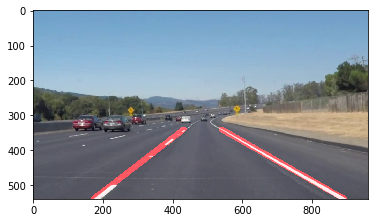

In [33]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 328 
 x2: 775 y2: 497

 Initial Right Values pe: 
 x1: 536 y1 : 341 
 x2: 759 y2: 497

 Initial Right Values pe: 
 x1: 603 y1 : 389 
 x2: 757 y2: 497

 Initial Right Values pe: 
 x1: 523 y1 : 329 
 x2: 773 y2: 497

 Initial Right Values pe: 
 x1: 525 y1 : 328 
 x2: 774 y2: 496

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 304

 RightX Median Values: 
: 654

 LeftIntercept Median: 
 608

 RightIntercept Median: 
 -28

 LeftSlope Average: 
 -0.617854864536

 RightSlope Average: 
 0.684171167779

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 830 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 110 Ly2: 540
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  0%|          | 0/682 [00:00<?, ?it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 328 
 x2: 775 y2: 497

 Initial Right Values pe: 
 x1: 536 y1 : 341 
 x2: 759 y2: 497

 Initial Right Values pe: 
 x1: 603 y1 : 389 
 x2: 757 y2: 497

 Initial Right Values pe: 
 x1: 523 y1 : 329 
 x2: 773 y2: 497

 Initial Right Values pe: 
 x1: 525 y1 : 328 
 x2: 774 y2: 496

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 304

 RightX Median Values: 
: 654

 LeftIntercept Median: 
 608

 RightIntercept Median: 
 -28

 LeftSlope Average: 
 -0.617854864536

 RightSlope Average: 
 0.684171167779

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 830 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 110 Ly2: 540
Image Height : 540 Image Width: 960



  0%|          | 2/682 [00:00<00:41, 16.24it/s]


 Initial Right Values pe: 
 x1: 523 y1 : 332 
 x2: 813 y2: 535

 Initial Right Values pe: 
 x1: 472 y1 : 300 
 x2: 831 y2: 533

 Initial Right Values pe: 
 x1: 613 y1 : 396 
 x2: 811 y2: 535

 Initial Right Values pe: 
 x1: 524 y1 : 332 
 x2: 832 y2: 532

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 299

 RightX Median Values: 
: 677

 LeftIntercept Median: 
 607

 RightIntercept Median: 
 -21

 LeftSlope Average: 
 -0.615351408386

 RightSlope Average: 
 0.675098980252

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 830 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 108 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 332 
 x2: 819 y2: 539

 Initial Right Values pe: 
 x1: 472 y1 : 300 
 x2: 839 y2: 538

 Initial Right Values pe: 
 x1: 527 y1 : 334 
 x2: 822 y2: 526

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540



Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 335 
 x2: 840 y2: 539

 Initial Right Values pe: 
 x1: 516 y1 : 326 
 x2: 820 y2: 539

 Initial Right Values pe: 
 x1: 525 y1 : 333 
 x2: 811 y2: 533

 Initial Right Values pe: 
 x1: 550 y1 : 349 
 x2: 840 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 678

 LeftIntercept Median: 
 613

 RightIntercept Median: 
 -22

 LeftSlope Average: 
 -0.633967157442

 RightSlope Average: 
 0.675859980117

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 831 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 115 Ly2: 540



  1%|          | 4/682 [00:00<00:40, 16.90it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 333 
 x2: 842 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 325 
 x2: 821 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 326 
 x2: 821 y2: 539

 Initial Right Values pe: 
 x1: 532 y1 : 335 
 x2: 816 y2: 520

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 243

 RightX Median Values: 
: 674

 LeftIntercept Median: 
 615

 RightIntercept Median: 
 -24

 LeftSlope Average: 
 -0.636934781167

 RightSlope Average: 
 0.675364604348

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 835 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 117 Ly2: 540
Image Height : 540 Image Width: 960



  1%|          | 6/682 [00:00<00:38, 17.57it/s]


 Initial Right Values pe: 
 x1: 529 y1 : 332 
 x2: 684 y2: 436

 Initial Right Values pe: 
 x1: 519 y1 : 328 
 x2: 673 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 284

 RightX Median Values: 
: 601

 LeftIntercept Median: 
 620

 RightIntercept Median: 
 -29

 LeftSlope Average: 
 -0.640017317891

 RightSlope Average: 
 0.686133221617

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 829 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 124 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 326 
 x2: 710 y2: 451

 Initial Right Values pe: 
 x1: 529 y1 : 336 
 x2: 701 y2: 452

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 278

 RightX Median Values: 
: 614

 LeftIntercept Median: 
 619

 RightIntercept Median: 
 -15

 LeftSlope Aver


  1%|          | 8/682 [00:00<00:37, 18.18it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 325 
 x2: 742 y2: 469

 Initial Right Values pe: 
 x1: 518 y1 : 326 
 x2: 724 y2: 470

 Initial Right Values pe: 
 x1: 522 y1 : 328 
 x2: 725 y2: 470

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 293

 RightX Median Values: 
: 625

 LeftIntercept Median: 
 622

 RightIntercept Median: 
 -28

 LeftSlope Average: 
 -0.644128009723

 RightSlope Average: 
 0.682395054675

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 832 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 127 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 324 
 x2: 785 y2: 497

 Initial Right Values pe: 
 x1: 519 y1 : 326 
 x2: 763 y2: 496

 Initial Right Values pe: 
 x1: 524 y1 : 328 
 x2: 762 y2: 495

 Initial Right Values pe: 
 x1: 531 y1 : 335 
 x2: 785 y2: 494

 Final Right Values: 


  1%|▏         | 10/682 [00:00<00:36, 18.31it/s]


 Initial Right Values pe: 
 x1: 532 y1 : 336 
 x2: 826 y2: 534

 Initial Right Values pe: 
 x1: 521 y1 : 325 
 x2: 843 y2: 534

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 319

 RightX Median Values: 
: 680

 LeftIntercept Median: 
 625

 RightIntercept Median: 
 -17

 LeftSlope Average: 
 -0.660855810158

 RightSlope Average: 
 0.661268855368

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 128 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 533 y1 : 337 
 x2: 689 y2: 442

 Initial Right Values pe: 
 x1: 520 y1 : 327 
 x2: 701 y2: 440

 Initial Right Values pe: 
 x1: 521 y1 : 327 
 x2: 673 y2: 422

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 317

 RightX Median Values: 
: 606

 LeftInterce

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 329 
 x2: 729 y2: 458

 Initial Right Values pe: 
 x1: 523 y1 : 325 
 x2: 717 y2: 460

 Initial Right Values pe: 
 x1: 537 y1 : 339 
 x2: 716 y2: 459

 Initial Right Values pe: 
 x1: 521 y1 : 327 
 x2: 730 y2: 458

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 624

 LeftIntercept Median: 
 626

 RightIntercept Median: 
 -14

 LeftSlope Average: 
 -0.660339285097

 RightSlope Average: 
 0.65481880018

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 130 Ly2: 540



  2%|▏         | 12/682 [00:00<00:36, 18.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 328 
 x2: 767 y2: 481

 Initial Right Values pe: 
 x1: 524 y1 : 330 
 x2: 751 y2: 483

 Initial Right Values pe: 
 x1: 605 y1 : 386 
 x2: 734 y2: 470

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 277

 RightX Median Values: 
: 650

 LeftIntercept Median: 
 628

 RightIntercept Median: 
 -9

 LeftSlope Average: 
 -0.668626026235

 RightSlope Average: 
 0.649887132396

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 131 Ly2: 540
Image Height : 540 Image Width: 960



  2%|▏         | 14/682 [00:00<00:36, 18.49it/s]


 Initial Right Values pe: 
 x1: 522 y1 : 329 
 x2: 819 y2: 514

 Initial Right Values pe: 
 x1: 515 y1 : 323 
 x2: 801 y2: 516

 Initial Right Values pe: 
 x1: 513 y1 : 321 
 x2: 803 y2: 516

 Initial Right Values pe: 
 x1: 571 y1 : 359 
 x2: 819 y2: 513

 Initial Right Values pe: 
 x1: 537 y1 : 339 
 x2: 800 y2: 516

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 294

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 629

 RightIntercept Median: 
 -13

 LeftSlope Average: 
 -0.662548793654

 RightSlope Average: 
 0.652821227008

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 134 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 329 
 x2: 859 y2: 538

 Initial Right Values pe: 
 x1: 572 y1 : 364 
 x2: 839 y2: 538

 Initial Right Values pe: 
 x1: 470 y1 : 299 
 x2: 838 y2

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 514 y1 : 322 
 x2: 860 y2: 538

 Initial Right Values pe: 
 x1: 576 y1 : 367 
 x2: 840 y2: 538

 Initial Right Values pe: 
 x1: 734 y1 : 470 
 x2: 837 y2: 537

 Initial Right Values pe: 
 x1: 524 y1 : 330 
 x2: 860 y2: 539

 Initial Right Values pe: 
 x1: 542 y1 : 344 
 x2: 839 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 273

 RightX Median Values: 
: 712

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.678816922767

 RightSlope Average: 
 0.638869125125

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 137 Ly2: 540



  2%|▏         | 16/682 [00:00<00:36, 18.42it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 468 y1 : 302 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 518 y1 : 321 
 x2: 839 y2: 538

 Initial Right Values pe: 
 x1: 516 y1 : 321 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 468 y1 : 301 
 x2: 857 y2: 535

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 273

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.678061816095

 RightSlope Average: 
 0.637994206711

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 137 Ly2: 540



  3%|▎         | 18/682 [00:00<00:36, 18.30it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 322 
 x2: 835 y2: 529

 Initial Right Values pe: 
 x1: 526 y1 : 332 
 x2: 670 y2: 429

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 636

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 -17

 LeftSlope Average: 
 -0.686706516754

 RightSlope Average: 
 0.661256966214

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 324 
 x2: 706 y2: 442

 Initial Right Values pe: 
 x1: 546 y1 : 346 
 x2: 695 y2: 443

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 284

 RightX Median Values: 
: 616

 LeftIntercept Median: 
 636

 RightInte

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 325 
 x2: 736 y2: 461

 Initial Right Values pe: 
 x1: 548 y1 : 347 
 x2: 724 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 284

 RightX Median Values: 
: 631

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.691512613489

 RightSlope Average: 
 0.635790241868

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 854 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 144 Ly2: 540



  3%|▎         | 20/682 [00:01<00:36, 18.03it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 323 
 x2: 774 y2: 483

 Initial Right Values pe: 
 x1: 550 y1 : 348 
 x2: 759 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 307

 RightX Median Values: 
: 650

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.687773400346

 RightSlope Average: 
 0.63425055387

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 139 Ly2: 540



  3%|▎         | 22/682 [00:01<00:36, 18.01it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 555 y1 : 351 
 x2: 811 y2: 517

 Initial Right Values pe: 
 x1: 531 y1 : 334 
 x2: 828 y2: 513

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 302

 RightX Median Values: 
: 681

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.688448181624

 RightSlope Average: 
 0.625565551347

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 861 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 324 
 x2: 696 y2: 435

 Initial Right Values pe: 
 x1: 556 y1 : 352 
 x2: 686 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 614

 LeftIntercept Median: 
 636

 RightInterc

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 324 
 x2: 725 y2: 453

 Initial Right Values pe: 
 x1: 535 y1 : 337 
 x2: 713 y2: 453

 Initial Right Values pe: 
 x1: 524 y1 : 326 
 x2: 724 y2: 451

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 354

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 630

 RightIntercept Median: 
 -5

 LeftSlope Average: 
 -0.680448110303

 RightSlope Average: 
 0.63429966183

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 132 Ly2: 540



  4%|▎         | 24/682 [00:01<00:37, 17.77it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 534 y1 : 337 
 x2: 745 y2: 474

 Initial Right Values pe: 
 x1: 520 y1 : 325 
 x2: 759 y2: 474

 Initial Right Values pe: 
 x1: 563 y1 : 357 
 x2: 743 y2: 474

 Initial Right Values pe: 
 x1: 521 y1 : 324 
 x2: 759 y2: 473

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 643

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 -5

 LeftSlope Average: 
 -0.682510542195

 RightSlope Average: 
 0.637192620509

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 139 Ly2: 540



  4%|▍         | 26/682 [00:01<00:37, 17.59it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 536 y1 : 339 
 x2: 787 y2: 502

 Initial Right Values pe: 
 x1: 566 y1 : 358 
 x2: 806 y2: 502

 Initial Right Values pe: 
 x1: 535 y1 : 338 
 x2: 806 y2: 501

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 672

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.689485773271

 RightSlope Average: 
 0.616959468399

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 537 y1 : 338 
 x2: 871 y2: 539

 Initial Right Values pe: 
 x1: 521 y1 : 327 
 x2: 848 y2: 539

 Initial Right Values pe: 
 x1: 539 y1 : 340 
 x2: 862 y2: 534

 Initial Right Values pe: 
 x1: 622 y1 : 396 
 x2: 847 y2: 537

 Final Right Values: 
 

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 525 y1 : 329 
 x2: 872 y2: 538

 Initial Right Values pe: 
 x1: 635 y1 : 403 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 539 y1 : 339 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 575 y1 : 364 
 x2: 835 y2: 527

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 712

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.69975785564

 RightSlope Average: 
 0.613406535697

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 864 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 145 Ly2: 540



  4%|▍         | 28/682 [00:01<00:37, 17.24it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 327 
 x2: 875 y2: 538

 Initial Right Values pe: 
 x1: 580 y1 : 366 
 x2: 854 y2: 537

 Initial Right Values pe: 
 x1: 514 y1 : 318 
 x2: 854 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 700

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.722774671752

 RightSlope Average: 
 0.625075730793

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 863 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 150 Ly2: 540



  4%|▍         | 30/682 [00:01<00:38, 17.12it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 592 y1 : 373 
 x2: 878 y2: 538

 Initial Right Values pe: 
 x1: 515 y1 : 318 
 x2: 849 y2: 534

 Initial Right Values pe: 
 x1: 515 y1 : 317 
 x2: 857 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX Median Values: 
: 701

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.702151585815

 RightSlope Average: 
 0.624250823589

 Final Right Value with Slope: 
 Rx1: 546 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 317 
 x2: 697 y2: 435

 Initial Right Values pe: 
 x1: 527 y1 : 328 
 x2: 620 y2: 390

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 292

 RightX 

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 548 y1 : 343 
 x2: 713 y2: 450

 Initial Right Values pe: 
 x1: 517 y1 : 319 
 x2: 727 y2: 450

 Initial Right Values pe: 
 x1: 517 y1 : 318 
 x2: 721 y2: 450

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 -10

 LeftSlope Average: 
 -0.735094751359

 RightSlope Average: 
 0.639784398608

 Final Right Value with Slope: 
 Rx1: 547 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 156 Ly2: 540



  5%|▍         | 32/682 [00:01<00:37, 17.15it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 319 
 x2: 760 y2: 470

 Initial Right Values pe: 
 x1: 518 y1 : 320 
 x2: 644 y2: 405

 Initial Right Values pe: 
 x1: 551 y1 : 344 
 x2: 744 y2: 469

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 622

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 -15

 LeftSlope Average: 
 -0.709292222712

 RightSlope Average: 
 0.647890248447

 Final Right Value with Slope: 
 Rx1: 547 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 148 Ly2: 540



  5%|▍         | 34/682 [00:01<00:37, 17.26it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 330 
 x2: 661 y2: 415

 Initial Right Values pe: 
 x1: 521 y1 : 321 
 x2: 805 y2: 498

 Initial Right Values pe: 
 x1: 517 y1 : 319 
 x2: 803 y2: 498

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 -8

 LeftSlope Average: 
 -0.715522979482

 RightSlope Average: 
 0.632656174775

 Final Right Value with Slope: 
 Rx1: 550 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 320 
 x2: 865 y2: 536

 Initial Right Values pe: 
 x1: 532 y1 : 331 
 x2: 679 y2: 427

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX 

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 320 
 x2: 713 y2: 441

 Initial Right Values pe: 
 x1: 533 y1 : 332 
 x2: 701 y2: 441

 Initial Right Values pe: 
 x1: 519 y1 : 319 
 x2: 714 y2: 441

 Initial Right Values pe: 
 x1: 519 y1 : 321 
 x2: 704 y2: 441

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 615

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 -9

 LeftSlope Average: 
 -0.730364278676

 RightSlope Average: 
 0.636702634576

 Final Right Value with Slope: 
 Rx1: 548 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 151 Ly2: 540



  5%|▌         | 36/682 [00:02<00:37, 17.18it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 533 y1 : 331 
 x2: 745 y2: 458

 Initial Right Values pe: 
 x1: 533 y1 : 332 
 x2: 695 y2: 437

 Initial Right Values pe: 
 x1: 564 y1 : 353 
 x2: 735 y2: 460

 Initial Right Values pe: 
 x1: 520 y1 : 319 
 x2: 708 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 -8

 LeftSlope Average: 
 -0.735690005418

 RightSlope Average: 
 0.635787128008

 Final Right Value with Slope: 
 Rx1: 547 Ry1 : 340 
 Rx2: 861 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 153 Ly2: 540



  6%|▌         | 38/682 [00:02<00:37, 17.13it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 564 y1 : 353 
 x2: 786 y2: 481

 Initial Right Values pe: 
 x1: 669 y1 : 420 
 x2: 772 y2: 484

 Initial Right Values pe: 
 x1: 565 y1 : 353 
 x2: 778 y2: 476

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 358

 RightX Median Values: 
: 689

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.744632717264

 RightSlope Average: 
 0.591800196203

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 154 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 322 
 x2: 841 y2: 515

 Initial Right Values pe: 
 x1: 574 y1 : 359 
 x2: 823 y2: 515

 Initial Right Values pe: 
 x1: 526 y1 : 324 
 x2: 841 y2: 513

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 321 
 x2: 883 y2: 539

 Initial Right Values pe: 
 x1: 572 y1 : 357 
 x2: 863 y2: 539

 Initial Right Values pe: 
 x1: 521 y1 : 322 
 x2: 856 y2: 523

 Initial Right Values pe: 
 x1: 543 y1 : 338 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 715 y1 : 448 
 x2: 817 y2: 511

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median Values: 
: 715

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 3

 LeftSlope Average: 
 -0.735016086993

 RightSlope Average: 
 0.614057311368

 Final Right Value with Slope: 
 Rx1: 548 Ry1 : 340 
 Rx2: 874 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 151 Ly2: 540



  6%|▌         | 40/682 [00:02<00:37, 16.96it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 577 y1 : 361 
 x2: 862 y2: 539

 Initial Right Values pe: 
 x1: 522 y1 : 322 
 x2: 883 y2: 538

 Initial Right Values pe: 
 x1: 522 y1 : 323 
 x2: 810 y2: 496

 Initial Right Values pe: 
 x1: 539 y1 : 335 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 580 y1 : 363 
 x2: 812 y2: 508

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 697

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 3

 LeftSlope Average: 
 -0.721336107629

 RightSlope Average: 
 0.615027401594

 Final Right Value with Slope: 
 Rx1: 547 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 148 Ly2: 540



  6%|▌         | 42/682 [00:02<00:37, 16.96it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 543 y1 : 339 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 514 y1 : 318 
 x2: 882 y2: 539

 Initial Right Values pe: 
 x1: 513 y1 : 317 
 x2: 882 y2: 538

 Initial Right Values pe: 
 x1: 581 y1 : 364 
 x2: 861 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 356

 RightX Median Values: 
: 704

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.723919534854

 RightSlope Average: 
 0.612561407736

 Final Right Value with Slope: 
 Rx1: 548 Ry1 : 340 
 Rx2: 875 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960



 Initial Right Values pe: 
 x1: 513 y1 : 316 
 x2: 853 y2: 528

 Initial Right Values pe: 
 x1: 587 y1 : 368 
 x2: 883 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 709

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.742614367207

 RightSlope Average: 
 0.600616057234

 Final Right Value with Slope: 
 Rx1: 547 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 421 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960



  6%|▋         | 44/682 [00:02<00:56, 11.24it/s]


 Initial Right Values pe: 
 x1: 514 y1 : 319 
 x2: 714 y2: 439

 Initial Right Values pe: 
 x1: 524 y1 : 327 
 x2: 624 y2: 392

 Initial Right Values pe: 
 x1: 514 y1 : 318 
 x2: 708 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 599

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.726244383132

 RightSlope Average: 
 0.624570446735

 Final Right Value with Slope: 
 Rx1: 547 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 514 y1 : 319 
 x2: 739 y2: 459

 Initial Right Values pe: 
 x1: 525 y1 : 329 
 x2: 636 y2: 401

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 603

 LeftIntercep


  7%|▋         | 46/682 [00:02<01:00, 10.43it/s]

 516 y1 : 323 
 x2: 780 y2: 482

 Initial Right Values pe: 
 x1: 608 y1 : 384 
 x2: 652 y2: 411

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 349

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.736545273245

 RightSlope Average: 
 0.607954545455

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 870 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 320 
 x2: 827 y2: 514

 Initial Right Values pe: 
 x1: 517 y1 : 324 
 x2: 668 y2: 422

 Initial Right Values pe: 
 x1: 519 y1 : 323 
 x2: 825 y2: 514

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 645

 LeftIntercept Median: 
 651

 RightIntercept


  7%|▋         | 48/682 [00:03<01:02, 10.11it/s]

 540 Image Width: 960

 Initial Right Values pe: 
 x1: 515 y1 : 323 
 x2: 699 y2: 434

 Initial Right Values pe: 
 x1: 558 y1 : 353 
 x2: 689 y2: 435

 Initial Right Values pe: 
 x1: 515 y1 : 322 
 x2: 700 y2: 433

 Initial Right Values pe: 
 x1: 554 y1 : 350 
 x2: 691 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 350

 RightX Median Values: 
: 615

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.723155760047

 RightSlope Average: 
 0.612413256061

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 868 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 323 
 x2: 726 y2: 449

 Initial Right Values pe: 
 x1: 557 y1 : 352 
 x2: 716 y2: 451

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 


  7%|▋         | 50/682 [00:03<01:03,  9.92it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 561 y1 : 354 
 x2: 748 y2: 471

 Initial Right Values pe: 
 x1: 517 y1 : 322 
 x2: 762 y2: 469

 Initial Right Values pe: 
 x1: 517 y1 : 323 
 x2: 761 y2: 470

 Initial Right Values pe: 
 x1: 531 y1 : 334 
 x2: 750 y2: 471

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 332

 RightX Median Values: 
: 643

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.734904063608

 RightSlope Average: 
 0.613424560462

 Final Right Value with Slope: 
 Rx1: 544 Ry1 : 340 
 Rx2: 870 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 421 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 564 y1 : 356 
 x2: 791 y2: 498

 Initial Right Values pe: 
 x1: 518 y1 : 322 
 x2: 808 y2: 497

 Initial Right Values pe: 
 x1: 518 y1 : 324 
 x2: 808 y2: 498

 Initial Right Values p


  8%|▊         | 52/682 [00:03<01:04,  9.76it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 567 y1 : 358 
 x2: 852 y2: 536

 Initial Right Values pe: 
 x1: 520 y1 : 325 
 x2: 872 y2: 536

 Initial Right Values pe: 
 x1: 533 y1 : 336 
 x2: 855 y2: 537

 Initial Right Values pe: 
 x1: 519 y1 : 323 
 x2: 873 y2: 535

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 359

 RightX Median Values: 
: 698

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.718372130465

 RightSlope Average: 
 0.611771720168

 Final Right Value with Slope: 
 Rx1: 544 Ry1 : 340 
 Rx2: 871 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 536 y1 : 338 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 572 y1 : 362 
 x2: 878 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 324 
 x2: 780 y2: 492

 Initial Right Values p


  8%|▊         | 54/682 [00:03<01:05,  9.66it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 329 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 326 
 x2: 876 y2: 539

 Initial Right Values pe: 
 x1: 537 y1 : 340 
 x2: 856 y2: 539

 Initial Right Values pe: 
 x1: 521 y1 : 325 
 x2: 876 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 345

 RightX Median Values: 
: 695

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.735834099402

 RightSlope Average: 
 0.612393238601

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 868 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 422 Ly1 : 340 
 Lx2: 150 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 331 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 522 y1 : 326 
 x2: 876 y2: 539

 Initial Right Values pe: 
 x1: 522 y1 : 329 
 x2: 821 y2: 509

 Final Right Values: 
 


  8%|▊         | 57/682 [00:04<01:05,  9.60it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 513 y1 : 320 
 x2: 691 y2: 431

 Initial Right Values pe: 
 x1: 522 y1 : 329 
 x2: 693 y2: 431

 Initial Right Values pe: 
 x1: 523 y1 : 330 
 x2: 616 y2: 390

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 358

 RightX Median Values: 
: 593

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.731854677343

 RightSlope Average: 
 0.621749341337

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 865 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 330 
 x2: 626 y2: 397

 Initial Right Values pe: 
 x1: 513 y1 : 320 
 x2: 715 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX M


  9%|▊         | 58/682 [00:04<01:06,  9.33it/s]

 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 331 
 x2: 637 y2: 405

 Initial Right Values pe: 
 x1: 513 y1 : 322 
 x2: 745 y2: 466

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 361

 RightX Median Values: 
: 604

 LeftIntercept Median: 
 654

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.741465966808

 RightSlope Average: 
 0.634906231095

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 514 y1 : 324 
 x2: 792 y2: 491

 Initial Right Values pe: 
 x1: 525 y1 : 332 
 x2: 651 y2: 414

 Initial Right Values pe: 
 x1: 513 y1 : 322 
 x2: 784 y2: 491

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 349

 RightX Median Values:


  9%|▉         | 60/682 [00:04<01:09,  9.00it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 550 y1 : 349 
 x2: 851 y2: 522

 Initial Right Values pe: 
 x1: 619 y1 : 394 
 x2: 836 y2: 529

 Initial Right Values pe: 
 x1: 549 y1 : 349 
 x2: 851 y2: 523

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 709

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.71852695041

 RightSlope Average: 
 0.59100986221

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 326 
 x2: 704 y2: 439

 Initial Right Values pe: 
 x1: 527 y1 : 334 
 x2: 686 y2: 437

 Initial Right Values pe: 
 x1: 554 y1 : 353 
 x2: 695 y2: 441

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly


  9%|▉         | 62/682 [00:04<01:07,  9.16it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 334 
 x2: 732 y2: 456

 Initial Right Values pe: 
 x1: 561 y1 : 357 
 x2: 722 y2: 458

 Initial Right Values pe: 
 x1: 517 y1 : 326 
 x2: 733 y2: 456

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 632

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 12

 LeftSlope Average: 
 -0.707755029629

 RightSlope Average: 
 0.609073420028

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 422 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 660 y1 : 420 
 x2: 757 y2: 480

 Initial Right Values pe: 
 x1: 529 y1 : 335 
 x2: 771 y2: 480

 Initial Right Values pe: 
 x1: 516 y1 : 325 
 x2: 771 y2: 478

 Initial Right Values pe: 
 x1: 558 y1 : 355 
 x2: 758 y2: 480

 Initial Right Values 


  9%|▉         | 64/682 [00:04<01:05,  9.38it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 564 y1 : 359 
 x2: 804 y2: 509

 Initial Right Values pe: 
 x1: 517 y1 : 326 
 x2: 821 y2: 509

 Initial Right Values pe: 
 x1: 563 y1 : 358 
 x2: 807 y2: 510

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 679

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.700869252822

 RightSlope Average: 
 0.616641501294

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 861 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 568 y1 : 362 
 x2: 850 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 328 
 x2: 862 y2: 534

 Initial Right Values pe: 
 x1: 703 y1 : 447 
 x2: 850 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 327 
 x2: 863 y2: 534

 Final Right Values: 
 


 10%|▉         | 67/682 [00:05<01:06,  9.29it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 328 
 x2: 870 y2: 539

 Initial Right Values pe: 
 x1: 571 y1 : 364 
 x2: 849 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 702

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.693379612231

 RightSlope Average: 
 0.613519440858

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 576 y1 : 368 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 329 
 x2: 868 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 703

 LeftIntercept Median: 
 638

 RightInter


 10%|▉         | 68/682 [00:05<01:11,  8.54it/s]


 Initial Right Values pe: 
 x1: 523 y1 : 328 
 x2: 848 y2: 539

 Initial Right Values pe: 
 x1: 521 y1 : 329 
 x2: 869 y2: 538

 Initial Right Values pe: 
 x1: 580 y1 : 371 
 x2: 848 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 698

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.706367774528

 RightSlope Average: 
 0.624313270078

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 332 
 x2: 699 y2: 438

 Initial Right Values pe: 
 x1: 588 y1 : 376 
 x2: 689 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 624

 LeftIntercept


 10%|█         | 70/682 [00:05<01:09,  8.78it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 593 y1 : 380 
 x2: 718 y2: 455

 Initial Right Values pe: 
 x1: 542 y1 : 345 
 x2: 728 y2: 452

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 356

 RightX Median Values: 
: 645

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 28

 LeftSlope Average: 
 -0.708777673819

 RightSlope Average: 
 0.587634408602

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 871 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 333 
 x2: 763 y2: 476

 Initial Right Values pe: 
 x1: 515 y1 : 326 
 x2: 634 y2: 406

 Initial Right Values pe: 
 x1: 482 y1 : 298 
 x2: 640 y2: 409

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX 


 11%|█         | 72/682 [00:05<01:07,  9.10it/s]

 540 Image Width: 960

 Initial Right Values pe: 
 x1: 548 y1 : 350 
 x2: 656 y2: 420

 Initial Right Values pe: 
 x1: 513 y1 : 324 
 x2: 804 y2: 505

 Initial Right Values pe: 
 x1: 525 y1 : 334 
 x2: 657 y2: 420

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 360

 RightX Median Values: 
: 617

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 -3

 LeftSlope Average: 
 -0.711615197181

 RightSlope Average: 
 0.64055214227

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 335 
 x2: 686 y2: 430

 Initial Right Values pe: 
 x1: 528 y1 : 336 
 x2: 675 y2: 432

 Initial Right Values pe: 
 x1: 515 y1 : 325 
 x2: 686 y2: 432

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 


 11%|█         | 74/682 [00:05<01:09,  8.79it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 552 y1 : 353 
 x2: 699 y2: 448

 Initial Right Values pe: 
 x1: 516 y1 : 326 
 x2: 711 y2: 448

 Initial Right Values pe: 
 x1: 528 y1 : 336 
 x2: 711 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 619

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.704671017573

 RightSlope Average: 
 0.624330808406

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 531 y1 : 339 
 x2: 728 y2: 467

 Initial Right Values pe: 
 x1: 555 y1 : 354 
 x2: 743 y2: 467

 Initial Right Values pe: 
 x1: 480 y1 : 298 
 x2: 663 y2: 426

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 11%|█         | 76/682 [00:06<01:07,  9.00it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 533 y1 : 341 
 x2: 783 y2: 491

 Initial Right Values pe: 
 x1: 558 y1 : 358 
 x2: 767 y2: 493

 Initial Right Values pe: 
 x1: 517 y1 : 329 
 x2: 769 y2: 493

 Initial Right Values pe: 
 x1: 531 y1 : 339 
 x2: 784 y2: 491

 Initial Right Values pe: 
 x1: 480 y1 : 300 
 x2: 749 y2: 481

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.705955086465

 RightSlope Average: 
 0.634075926503

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 330 
 x2: 822 y2: 527

 Initial Right Values pe: 
 x1: 532 y1 : 340 
 x2: 840 y2: 525

 Initial Right Values p


 11%|█▏        | 78/682 [00:06<01:05,  9.19it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 534 y1 : 341 
 x2: 800 y2: 514

 Initial Right Values pe: 
 x1: 565 y1 : 360 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 518 y1 : 329 
 x2: 841 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 356

 RightX Median Values: 
: 686

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.710200987052

 RightSlope Average: 
 0.633960696654

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 423 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 540 y1 : 345 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 534 y1 : 341 
 x2: 805 y2: 517

 Initial Right Values pe: 
 x1: 519 y1 : 330 
 x2: 840 y2: 538

 Initial Right Values pe: 
 x1: 524 y1 : 331 
 x2: 787 y2: 495

 Final Right Values: 
 


 12%|█▏        | 80/682 [00:06<01:04,  9.32it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 536 y1 : 342 
 x2: 840 y2: 539

 Initial Right Values pe: 
 x1: 523 y1 : 328 
 x2: 860 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 331 
 x2: 839 y2: 538

 Initial Right Values pe: 
 x1: 522 y1 : 328 
 x2: 789 y2: 501

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 678

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 -5

 LeftSlope Average: 
 -0.710933136074

 RightSlope Average: 
 0.642513796879

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 514 y1 : 323 
 x2: 674 y2: 427

 Initial Right Values pe: 
 x1: 512 y1 : 325 
 x2: 665 y2: 428

 Initial Right Values pe: 
 x1: 521 y1 : 332 
 x2: 663 y2: 428

 Final Right Values: 



 12%|█▏        | 82/682 [00:06<01:03,  9.42it/s]


 Initial Right Values pe: 
 x1: 512 y1 : 325 
 x2: 685 y2: 441

 Initial Right Values pe: 
 x1: 512 y1 : 324 
 x2: 697 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 332

 RightX Median Values: 
: 601

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 -6

 LeftSlope Average: 
 -0.708586499178

 RightSlope Average: 
 0.646070926418

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 332 
 x2: 709 y2: 458

 Initial Right Values pe: 
 x1: 513 y1 : 323 
 x2: 720 y2: 457

 Initial Right Values pe: 
 x1: 513 y1 : 324 
 x2: 726 y2: 457

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 617

 LeftIntercep


 12%|█▏        | 84/682 [00:06<01:03,  9.46it/s]

 513 y1 : 325 
 x2: 741 y2: 479

 Initial Right Values pe: 
 x1: 513 y1 : 324 
 x2: 761 y2: 479

 Initial Right Values pe: 
 x1: 524 y1 : 332 
 x2: 746 y2: 482

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 633

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 -13

 LeftSlope Average: 
 -0.705361267251

 RightSlope Average: 
 0.658704757389

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 422 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 514 y1 : 325 
 x2: 809 y2: 509

 Initial Right Values pe: 
 x1: 515 y1 : 327 
 x2: 653 y2: 420

 Initial Right Values pe: 
 x1: 514 y1 : 326 
 x2: 807 y2: 509

 Initial Right Values pe: 
 x1: 515 y1 : 326 
 x2: 793 y2: 513

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1


 13%|█▎        | 86/682 [00:07<01:02,  9.50it/s]

 515 y1 : 326 
 x2: 678 y2: 436

 Initial Right Values pe: 
 x1: 527 y1 : 336 
 x2: 690 y2: 434

 Initial Right Values pe: 
 x1: 549 y1 : 351 
 x2: 688 y2: 434

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.706362640943

 RightSlope Average: 
 0.624398640597

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 515 y1 : 326 
 x2: 702 y2: 452

 Initial Right Values pe: 
 x1: 519 y1 : 328 
 x2: 716 y2: 451

 Initial Right Values pe: 
 x1: 527 y1 : 336 
 x2: 707 y2: 453

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Media


 13%|█▎        | 89/682 [00:07<01:02,  9.48it/s]


 Initial Right Values pe: 
 x1: 518 y1 : 328 
 x2: 750 y2: 472

 Initial Right Values pe: 
 x1: 641 y1 : 412 
 x2: 737 y2: 474

 Initial Right Values pe: 
 x1: 530 y1 : 338 
 x2: 739 y2: 474

 Initial Right Values pe: 
 x1: 555 y1 : 355 
 x2: 738 y2: 474

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 310

 RightX Median Values: 
: 651

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.688767063783

 RightSlope Average: 
 0.641878478975

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 136 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 299 
 x2: 778 y2: 501

 Initial Right Values pe: 
 x1: 517 y1 : 326 
 x2: 797 y2: 501

 Initial Right Values pe: 
 x1: 518 y1 : 328 
 x2: 746 y2: 481

 Initial Right Values pe: 
 x1: 533 y1 : 340 
 x2: 782 y2:


 13%|█▎        | 91/682 [00:07<01:04,  9.17it/s]


 Initial Right Values pe: 
 x1: 562 y1 : 360 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 518 y1 : 327 
 x2: 850 y2: 534

 Initial Right Values pe: 
 x1: 531 y1 : 339 
 x2: 832 y2: 535

 Initial Right Values pe: 
 x1: 677 y1 : 436 
 x2: 835 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 327 
 x2: 859 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 701

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.694130260806

 RightSlope Average: 
 0.638678167023

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 566 y1 : 364 
 x2: 835 y2: 539

 Initial Right Values pe: 
 x1: 520 y1 : 329 
 x2: 856 y2: 539

 Initial Right Values pe: 
 x1: 534 y1 : 342 
 x2: 835 y2: 


 13%|█▎        | 92/682 [00:07<01:06,  8.84it/s]


 Initial Right Values pe: 
 x1: 479 y1 : 304 
 x2: 855 y2: 539

 Initial Right Values pe: 
 x1: 537 y1 : 345 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 572 y1 : 369 
 x2: 833 y2: 539

 Initial Right Values pe: 
 x1: 520 y1 : 331 
 x2: 819 y2: 517

 Initial Right Values pe: 
 x1: 802 y1 : 505 
 x2: 855 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 274

 RightX Median Values: 
: 710

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.685161224888

 RightSlope Average: 
 0.634177546806

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 303 
 x2: 818 y2: 530

 Initial Right Values pe: 
 x1: 575 y1 : 371 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 832 y2: 


 14%|█▍        | 94/682 [00:08<01:04,  9.05it/s]


 Initial Right Values pe: 
 x1: 522 y1 : 336 
 x2: 678 y2: 430

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 319

 RightX Median Values: 
: 600

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.684188547366

 RightSlope Average: 
 0.602564102564

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 861 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 702 y2: 446

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 685 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 352

 RightX Median Values: 
: 608

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.682428773287

 RightSlope Average: 
 0.646475619008

 Fi


 14%|█▍        | 96/682 [00:08<01:03,  9.17it/s]

 512 y1 : 329 
 x2: 713 y2: 464

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 726 y2: 465

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 -10

 LeftSlope Average: 
 -0.688620844744

 RightSlope Average: 
 0.660417669716

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 832 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 338 
 x2: 637 y2: 413

 Initial Right Values pe: 
 x1: 515 y1 : 327 
 x2: 763 y2: 488

 Initial Right Values pe: 
 x1: 479 y1 : 303 
 x2: 647 y2: 412

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX Median Values: 
: 594

 LeftIntercept Median: 
 640

 RightIntercep


 14%|█▍        | 98/682 [00:08<01:03,  9.19it/s]


 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 820 y2: 518

 Initial Right Values pe: 
 x1: 514 y1 : 329 
 x2: 654 y2: 423

 Initial Right Values pe: 
 x1: 517 y1 : 327 
 x2: 813 y2: 519

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 632

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 -6

 LeftSlope Average: 
 -0.692103183084

 RightSlope Average: 
 0.648236883721

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 330 
 x2: 672 y2: 435

 Initial Right Values pe: 
 x1: 516 y1 : 328 
 x2: 684 y2: 433

 Initial Right Values pe: 
 x1: 515 y1 : 329 
 x2: 683 y2: 434

 Initial Right Values pe: 
 x1: 482 y1 : 302 
 x2: 674 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 15%|█▍        | 100/682 [00:08<01:02,  9.28it/s]


 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 697 y2: 451

 Initial Right Values pe: 
 x1: 520 y1 : 331 
 x2: 708 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 600

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 -6

 LeftSlope Average: 
 -0.688915747399

 RightSlope Average: 
 0.649069756145

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 841 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 302 
 x2: 726 y2: 470

 Initial Right Values pe: 
 x1: 519 y1 : 331 
 x2: 739 y2: 468

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 671 y2: 434

 Initial Right Values pe: 
 x1: 479 y1 : 304 
 x2: 741 y2: 468

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 15%|█▍        | 102/682 [00:08<01:01,  9.36it/s]


 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 782 y2: 493

 Initial Right Values pe: 
 x1: 662 y1 : 428 
 x2: 768 y2: 496

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 782 y2: 494

 Initial Right Values pe: 
 x1: 560 y1 : 360 
 x2: 769 y2: 496

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 660

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.688705400617

 RightSlope Average: 
 0.635247378387

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 682 y1 : 441 
 x2: 821 y2: 531

 Initial Right Values pe: 
 x1: 477 y1 : 302 
 x2: 839 y2: 529

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 839 y2: 530

 Initial Right Values pe: 
 x1: 572 y1 : 368 
 x2: 823 y2: 


 15%|█▌        | 104/682 [00:09<01:06,  8.67it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 708 y1 : 457 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 854 y2: 539

 Initial Right Values pe: 
 x1: 708 y1 : 458 
 x2: 832 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 718

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.688320157241

 RightSlope Average: 
 0.637556451613

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 573 y1 : 368 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 741 y1 : 479 
 x2: 833 y2: 537

 Initial Right Values pe: 
 x1: 479 y1 : 302 
 x2: 747 y2: 476

 Initial Right Values p


 16%|█▌        | 106/682 [00:09<01:06,  8.66it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 855 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 305 
 x2: 833 y2: 539

 Initial Right Values pe: 
 x1: 540 y1 : 346 
 x2: 657 y2: 422

 Initial Right Values pe: 
 x1: 479 y1 : 302 
 x2: 854 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 357

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 -5

 LeftSlope Average: 
 -0.685414384181

 RightSlope Average: 
 0.643661951076

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 135 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 302 
 x2: 681 y2: 433

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 608 y2: 391

 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 686 y2: 433

 Final Right Values: 



 16%|█▌        | 107/682 [00:09<01:06,  8.59it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 542 y1 : 348 
 x2: 699 y2: 450

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 710 y2: 449

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 270

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.683784977654

 RightSlope Average: 
 0.63652907602

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 336 
 x2: 742 y2: 467

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 631 y2: 407

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 735 y2: 469

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 342

 RightX Me


 16%|█▋        | 111/682 [00:09<01:04,  8.90it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 781 y2: 494

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 646 y2: 417

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 598

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 -6

 LeftSlope Average: 
 -0.686986215379

 RightSlope Average: 
 0.648460102181

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 841 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 305 
 x2: 837 y2: 529

 Initial Right Values pe: 
 x1: 479 y1 : 308 
 x2: 827 y2: 534

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 662 y2: 428

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 355

 RightX 


 16%|█▋        | 112/682 [00:10<01:04,  8.89it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 305 
 x2: 690 y2: 437

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 682 y2: 441

 Initial Right Values pe: 
 x1: 529 y1 : 340 
 x2: 684 y2: 441

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 344

 RightX Median Values: 
: 590

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.684261821074

 RightSlope Average: 
 0.648607680037

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 838 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 332 
 x2: 721 y2: 456

 Initial Right Values pe: 
 x1: 534 y1 : 343 
 x2: 711 y2: 458

 Initial Right Values pe: 
 x1: 562 y1 : 362 
 x2: 709 y2: 458

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 17%|█▋        | 114/682 [00:10<01:05,  8.70it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 329 
 x2: 756 y2: 477

 Initial Right Values pe: 
 x1: 560 y1 : 360 
 x2: 743 y2: 479

 Initial Right Values pe: 
 x1: 520 y1 : 331 
 x2: 758 y2: 479

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 3

 LeftSlope Average: 
 -0.687250313409

 RightSlope Average: 
 0.632198179126

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 565 y1 : 363 
 x2: 788 y2: 508

 Initial Right Values pe: 
 x1: 535 y1 : 343 
 x2: 805 y2: 506

 Initial Right Values pe: 
 x1: 534 y1 : 342 
 x2: 789 y2: 508

 Initial Right Values pe: 
 x1: 520 y1 : 329 
 x2: 794 y2: 500

 Final Right Values: 
 


 17%|█▋        | 116/682 [00:10<01:03,  8.95it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 537 y1 : 344 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 525 y1 : 331 
 x2: 855 y2: 537

 Initial Right Values pe: 
 x1: 521 y1 : 330 
 x2: 810 y2: 510

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 680

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.692937981172

 RightSlope Average: 
 0.631969741974

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 573 y1 : 367 
 x2: 857 y2: 537

 Initial Right Values pe: 
 x1: 538 y1 : 344 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 330 
 x2: 771 y2: 497

 Initial Right Values pe: 
 x1: 524 y1 : 330 
 x2: 796 y2: 513

 Initial Right Values p


 17%|█▋        | 119/682 [00:10<01:02,  8.97it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 578 y1 : 371 
 x2: 834 y2: 537

 Initial Right Values pe: 
 x1: 578 y1 : 370 
 x2: 860 y2: 539

 Initial Right Values pe: 
 x1: 596 y1 : 376 
 x2: 838 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 714

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 -2

 LeftSlope Average: 
 -0.708130945652

 RightSlope Average: 
 0.64042733305

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 583 y1 : 374 
 x2: 830 y2: 534

 Initial Right Values pe: 
 x1: 524 y1 : 334 
 x2: 839 y2: 539

 Initial Right Values pe: 
 x1: 525 y1 : 331 
 x2: 675 y2: 428

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 18%|█▊        | 120/682 [00:10<01:03,  8.78it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 505 y1 : 320 
 x2: 700 y2: 442

 Initial Right Values pe: 
 x1: 544 y1 : 348 
 x2: 689 y2: 442

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 609

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.693642084741

 RightSlope Average: 
 0.636958443855

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 569 y1 : 365 
 x2: 714 y2: 459

 Initial Right Values pe: 
 x1: 529 y1 : 333 
 x2: 723 y2: 459

 Initial Right Values pe: 
 x1: 526 y1 : 335 
 x2: 628 y2: 403

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX M


 18%|█▊        | 122/682 [00:11<01:01,  9.05it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 334 
 x2: 763 y2: 481

 Initial Right Values pe: 
 x1: 548 y1 : 351 
 x2: 749 y2: 481

 Initial Right Values pe: 
 x1: 529 y1 : 334 
 x2: 764 y2: 481

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 296

 RightX Median Values: 
: 646

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.708599775328

 RightSlope Average: 
 0.632609999647

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 531 y1 : 339 
 x2: 794 y2: 510

 Initial Right Values pe: 
 x1: 528 y1 : 337 
 x2: 815 y2: 509

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX M


 18%|█▊        | 123/682 [00:11<01:02,  8.90it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 329 
 x2: 691 y2: 436

 Initial Right Values pe: 
 x1: 554 y1 : 355 
 x2: 682 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 611

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.704182363863

 RightSlope Average: 
 0.637084247076

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 329 
 x2: 717 y2: 451

 Initial Right Values pe: 
 x1: 532 y1 : 340 
 x2: 706 y2: 453

 Initial Right Values pe: 
 x1: 520 y1 : 330 
 x2: 717 y2: 453

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 290

 RightX M


 18%|█▊        | 126/682 [00:11<01:08,  8.08it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 560 y1 : 359 
 x2: 738 y2: 474

 Initial Right Values pe: 
 x1: 522 y1 : 330 
 x2: 750 y2: 472

 Initial Right Values pe: 
 x1: 525 y1 : 332 
 x2: 747 y2: 471

 Initial Right Values pe: 
 x1: 522 y1 : 333 
 x2: 739 y2: 474

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 295

 RightX Median Values: 
: 637

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.708786390479

 RightSlope Average: 
 0.636192536163

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 537 y1 : 344 
 x2: 779 y2: 501

 Initial Right Values pe: 
 x1: 523 y1 : 331 
 x2: 795 y2: 501

 Initial Right Values pe: 
 x1: 522 y1 : 333 
 x2: 782 y2: 502

 Final Right Values: 
 


 19%|█▉        | 128/682 [00:12<01:22,  6.72it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 335 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 524 y1 : 332 
 x2: 856 y2: 539

 Initial Right Values pe: 
 x1: 736 y1 : 462 
 x2: 855 y2: 536

 Initial Right Values pe: 
 x1: 568 y1 : 365 
 x2: 835 y2: 539

 Initial Right Values pe: 
 x1: 526 y1 : 332 
 x2: 856 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 342

 RightX Median Values: 
: 711

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.68956298366

 RightSlope Average: 
 0.633966566644

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960



 19%|█▉        | 129/682 [00:12<01:20,  6.90it/s]


 Initial Right Values pe: 
 x1: 537 y1 : 344 
 x2: 860 y2: 538

 Initial Right Values pe: 
 x1: 715 y1 : 461 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 538 y1 : 345 
 x2: 859 y2: 538

 Initial Right Values pe: 
 x1: 627 y1 : 404 
 x2: 773 y2: 496

 Initial Right Values pe: 
 x1: 523 y1 : 334 
 x2: 834 y2: 521

 Initial Right Values pe: 
 x1: 716 y1 : 461 
 x2: 768 y2: 493

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 715

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 18

 LeftSlope Average: 
 -0.696432077832

 RightSlope Average: 
 0.612448222741

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 334 
 x2: 839 y2: 539

 Initial Right Values pe: 
 x1: 539 y1 : 345 
 x2: 861 y2:


 19%|█▉        | 131/682 [00:12<01:26,  6.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 541 y1 : 347 
 x2: 803 y2: 517

 Initial Right Values pe: 
 x1: 525 y1 : 335 
 x2: 839 y2: 539

 Initial Right Values pe: 
 x1: 528 y1 : 333 
 x2: 805 y2: 513

 Initial Right Values pe: 
 x1: 542 y1 : 347 
 x2: 860 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 680

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.694694424006

 RightSlope Average: 
 0.637246228974

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960



 20%|█▉        | 133/682 [00:12<01:17,  7.13it/s]


 Initial Right Values pe: 
 x1: 543 y1 : 348 
 x2: 678 y2: 436

 Initial Right Values pe: 
 x1: 527 y1 : 334 
 x2: 688 y2: 434

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 300

 RightX Median Values: 
: 609

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.700095384575

 RightSlope Average: 
 0.636484932137

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 339 
 x2: 702 y2: 451

 Initial Right Values pe: 
 x1: 528 y1 : 335 
 x2: 713 y2: 450

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 290

 RightX Median Values: 
: 618

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 0

 LeftSlope Average:


 20%|█▉        | 134/682 [00:12<01:14,  7.36it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 339 
 x2: 733 y2: 471

 Initial Right Values pe: 
 x1: 529 y1 : 338 
 x2: 746 y2: 468

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 634

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.701144806182

 RightSlope Average: 
 0.624662323216

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 329 
 x2: 784 y2: 495

 Initial Right Values pe: 
 x1: 518 y1 : 331 
 x2: 774 y2: 498

 Initial Right Values pe: 
 x1: 500 y1 : 316 
 x2: 787 y2: 495

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX M


 20%|█▉        | 136/682 [00:13<01:07,  8.11it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 331 
 x2: 830 y2: 534

 Initial Right Values pe: 
 x1: 520 y1 : 330 
 x2: 841 y2: 530

 Initial Right Values pe: 
 x1: 618 y1 : 397 
 x2: 832 y2: 531

 Initial Right Values pe: 
 x1: 522 y1 : 330 
 x2: 842 y2: 530

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 690

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 3

 LeftSlope Average: 
 -0.700607369141

 RightSlope Average: 
 0.63121555236

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 499 y1 : 317 
 x2: 701 y2: 443

 Initial Right Values pe: 
 x1: 519 y1 : 333 
 x2: 690 y2: 444

 Initial Right Values pe: 
 x1: 518 y1 : 332 
 x2: 691 y2: 444

 Final Right Values: 
 R


 20%|██        | 138/682 [00:13<01:04,  8.44it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 332 
 x2: 717 y2: 461

 Initial Right Values pe: 
 x1: 499 y1 : 316 
 x2: 729 y2: 459

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 616

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.696615996977

 RightSlope Average: 
 0.636627140975

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 333 
 x2: 751 y2: 483

 Initial Right Values pe: 
 x1: 499 y1 : 315 
 x2: 766 y2: 482

 Initial Right Values pe: 
 x1: 499 y1 : 316 
 x2: 766 y2: 483

 Initial Right Values pe: 
 x1: 499 y1 : 313 
 x2: 748 y2: 481

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 21%|██        | 140/682 [00:13<01:01,  8.76it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 333 
 x2: 797 y2: 513

 Initial Right Values pe: 
 x1: 536 y1 : 343 
 x2: 816 y2: 511

 Initial Right Values pe: 
 x1: 521 y1 : 333 
 x2: 800 y2: 514

 Initial Right Values pe: 
 x1: 536 y1 : 342 
 x2: 815 y2: 510

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 319

 RightX Median Values: 
: 667

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.701494788718

 RightSlope Average: 
 0.625178887983

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 498 y1 : 317 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 538 y1 : 345 
 x2: 780 y2: 502

 Initial Right Values p


 21%|██        | 141/682 [00:13<01:04,  8.44it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 863 y2: 539

 Initial Right Values pe: 
 x1: 528 y1 : 337 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 336 
 x2: 859 y2: 538

 Initial Right Values pe: 
 x1: 573 y1 : 368 
 x2: 836 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 343

 RightX Median Values: 
: 692

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.697712954785

 RightSlope Average: 
 0.625466506788

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 336 
 x2: 862 y2: 539

 Initial Right Values pe: 
 x1: 524 y1 : 334 
 x2: 831 y2: 534

 Initial Right Values pe: 
 x1: 541 y1 : 344 
 x2: 863 y2: 538

 Initial Right Values p


 21%|██▏       | 145/682 [00:14<01:00,  8.94it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 525 y1 : 337 
 x2: 831 y2: 535

 Initial Right Values pe: 
 x1: 528 y1 : 335 
 x2: 834 y2: 526

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 679

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.702321307582

 RightSlope Average: 
 0.635620915033

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 150 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 336 
 x2: 701 y2: 441

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 319

 RightX Median Values: 
: 613

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.694619354693

 RightS


 21%|██▏       | 146/682 [00:14<00:59,  9.00it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 529 y1 : 336 
 x2: 727 y2: 459

 Initial Right Values pe: 
 x1: 527 y1 : 338 
 x2: 717 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 625

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.696227071613

 RightSlope Average: 
 0.634290271132

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 338 
 x2: 753 y2: 484

 Initial Right Values pe: 
 x1: 534 y1 : 341 
 x2: 766 y2: 480

 Initial Right Values pe: 
 x1: 529 y1 : 337 
 x2: 766 y2: 479

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 331

 RightX M


 22%|██▏       | 148/682 [00:14<01:02,  8.54it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 497 y1 : 318 
 x2: 802 y2: 516

 Initial Right Values pe: 
 x1: 496 y1 : 315 
 x2: 810 y2: 511

 Initial Right Values pe: 
 x1: 497 y1 : 314 
 x2: 812 y2: 511

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 652

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.696438001442

 RightSlope Average: 
 0.632926991641

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 332 
 x2: 679 y2: 436

 Initial Right Values pe: 
 x1: 523 y1 : 334 
 x2: 690 y2: 434

 Initial Right Values pe: 
 x1: 519 y1 : 331 
 x2: 689 y2: 433

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 22%|██▏       | 150/682 [00:14<01:02,  8.58it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 497 y1 : 317 
 x2: 704 y2: 451

 Initial Right Values pe: 
 x1: 496 y1 : 317 
 x2: 716 y2: 449

 Initial Right Values pe: 
 x1: 497 y1 : 318 
 x2: 715 y2: 449

 Initial Right Values pe: 
 x1: 524 y1 : 335 
 x2: 702 y2: 451

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 286

 RightX Median Values: 
: 606

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.696826702704

 RightSlope Average: 
 0.624986454905

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 854 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 333 
 x2: 749 y2: 470

 Initial Right Values pe: 
 x1: 523 y1 : 333 
 x2: 737 y2: 472

 Initial Right Values pe: 
 x1: 541 y1 : 346 
 x2: 734 y2: 471

 Initial Right Values p


 22%|██▏       | 152/682 [00:14<01:00,  8.82it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 333 
 x2: 775 y2: 497

 Initial Right Values pe: 
 x1: 537 y1 : 342 
 x2: 792 y2: 496

 Initial Right Values pe: 
 x1: 523 y1 : 333 
 x2: 792 y2: 495

 Initial Right Values pe: 
 x1: 522 y1 : 334 
 x2: 760 y2: 488

 Initial Right Values pe: 
 x1: 497 y1 : 316 
 x2: 778 y2: 498

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 649

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.695412643538

 RightSlope Average: 
 0.629823810408

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 334 
 x2: 852 y2: 531

 Initial Right Values pe: 
 x1: 497 y1 : 315 
 x2: 833 y2: 533

 Initial Right Values p


 23%|██▎       | 154/682 [00:15<00:59,  8.90it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 525 y1 : 335 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 718 y1 : 460 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 839 y2: 535

 Initial Right Values pe: 
 x1: 527 y1 : 335 
 x2: 865 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 713

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.706728053157

 RightSlope Average: 
 0.612498513364

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 155 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 497 y1 : 317 
 x2: 865 y2: 538

 Initial Right Values pe: 
 x1: 753 y1 : 482 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 527 y1 : 336 
 x2: 865 y2: 539

 Initial Right Values 


 23%|██▎       | 156/682 [00:15<00:59,  8.84it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 337 
 x2: 864 y2: 539

 Initial Right Values pe: 
 x1: 497 y1 : 317 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 498 y1 : 315 
 x2: 842 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 307

 RightX Median Values: 
: 682

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.702060283287

 RightSlope Average: 
 0.618177701133

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 341 
 x2: 688 y2: 438

 Initial Right Values pe: 
 x1: 529 y1 : 338 
 x2: 696 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX M


 23%|██▎       | 158/682 [00:15<00:59,  8.74it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 341 
 x2: 711 y2: 455

 Initial Right Values pe: 
 x1: 533 y1 : 340 
 x2: 723 y2: 454

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.703334897244

 RightSlope Average: 
 0.611475409836

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 342 
 x2: 744 y2: 475

 Initial Right Values pe: 
 x1: 497 y1 : 319 
 x2: 755 y2: 474

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 631

 LeftIntercept Median: 
 650

 RightInter


 23%|██▎       | 160/682 [00:15<00:57,  9.08it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 334 
 x2: 790 y2: 504

 Initial Right Values pe: 
 x1: 519 y1 : 335 
 x2: 802 y2: 498

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 293

 RightX Median Values: 
: 657

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.701053386563

 RightSlope Average: 
 0.601639002256

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 335 
 x2: 838 y2: 534

 Initial Right Values pe: 
 x1: 497 y1 : 318 
 x2: 860 y2: 536

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 343

 RightX Median Values: 
: 678

 LeftIntercept Median: 
 652

 RightInter


 24%|██▍       | 162/682 [00:16<00:56,  9.15it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 335 
 x2: 698 y2: 446

 Initial Right Values pe: 
 x1: 534 y1 : 343 
 x2: 711 y2: 445

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 709 y2: 443

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 615

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 26

 LeftSlope Average: 
 -0.701787382343

 RightSlope Average: 
 0.592468933004

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 446 Ly1 : 340 
 Lx2: 161 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 729 y2: 464

 Initial Right Values pe: 
 x1: 581 y1 : 367 
 x2: 740 y2: 462

 Initial Right Values pe: 
 x1: 539 y1 : 343 
 x2: 741 y2: 464

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 24%|██▍       | 164/682 [00:16<00:59,  8.70it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 781 y2: 484

 Initial Right Values pe: 
 x1: 668 y1 : 426 
 x2: 769 y2: 486

 Initial Right Values pe: 
 x1: 521 y1 : 336 
 x2: 781 y2: 486

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 317

 RightX Median Values: 
: 673

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 32

 LeftSlope Average: 
 -0.707360647136

 RightSlope Average: 
 0.582833954236

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 871 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 445 Ly1 : 340 
 Lx2: 162 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 336 
 x2: 817 y2: 516

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 834 y2: 514

 Initial Right Values pe: 
 x1: 576 y1 : 364 
 x2: 734 y2: 466

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 24%|██▍       | 166/682 [00:16<00:58,  8.76it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 335 
 x2: 876 y2: 538

 Initial Right Values pe: 
 x1: 714 y1 : 453 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 715 y1 : 453 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 525 y1 : 335 
 x2: 873 y2: 536

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 742

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 27

 LeftSlope Average: 
 -0.695733699772

 RightSlope Average: 
 0.589991127804

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 869 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 746 y1 : 472 
 x2: 857 y2: 539

 Initial Right Values pe: 
 x1: 526 y1 : 335 
 x2: 878 y2: 538

 Initial Right Values pe: 
 x1: 526 y1 : 336 
 x2: 876 y2: 538

 Initial Right Values 


 25%|██▍       | 168/682 [00:16<00:57,  8.90it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 549 y1 : 347 
 x2: 857 y2: 539

 Initial Right Values pe: 
 x1: 528 y1 : 336 
 x2: 879 y2: 538

 Initial Right Values pe: 
 x1: 526 y1 : 336 
 x2: 877 y2: 538

 Initial Right Values pe: 
 x1: 526 y1 : 337 
 x2: 789 y2: 495

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 691

 LeftIntercept Median: 
 657

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.71373817149

 RightSlope Average: 
 0.593783557662

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 872 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 444 Ly1 : 340 
 Lx2: 163 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 338 
 x2: 683 y2: 431

 Initial Right Values pe: 
 x1: 531 y1 : 337 
 x2: 878 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 25%|██▌       | 171/682 [00:17<00:56,  8.98it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 529 y1 : 339 
 x2: 706 y2: 445

 Initial Right Values pe: 
 x1: 531 y1 : 337 
 x2: 717 y2: 444

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 620

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 27

 LeftSlope Average: 
 -0.715167270964

 RightSlope Average: 
 0.587069436851

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 444 Ly1 : 340 
 Lx2: 164 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 339 
 x2: 736 y2: 462

 Initial Right Values pe: 
 x1: 533 y1 : 338 
 x2: 747 y2: 461

 Initial Right Values pe: 
 x1: 536 y1 : 339 
 x2: 748 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX 


 25%|██▌       | 172/682 [00:17<00:57,  8.94it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 537 y1 : 343 
 x2: 774 y2: 485

 Initial Right Values pe: 
 x1: 536 y1 : 339 
 x2: 786 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 658

 LeftIntercept Median: 
 666

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.736806246363

 RightSlope Average: 
 0.587578059072

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 171 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 561 y1 : 353 
 x2: 839 y2: 513

 Initial Right Values pe: 
 x1: 520 y1 : 332 
 x2: 826 y2: 516

 Initial Right Values pe: 
 x1: 524 y1 : 332 
 x2: 838 y2: 513

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 344

 RightX 


 26%|██▌       | 175/682 [00:17<00:56,  9.00it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 332 
 x2: 697 y2: 438

 Initial Right Values pe: 
 x1: 565 y1 : 354 
 x2: 706 y2: 435

 Initial Right Values pe: 
 x1: 523 y1 : 331 
 x2: 706 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 310

 RightX Median Values: 
: 619

 LeftIntercept Median: 
 669

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.744950278329

 RightSlope Average: 
 0.583503768061

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 882 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 173 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 735 y2: 452

 Initial Right Values pe: 
 x1: 522 y1 : 332 
 x2: 724 y2: 453

 Initial Right Values pe: 
 x1: 497 y1 : 313 
 x2: 735 y2: 451

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 26%|██▌       | 176/682 [00:17<00:57,  8.82it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 311 
 x2: 756 y2: 473

 Initial Right Values pe: 
 x1: 527 y1 : 336 
 x2: 771 y2: 471

 Initial Right Values pe: 
 x1: 497 y1 : 310 
 x2: 758 y2: 473

 Initial Right Values pe: 
 x1: 541 y1 : 346 
 x2: 764 y2: 465

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 331

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 671

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.746697822645

 RightSlope Average: 
 0.583627242848

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 882 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 443 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 315 
 x2: 804 y2: 500

 Initial Right Values pe: 
 x1: 496 y1 : 313 
 x2: 815 y2: 497

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 806 y2: 500

 Initial Right Values 


 26%|██▌       | 178/682 [00:17<00:57,  8.78it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 315 
 x2: 866 y2: 537

 Initial Right Values pe: 
 x1: 496 y1 : 311 
 x2: 884 y2: 535

 Initial Right Values pe: 
 x1: 496 y1 : 313 
 x2: 883 y2: 536

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 867 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 685

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.759245650657

 RightSlope Average: 
 0.588656286231

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 179 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 869 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 312 
 x2: 889 y2: 539

 Initial Right Values pe: 
 x1: 758 y1 : 462 
 x2: 890 y2: 538

 Initial Right Values 


 26%|██▋       | 180/682 [00:18<00:57,  8.81it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 313 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 527 y1 : 336 
 x2: 892 y2: 538

 Initial Right Values pe: 
 x1: 526 y1 : 336 
 x2: 891 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 314 
 x2: 871 y2: 539

 Initial Right Values pe: 
 x1: 526 y1 : 337 
 x2: 661 y2: 415

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 319

 RightX Median Values: 
: 675

 LeftIntercept Median: 
 671

 RightIntercept Median: 
 30

 LeftSlope Average: 
 -0.748390837663

 RightSlope Average: 
 0.576925418569

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 338 
 x2: 874 y2: 538

 Initial Right Values pe: 
 x1: 530 y1 : 336 
 x2: 894 y2: 538

 Initial Right Values 


 27%|██▋       | 183/682 [00:18<00:55,  9.03it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 529 y1 : 336 
 x2: 710 y2: 436

 Initial Right Values pe: 
 x1: 549 y1 : 351 
 x2: 703 y2: 437

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 622

 LeftIntercept Median: 
 675

 RightIntercept Median: 
 44

 LeftSlope Average: 
 -0.758883807972

 RightSlope Average: 
 0.555463873143

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 892 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 467 y1 : 306 
 x2: 731 y2: 452

 Initial Right Values pe: 
 x1: 470 y1 : 303 
 x2: 732 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 600

 LeftIntercept Median: 
 674

 RightInter


 27%|██▋       | 185/682 [00:18<00:55,  8.97it/s]


 Initial Right Values pe: 
 x1: 494 y1 : 319 
 x2: 762 y2: 474

 Initial Right Values pe: 
 x1: 494 y1 : 317 
 x2: 773 y2: 472

 Initial Right Values pe: 
 x1: 494 y1 : 316 
 x2: 768 y2: 468

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 345

 RightX Median Values: 
: 630

 LeftIntercept Median: 
 670

 RightIntercept Median: 
 39

 LeftSlope Average: 
 -0.746524683981

 RightSlope Average: 
 0.562886096686

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 890 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 174 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 493 y1 : 317 
 x2: 820 y2: 498

 Initial Right Values pe: 
 x1: 494 y1 : 318 
 x2: 807 y2: 499

 Initial Right Values pe: 
 x1: 493 y1 : 319 
 x2: 807 y2: 500

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 27%|██▋       | 187/682 [00:18<00:54,  9.01it/s]


 Initial Right Values pe: 
 x1: 539 y1 : 345 
 x2: 872 y2: 537

 Initial Right Values pe: 
 x1: 494 y1 : 317 
 x2: 883 y2: 533

 Initial Right Values pe: 
 x1: 532 y1 : 342 
 x2: 869 y2: 536

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 698

 LeftIntercept Median: 
 680

 RightIntercept Median: 
 37

 LeftSlope Average: 
 -0.768480810057

 RightSlope Average: 
 0.569171385081

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 182 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 492 y1 : 319 
 x2: 716 y2: 448

 Initial Right Values pe: 
 x1: 493 y1 : 316 
 x2: 727 y2: 446

 Initial Right Values pe: 
 x1: 493 y1 : 318 
 x2: 728 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 28%|██▊       | 188/682 [00:18<00:57,  8.63it/s]


 Initial Right Values pe: 
 x1: 493 y1 : 316 
 x2: 758 y2: 463

 Initial Right Values pe: 
 x1: 493 y1 : 314 
 x2: 745 y2: 465

 Initial Right Values pe: 
 x1: 493 y1 : 315 
 x2: 707 y2: 443

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 614

 LeftIntercept Median: 
 678

 RightIntercept Median: 
 27

 LeftSlope Average: 
 -0.766699155703

 RightSlope Average: 
 0.584018057153

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 878 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 440 Ly1 : 340 
 Lx2: 179 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 535 y1 : 345 
 x2: 803 y2: 487

 Initial Right Values pe: 
 x1: 536 y1 : 343 
 x2: 788 y2: 489

 Initial Right Values pe: 
 x1: 543 y1 : 348 
 x2: 790 y2: 479

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 28%|██▊       | 190/682 [00:19<00:55,  8.82it/s]


 Initial Right Values pe: 
 x1: 525 y1 : 338 
 x2: 842 y2: 521

 Initial Right Values pe: 
 x1: 492 y1 : 316 
 x2: 860 y2: 520

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 845 y2: 521

 Initial Right Values pe: 
 x1: 492 y1 : 317 
 x2: 860 y2: 521

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 679

 LeftIntercept Median: 
 679

 RightIntercept Median: 
 39

 LeftSlope Average: 
 -0.770326508728

 RightSlope Average: 
 0.565458527902

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 886 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 440 Ly1 : 340 
 Lx2: 180 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 336 
 x2: 874 y2: 539

 Initial Right Values pe: 
 x1: 492 y1 : 316 
 x2: 894 y2: 539

 Initial Right Values pe: 
 x1: 526 y1 : 336 
 x2: 857 y2: 519

 Initial Right Values pe: 
 x1: 522 y1 : 338 
 x2: 767 y2:


 28%|██▊       | 193/682 [00:19<00:55,  8.79it/s]


 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 873 y2: 539

 Initial Right Values pe: 
 x1: 491 y1 : 315 
 x2: 894 y2: 539

 Initial Right Values pe: 
 x1: 491 y1 : 317 
 x2: 874 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 822 y2: 510

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median Values: 
: 686

 LeftIntercept Median: 
 679

 RightIntercept Median: 
 37

 LeftSlope Average: 
 -0.770805079357

 RightSlope Average: 
 0.571312114367

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 180 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 584 y1 : 373 
 x2: 895 y2: 538

 Initial Right Values pe: 
 x1: 808 y1 : 502 
 x2: 874 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 339 
 x2: 835 y2: 505

 Initial Right Values pe: 
 x1: 490 y1 : 316 
 x2: 820 y2:


 28%|██▊       | 194/682 [00:19<00:55,  8.81it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 316 
 x2: 884 y2: 534

 Initial Right Values pe: 
 x1: 524 y1 : 339 
 x2: 619 y2: 393

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 678

 RightIntercept Median: 
 42

 LeftSlope Average: 
 -0.771033407814

 RightSlope Average: 
 0.560860272509

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 887 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 178 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 316 
 x2: 722 y2: 445

 Initial Right Values pe: 
 x1: 525 y1 : 338 
 x2: 630 y2: 399

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 591

 LeftIntercept Median: 
 679

 RightInter


 29%|██▊       | 196/682 [00:19<00:55,  8.72it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 316 
 x2: 747 y2: 459

 Initial Right Values pe: 
 x1: 526 y1 : 339 
 x2: 642 y2: 406

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 601

 LeftIntercept Median: 
 667

 RightIntercept Median: 
 39

 LeftSlope Average: 
 -0.753572157583

 RightSlope Average: 
 0.565924886394

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 885 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 168 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 514 y1 : 333 
 x2: 783 y2: 488

 Initial Right Values pe: 
 x1: 489 y1 : 316 
 x2: 795 y2: 485

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 645

 LeftIntercept Median: 
 678

 RightInter


 29%|██▉       | 198/682 [00:20<00:54,  8.86it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 342 
 x2: 837 y2: 520

 Initial Right Values pe: 
 x1: 489 y1 : 317 
 x2: 851 y2: 517

 Initial Right Values pe: 
 x1: 529 y1 : 340 
 x2: 849 y2: 517

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 680

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 43

 LeftSlope Average: 
 -0.766242597161

 RightSlope Average: 
 0.560554322594

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 886 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 317 
 x2: 708 y2: 439

 Initial Right Values pe: 
 x1: 515 y1 : 335 
 x2: 696 y2: 439

 Initial Right Values pe: 
 x1: 489 y1 : 316 
 x2: 708 y2: 437

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 29%|██▉       | 199/682 [00:20<00:59,  8.18it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 336 
 x2: 724 y2: 456

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 733 y2: 453

 Initial Right Values pe: 
 x1: 516 y1 : 335 
 x2: 727 y2: 456

 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 735 y2: 453

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 42

 LeftSlope Average: 
 -0.767759291505

 RightSlope Average: 
 0.563699272645

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 336 
 x2: 760 y2: 476

 Initial Right Values pe: 
 x1: 518 y1 : 334 
 x2: 772 y2: 475

 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 772 y2: 474

 Initial Right Values 


 29%|██▉       | 201/682 [00:20<00:56,  8.45it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 334 
 x2: 805 y2: 504

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 821 y2: 502

 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 775 y2: 487

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 660

 LeftIntercept Median: 
 672

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.765804207932

 RightSlope Average: 
 0.583248888269

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 872 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 172 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 706 y1 : 447 
 x2: 855 y2: 533

 Initial Right Values pe: 
 x1: 707 y1 : 448 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 337 
 x2: 884 y2: 539

 Initial Right Values pe: 
 x1: 519 y1 : 336 
 x2: 884 y2: 538

 Initial Right Values 


 30%|██▉       | 203/682 [00:20<00:55,  8.63it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 860 y2: 539

 Initial Right Values pe: 
 x1: 521 y1 : 339 
 x2: 881 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 336 
 x2: 824 y2: 518

 Initial Right Values pe: 
 x1: 546 y1 : 349 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 573 y1 : 370 
 x2: 872 y2: 529

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 344

 RightX Median Values: 
: 698

 LeftIntercept Median: 
 670

 RightIntercept Median: 
 36

 LeftSlope Average: 
 -0.76140741132

 RightSlope Average: 
 0.576923389445

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 170 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 337 
 x2: 857 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 340 
 x2: 878 y2: 538

 Initial Right Values p


 30%|███       | 205/682 [00:20<00:54,  8.81it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 340 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 340 
 x2: 878 y2: 538

 Initial Right Values pe: 
 x1: 524 y1 : 339 
 x2: 864 y2: 528

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 695

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 41

 LeftSlope Average: 
 -0.753729034237

 RightSlope Average: 
 0.56956383762

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 169 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 318 
 x2: 706 y2: 440

 Initial Right Values pe: 
 x1: 486 y1 : 321 
 x2: 694 y2: 441

 Initial Right Values pe: 
 x1: 486 y1 : 320 
 x2: 696 y2: 441

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 31%|███       | 209/682 [00:21<00:51,  9.18it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 320 
 x2: 723 y2: 457

 Initial Right Values pe: 
 x1: 487 y1 : 316 
 x2: 731 y2: 457

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 606

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 36

 LeftSlope Average: 
 -0.753562098028

 RightSlope Average: 
 0.577963962094

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 872 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 169 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 342 
 x2: 756 y2: 476

 Initial Right Values pe: 
 x1: 486 y1 : 318 
 x2: 771 y2: 476

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 302

 RightX Median Values: 
: 634

 LeftIntercept Median: 
 666

 RightInter


 31%|███       | 210/682 [00:21<00:53,  8.81it/s]


 Initial Right Values pe: 
 x1: 486 y1 : 318 
 x2: 820 y2: 503

 Initial Right Values pe: 
 x1: 489 y1 : 320 
 x2: 812 y2: 499

 Initial Right Values pe: 
 x1: 486 y1 : 320 
 x2: 808 y2: 506

 Initial Right Values pe: 
 x1: 486 y1 : 317 
 x2: 660 y2: 422

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 288

 RightX Median Values: 
: 630

 LeftIntercept Median: 
 660

 RightIntercept Median: 
 39

 LeftSlope Average: 
 -0.737867105413

 RightSlope Average: 
 0.572289952387

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 875 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 162 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 341 
 x2: 879 y2: 536

 Initial Right Values pe: 
 x1: 486 y1 : 317 
 x2: 681 y2: 434

 Initial Right Values pe: 
 x1: 529 y1 : 341 
 x2: 887 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 31%|███       | 213/682 [00:21<00:51,  9.09it/s]


 Initial Right Values pe: 
 x1: 528 y1 : 343 
 x2: 704 y2: 449

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 715 y2: 447

 Initial Right Values pe: 
 x1: 486 y1 : 316 
 x2: 715 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 344

 RightX Median Values: 
: 605

 LeftIntercept Median: 
 663

 RightIntercept Median: 
 32

 LeftSlope Average: 
 -0.739446299711

 RightSlope Average: 
 0.58503705174

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 868 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 166 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 318 
 x2: 735 y2: 468

 Initial Right Values pe: 
 x1: 512 y1 : 336 
 x2: 747 y2: 466

 Initial Right Values pe: 
 x1: 537 y1 : 348 
 x2: 747 y2: 465

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Med


 31%|███▏      | 214/682 [00:21<00:55,  8.37it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 316 
 x2: 789 y2: 491

 Initial Right Values pe: 
 x1: 485 y1 : 318 
 x2: 776 y2: 493

 Initial Right Values pe: 
 x1: 513 y1 : 336 
 x2: 773 y2: 492

 Initial Right Values pe: 
 x1: 485 y1 : 317 
 x2: 788 y2: 492

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 636

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.728897482783

 RightSlope Average: 
 0.589122520499

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 863 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 161 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 513 y1 : 337 
 x2: 829 y2: 526

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 847 y2: 525

 Initial Right Values pe: 
 x1: 485 y1 : 318 
 x2: 832 y2: 526

 Initial Right Values 


 32%|███▏      | 216/682 [00:22<00:56,  8.23it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 514 y1 : 337 
 x2: 850 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 332

 RightX Median Values: 
: 679

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 33

 LeftSlope Average: 
 -0.724085034661

 RightSlope Average: 
 0.587418831169

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 863 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 160 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 515 y1 : 337 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 316 
 x2: 870 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX 


 32%|███▏      | 218/682 [00:22<00:57,  8.07it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 319 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 317 
 x2: 662 y2: 424

 Initial Right Values pe: 
 x1: 484 y1 : 316 
 x2: 870 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 652

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.725641350264

 RightSlope Average: 
 0.588887087054

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 864 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 158 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 317 
 x2: 682 y2: 436

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 691 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 32%|███▏      | 220/682 [00:22<00:55,  8.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 337 
 x2: 718 y2: 448

 Initial Right Values pe: 
 x1: 591 y1 : 383 
 x2: 709 y2: 451

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 717 y2: 450

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 42

 LeftSlope Average: 
 -0.730521345885

 RightSlope Average: 
 0.569619131112

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 874 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 161 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 319 
 x2: 737 y2: 470

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 750 y2: 469

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 301

 RightX 


 33%|███▎      | 222/682 [00:22<00:53,  8.53it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 318 
 x2: 781 y2: 496

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 793 y2: 494

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 636

 LeftIntercept Median: 
 660

 RightIntercept Median: 
 30

 LeftSlope Average: 
 -0.737158308727

 RightSlope Average: 
 0.589636714637

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 864 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 162 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 341 
 x2: 839 y2: 530

 Initial Right Values pe: 
 x1: 485 y1 : 315 
 x2: 853 y2: 528

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 669 y2: 429

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX 


 33%|███▎      | 224/682 [00:23<00:52,  8.72it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 316 
 x2: 689 y2: 442

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 701 y2: 440

 Initial Right Values pe: 
 x1: 524 y1 : 341 
 x2: 692 y2: 442

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 596

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.726353404813

 RightSlope Average: 
 0.598651401812

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 159 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 513 y1 : 332 
 x2: 730 y2: 458

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 718 y2: 460

 Initial Right Values pe: 
 x1: 514 y1 : 332 
 x2: 719 y2: 460

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 33%|███▎      | 226/682 [00:23<00:52,  8.64it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 316 
 x2: 763 y2: 476

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 752 y2: 481

 Initial Right Values pe: 
 x1: 514 y1 : 334 
 x2: 767 y2: 480

 Initial Right Values pe: 
 x1: 604 y1 : 388 
 x2: 754 y2: 482

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 331

 RightX Median Values: 
: 640

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.72392756912

 RightSlope Average: 
 0.601354811094

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 158 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 801 y2: 510

 Initial Right Values pe: 
 x1: 514 y1 : 333 
 x2: 817 y2: 508

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 812 y2: 503

 Initial Right Values p


 33%|███▎      | 228/682 [00:23<00:51,  8.74it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 847 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 867 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 314 
 x2: 800 y2: 510

 Initial Right Values pe: 
 x1: 488 y1 : 310 
 x2: 498 y2: 316

 Initial Right Values pe: 
 x1: 759 y1 : 473 
 x2: 869 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 658

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.731364167906

 RightSlope Average: 
 0.610367080121

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 861 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 316 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 848 y2: 539

 Initial Right Values 


 34%|███▎      | 230/682 [00:23<00:51,  8.85it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 868 y2: 537

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 336 
 x2: 848 y2: 539

 Initial Right Values pe: 
 x1: 487 y1 : 311 
 x2: 788 y2: 492

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 300

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 18

 LeftSlope Average: 
 -0.719695088189

 RightSlope Average: 
 0.606588960868

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 316 
 x2: 872 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 846 y2: 526

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 847 y2: 539

 Final Right Values: 



 34%|███▍      | 232/682 [00:23<00:50,  8.89it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 315 
 x2: 695 y2: 445

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 707 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 594

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.710957055633

 RightSlope Average: 
 0.6125

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 150 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 738 y2: 463

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 726 y2: 465

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 609

 LeftIntercept Median: 
 648

 RightIntercept Med


 34%|███▍      | 235/682 [00:24<00:50,  8.92it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 316 
 x2: 759 y2: 486

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 775 y2: 487

 Initial Right Values pe: 
 x1: 487 y1 : 315 
 x2: 766 y2: 489

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 777 y2: 487

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 291

 RightX Median Values: 
: 628

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.70825698061

 RightSlope Average: 
 0.612627314249

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 817 y2: 522

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 828 y2: 518

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 35%|███▍      | 237/682 [00:24<00:48,  9.14it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 683 y2: 437

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 692 y2: 436

 Initial Right Values pe: 
 x1: 486 y1 : 314 
 x2: 679 y2: 435

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 693 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 279

 RightX Median Values: 
: 586

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.707889563454

 RightSlope Average: 
 0.623634646776

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 854 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 706 y2: 451

 Initial Right Values pe: 
 x1: 497 y1 : 315 
 x2: 707 y2: 451

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 719 y2: 450

 Final Right Values: 
 


 35%|███▍      | 238/682 [00:24<00:49,  9.01it/s]


 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 738 y2: 471

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 753 y2: 470

 Initial Right Values pe: 
 x1: 487 y1 : 311 
 x2: 753 y2: 471

 Initial Right Values pe: 
 x1: 527 y1 : 338 
 x2: 742 y2: 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 621

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.700853058211

 RightSlope Average: 
 0.618565833188

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 784 y2: 498

 Initial Right Values pe: 
 x1: 487 y1 : 311 
 x2: 797 y2: 497

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 782 y2: 498

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 798 y2: 


 35%|███▌      | 241/682 [00:24<00:47,  9.31it/s]


 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 842 y2: 535

 Initial Right Values pe: 
 x1: 581 y1 : 367 
 x2: 861 y2: 535

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 843 y2: 535

 Initial Right Values pe: 
 x1: 488 y1 : 310 
 x2: 860 y2: 533

 Initial Right Values pe: 
 x1: 517 y1 : 331 
 x2: 858 y2: 528

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 685

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.711272508749

 RightSlope Average: 
 0.604998816733

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 864 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 869 y2: 539

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 308 
 x2: 870 y2:


 35%|███▌      | 242/682 [00:25<00:48,  9.06it/s]


 Initial Right Values pe: 
 x1: 521 y1 : 333 
 x2: 850 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 333 
 x2: 849 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 333 
 x2: 859 y2: 530

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 688

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.708097626085

 RightSlope Average: 
 0.600331631151

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 311 
 x2: 850 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 308 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 540 y1 : 344 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 317 
 x2: 871 y2:


 36%|███▌      | 245/682 [00:25<00:47,  9.26it/s]


 Initial Right Values pe: 
 x1: 520 y1 : 337 
 x2: 689 y2: 439

 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 702 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 28

 LeftSlope Average: 
 -0.691860425749

 RightSlope Average: 
 0.590236686391

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 731 y2: 456

 Initial Right Values pe: 
 x1: 520 y1 : 338 
 x2: 712 y2: 453

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 612

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 30

 LeftSlope Averag


 36%|███▌      | 247/682 [00:25<00:46,  9.38it/s]


 Initial Right Values pe: 
 x1: 540 y1 : 350 
 x2: 630 y2: 398

 Initial Right Values pe: 
 x1: 521 y1 : 338 
 x2: 621 y2: 400

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 293

 RightX Median Values: 
: 578

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 37

 LeftSlope Average: 
 -0.700689857973

 RightSlope Average: 
 0.576666666667

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 872 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 340 
 x2: 818 y2: 504

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 635 y2: 408

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 817 y2: 507

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 639

 LeftIntercep


 36%|███▋      | 248/682 [00:25<00:48,  8.92it/s]


 Initial Right Values pe: 
 x1: 468 y1 : 305 
 x2: 647 y2: 416

 Initial Right Values pe: 
 x1: 467 y1 : 306 
 x2: 659 y2: 417

 Initial Right Values pe: 
 x1: 528 y1 : 338 
 x2: 650 y2: 417

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 569

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.705199752703

 RightSlope Average: 
 0.615259238483

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 150 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 339 
 x2: 677 y2: 426

 Initial Right Values pe: 
 x1: 525 y1 : 340 
 x2: 665 y2: 427

 Initial Right Values pe: 
 x1: 547 y1 : 355 
 x2: 674 y2: 425

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 37%|███▋      | 250/682 [00:25<00:47,  9.12it/s]


 Initial Right Values pe: 
 x1: 527 y1 : 341 
 x2: 687 y2: 441

 Initial Right Values pe: 
 x1: 529 y1 : 339 
 x2: 699 y2: 441

 Initial Right Values pe: 
 x1: 533 y1 : 344 
 x2: 699 y2: 440

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 612

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.711387597673

 RightSlope Average: 
 0.601104417671

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 341 
 x2: 713 y2: 457

 Initial Right Values pe: 
 x1: 532 y1 : 340 
 x2: 714 y2: 449

 Initial Right Values pe: 
 x1: 535 y1 : 345 
 x2: 716 y2: 458

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 37%|███▋      | 252/682 [00:26<00:46,  9.20it/s]


 Initial Right Values pe: 
 x1: 481 y1 : 313 
 x2: 749 y2: 480

 Initial Right Values pe: 
 x1: 482 y1 : 316 
 x2: 764 y2: 478

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 751 y2: 480

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 619

 LeftIntercept Median: 
 652

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.718234710272

 RightSlope Average: 
 0.615109895397

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 155 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 317 
 x2: 812 y2: 506

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 795 y2: 509

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 811 y2: 509

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 37%|███▋      | 255/682 [00:26<00:47,  9.02it/s]


 Initial Right Values pe: 
 x1: 485 y1 : 319 
 x2: 866 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 316 
 x2: 841 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 315 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 319 
 x2: 856 y2: 534

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 668

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.701322261571

 RightSlope Average: 
 0.60047133608

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 338 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 713 y1 : 460 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 516 y1 : 337 
 x2: 863 y2: 537

 Initial Right Values pe: 
 x1: 713 y1 : 459 
 x2: 801 y2: 


 38%|███▊      | 256/682 [00:26<00:46,  9.17it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 315 
 x2: 843 y2: 539

 Initial Right Values pe: 
 x1: 495 y1 : 317 
 x2: 864 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 314 
 x2: 844 y2: 538

 Initial Right Values pe: 
 x1: 766 y1 : 479 
 x2: 865 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 335 
 x2: 778 y2: 490

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 808 y2: 506

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 294

 RightX Median Values: 
: 686

 LeftIntercept Median: 
 657

 RightIntercept Median: 
 18

 LeftSlope Average: 
 -0.731477552772

 RightSlope Average: 
 0.607815144096

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 159 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 336 
 x2: 843 y2: 538

 Initial Right Values 


 38%|███▊      | 259/682 [00:26<00:46,  9.09it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 525 y1 : 337 
 x2: 682 y2: 431

 Initial Right Values pe: 
 x1: 484 y1 : 314 
 x2: 673 y2: 432

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 591

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.719702455099

 RightSlope Average: 
 0.611532369494

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 706 y2: 445

 Initial Right Values pe: 
 x1: 484 y1 : 314 
 x2: 695 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 592

 LeftIntercept Median: 
 653

 RightInter


 38%|███▊      | 261/682 [00:27<00:45,  9.23it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 314 
 x2: 724 y2: 464

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 736 y2: 463

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 657

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.731640212844

 RightSlope Average: 
 0.613296812749

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 159 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 314 
 x2: 762 y2: 488

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 774 y2: 486

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 626

 LeftIntercept Median: 
 658

 RightInter


 38%|███▊      | 262/682 [00:27<00:46,  9.11it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 828 y2: 518

 Initial Right Values pe: 
 x1: 525 y1 : 340 
 x2: 819 y2: 523

 Initial Right Values pe: 
 x1: 484 y1 : 315 
 x2: 817 y2: 523

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 821 y2: 519

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 658

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 13

 LeftSlope Average: 
 -0.733262126287

 RightSlope Average: 
 0.617884322903

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 160 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 695 y2: 439

 Initial Right Values pe: 
 x1: 484 y1 : 315 
 x2: 683 y2: 439

 Initial Right Values pe: 
 x1: 527 y1 : 340 
 x2: 695 y2: 437

 Final Right Values: 



 39%|███▊      | 264/682 [00:27<00:45,  9.25it/s]

 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 311 
 x2: 723 y2: 454

 Initial Right Values pe: 
 x1: 485 y1 : 314 
 x2: 711 y2: 455

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 304

 RightX Median Values: 
: 601

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.715020697669

 RightSlope Average: 
 0.612367070722

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 155 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 744 y2: 475

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 759 y2: 474

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 618

 LeftIntercept Median: 
 651

 RightIntercept Median: 



 39%|███▉      | 266/682 [00:27<00:44,  9.34it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 793 y2: 504

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 806 y2: 502

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 804 y2: 501

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 790 y2: 504

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 13

 LeftSlope Average: 
 -0.719228658925

 RightSlope Average: 
 0.613028985033

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 154 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 311 
 x2: 852 y2: 530

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 846 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 845 y2: 538

 Initial Right Values 


 39%|███▉      | 268/682 [00:27<00:44,  9.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 868 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 847 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 741 y2: 464

 Initial Right Values pe: 
 x1: 492 y1 : 309 
 x2: 846 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.714395273404

 RightSlope Average: 
 0.6180629791

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 155 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 848 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 310 
 x2: 869 y2: 538

 Initial Right Values pe: 
 x1: 496 y1 : 316 
 x2: 828 y2: 515

 Initial Right Values pe:


 40%|███▉      | 270/682 [00:28<00:44,  9.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 493 y1 : 309 
 x2: 842 y2: 535

 Initial Right Values pe: 
 x1: 486 y1 : 316 
 x2: 871 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 295

 RightX Median Values: 
: 671

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.711259168698

 RightSlope Average: 
 0.616165746268

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 704 y2: 439

 Initial Right Values pe: 
 x1: 523 y1 : 339 
 x2: 701 y2: 441

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 297

 RightX 


 40%|███▉      | 272/682 [00:28<00:43,  9.47it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 340 
 x2: 729 y2: 458

 Initial Right Values pe: 
 x1: 549 y1 : 350 
 x2: 733 y2: 456

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 633

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 36

 LeftSlope Average: 
 -0.713714884735

 RightSlope Average: 
 0.57584835631

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 875 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 155 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 753 y2: 479

 Initial Right Values pe: 
 x1: 559 y1 : 355 
 x2: 771 y2: 477

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 341

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 654

 RightInterc


 40%|████      | 275/682 [00:28<00:43,  9.40it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 822 y2: 506

 Initial Right Values pe: 
 x1: 486 y1 : 315 
 x2: 809 y2: 509

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 650

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 27

 LeftSlope Average: 
 -0.714970010031

 RightSlope Average: 
 0.589000073714

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 870 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 158 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 314 
 x2: 686 y2: 435

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 696 y2: 435

 Initial Right Values pe: 
 x1: 482 y1 : 314 
 x2: 673 y2: 420

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX 


 40%|████      | 276/682 [00:28<00:46,  8.67it/s]


 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 722 y2: 448

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 711 y2: 450

 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 707 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 599

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.718711538447

 RightSlope Average: 
 0.601316585956

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 161 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 334 
 x2: 756 y2: 466

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 743 y2: 469

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 756 y2: 467

 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 716 y2: 443

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 41%|████      | 278/682 [00:28<00:45,  8.88it/s]


 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 798 y2: 492

 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 787 y2: 495

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 801 y2: 493

 Initial Right Values pe: 
 x1: 519 y1 : 335 
 x2: 785 y2: 495

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 643

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 26

 LeftSlope Average: 
 -0.716396462228

 RightSlope Average: 
 0.588261404977

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 313 
 x2: 847 y2: 532

 Initial Right Values pe: 
 x1: 485 y1 : 313 
 x2: 863 y2: 531

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 863 y2: 529

 Initial Right Values pe: 
 x1: 481 y1 : 313 
 x2: 845 y2:


 41%|████      | 280/682 [00:29<00:44,  9.01it/s]


 Initial Right Values pe: 
 x1: 487 y1 : 311 
 x2: 832 y2: 526

 Initial Right Values pe: 
 x1: 485 y1 : 314 
 x2: 875 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 876 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 314 
 x2: 853 y2: 537

 Initial Right Values pe: 
 x1: 520 y1 : 338 
 x2: 854 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 675

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.71432367256

 RightSlope Average: 
 0.595383024394

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 158 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 849 y2: 536

 Initial Right Values pe: 
 x1: 484 y1 : 313 
 x2: 875 y2: 538

 Initial Right Values pe: 
 x1: 489 y1 : 310 
 x2: 854 y2: 


 41%|████▏     | 283/682 [00:29<00:44,  9.03it/s]


 Initial Right Values pe: 
 x1: 521 y1 : 342 
 x2: 874 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 853 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 332

 RightX Median Values: 
: 684

 LeftIntercept Median: 
 661

 RightIntercept Median: 
 28

 LeftSlope Average: 
 -0.736557580351

 RightSlope Average: 
 0.589949163724

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 164 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 341 
 x2: 699 y2: 438

 Initial Right Values pe: 
 x1: 523 y1 : 343 
 x2: 691 y2: 440

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 609

 LeftIntercept Median: 
 652

 RightIntercept Median: 
 45

 LeftSlope Averag


 42%|████▏     | 285/682 [00:29<00:44,  8.89it/s]


 Initial Right Values pe: 
 x1: 523 y1 : 343 
 x2: 717 y2: 455

 Initial Right Values pe: 
 x1: 525 y1 : 341 
 x2: 728 y2: 454

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 295

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 44

 LeftSlope Average: 
 -0.701816579159

 RightSlope Average: 
 0.566984916967

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 874 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 642 y2: 412

 Initial Right Values pe: 
 x1: 555 y1 : 357 
 x2: 759 y2: 474

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 302

 RightX Median Values: 
: 609

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 24

 LeftSlope Averag


 42%|████▏     | 287/682 [00:29<00:46,  8.53it/s]


 Initial Right Values pe: 
 x1: 484 y1 : 319 
 x2: 809 y2: 499

 Initial Right Values pe: 
 x1: 478 y1 : 318 
 x2: 797 y2: 502

 Initial Right Values pe: 
 x1: 487 y1 : 319 
 x2: 810 y2: 498

 Initial Right Values pe: 
 x1: 480 y1 : 318 
 x2: 798 y2: 501

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 46

 LeftSlope Average: 
 -0.702968034278

 RightSlope Average: 
 0.56507498159

 Final Right Value with Slope: 
 Rx1: 520 Ry1 : 340 
 Rx2: 874 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 318 
 x2: 874 y2: 536

 Initial Right Values pe: 
 x1: 486 y1 : 319 
 x2: 849 y2: 537

 Initial Right Values pe: 
 x1: 484 y1 : 319 
 x2: 665 y2: 419

 Initial Right Values pe: 
 x1: 528 y1 : 345 
 x2: 848 y2: 


 42%|████▏     | 288/682 [00:30<00:46,  8.42it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 315 
 x2: 702 y2: 444

 Initial Right Values pe: 
 x1: 514 y1 : 338 
 x2: 701 y2: 450

 Initial Right Values pe: 
 x1: 536 y1 : 350 
 x2: 709 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 606

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 40

 LeftSlope Average: 
 -0.701943787759

 RightSlope Average: 
 0.576578877741

 Final Right Value with Slope: 
 Rx1: 520 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 315 
 x2: 728 y2: 469

 Initial Right Values pe: 
 x1: 517 y1 : 338 
 x2: 742 y2: 468

 Initial Right Values pe: 
 x1: 516 y1 : 338 
 x2: 733 y2: 463

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 43%|████▎     | 290/682 [00:30<00:46,  8.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 315 
 x2: 768 y2: 494

 Initial Right Values pe: 
 x1: 518 y1 : 339 
 x2: 783 y2: 492

 Initial Right Values pe: 
 x1: 515 y1 : 341 
 x2: 770 y2: 494

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 282

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 598

 RightIntercept Median: 
 28

 LeftSlope Average: 
 -0.512035938936

 RightSlope Average: 
 0.600350623452

 Final Right Value with Slope: 
 Rx1: 519 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 503 Ly1 : 340 
 Lx2: 113 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 515 y1 : 341 
 x2: 823 y2: 526

 Initial Right Values pe: 
 x1: 517 y1 : 339 
 x2: 838 y2: 524

 Initial Right Values pe: 
 x1: 519 y1 : 339 
 x2: 838 y2: 523

 Initial Right Values pe: 
 x1: 516 y1 : 341 
 x2: 825 y2: 526

 Final Right Values: 



 43%|████▎     | 293/682 [00:30<00:43,  8.87it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 567 y1 : 372 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 478 y1 : 315 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 341 
 x2: 814 y2: 520

 Initial Right Values pe: 
 x1: 517 y1 : 339 
 x2: 863 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 276

 RightX Median Values: 
: 682

 LeftIntercept Median: 
 629

 RightIntercept Median: 
 34

 LeftSlope Average: 
 -0.618392275911

 RightSlope Average: 
 0.589974441848

 Final Right Value with Slope: 
 Rx1: 518 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 467 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 314 
 x2: 866 y2: 538

 Initial Right Values pe: 
 x1: 571 y1 : 374 
 x2: 844 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 339 
 x2: 865 y2: 539

 Final Right Values: 



 43%|████▎     | 295/682 [00:30<00:40,  9.45it/s]


 Initial Right Values pe: 
 x1: 524 y1 : 340 
 x2: 867 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 312 
 x2: 845 y2: 539

 Initial Right Values pe: 
 x1: 539 y1 : 353 
 x2: 844 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 295

 RightX Median Values: 
: 683

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.701592285737

 RightSlope Average: 
 0.601960838787

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 339 
 x2: 687 y2: 437

 Initial Right Values pe: 
 x1: 520 y1 : 341 
 x2: 609 y2: 396

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 585

 LeftIntercep


 44%|████▎     | 297/682 [00:30<00:41,  9.27it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 746 y2: 470

 Initial Right Values pe: 
 x1: 597 y1 : 387 
 x2: 741 y2: 470

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 338

 RightX Median Values: 
: 641

 LeftIntercept Median: 
 659

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.730514377714

 RightSlope Average: 
 0.588194444444

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 865 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 162 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 788 y2: 496

 Initial Right Values pe: 
 x1: 606 y1 : 393 
 x2: 781 y2: 498

 Initial Right Values pe: 
 x1: 511 y1 : 334 
 x2: 791 y2: 495

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 332

 RightX 


 44%|████▍     | 299/682 [00:31<00:40,  9.46it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 514 y1 : 333 
 x2: 844 y2: 531

 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 847 y2: 531

 Initial Right Values pe: 
 x1: 513 y1 : 335 
 x2: 666 y2: 430

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 297

 RightX Median Values: 
: 644

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.725015327274

 RightSlope Average: 
 0.607335976285

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 162 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 513 y1 : 335 
 x2: 699 y2: 442

 Initial Right Values pe: 
 x1: 513 y1 : 336 
 x2: 686 y2: 444

 Initial Right Values pe: 
 x1: 531 y1 : 346 
 x2: 690 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 44%|████▍     | 302/682 [00:31<00:39,  9.59it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 470 y1 : 311 
 x2: 728 y2: 460

 Initial Right Values pe: 
 x1: 467 y1 : 312 
 x2: 717 y2: 462

 Initial Right Values pe: 
 x1: 469 y1 : 311 
 x2: 728 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 357

 RightX Median Values: 
: 596

 LeftIntercept Median: 
 663

 RightIntercept Median: 
 37

 LeftSlope Average: 
 -0.736884148649

 RightSlope Average: 
 0.585556652999

 Final Right Value with Slope: 
 Rx1: 517 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 166 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 470 y1 : 311 
 x2: 766 y2: 482

 Initial Right Values pe: 
 x1: 467 y1 : 313 
 x2: 753 y2: 484

 Initial Right Values pe: 
 x1: 516 y1 : 337 
 x2: 751 y2: 484

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 44%|████▍     | 303/682 [00:31<00:40,  9.38it/s]


 Initial Right Values pe: 
 x1: 469 y1 : 311 
 x2: 816 y2: 511

 Initial Right Values pe: 
 x1: 516 y1 : 336 
 x2: 801 y2: 514

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 729 y2: 471

 Initial Right Values pe: 
 x1: 492 y1 : 316 
 x2: 762 y2: 491

 Initial Right Values pe: 
 x1: 477 y1 : 309 
 x2: 802 y2: 504

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.721674023209

 RightSlope Average: 
 0.619060968566

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 160 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 468 y1 : 310 
 x2: 862 y2: 538

 Initial Right Values pe: 
 x1: 700 y1 : 451 
 x2: 841 y2: 539

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 861 y2:


 45%|████▌     | 307/682 [00:32<00:38,  9.85it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 334 
 x2: 859 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 837 y2: 539

 Initial Right Values pe: 
 x1: 521 y1 : 334 
 x2: 826 y2: 532

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 809 y2: 506

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 666

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.726922336911

 RightSlope Average: 
 0.62512357733

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 159 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 336 
 x2: 828 y2: 528

 Initial Right Values pe: 
 x1: 525 y1 : 335 
 x2: 685 y2: 431

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly


 45%|████▌     | 309/682 [00:32<00:37, 10.07it/s]


 Initial Right Values pe: 
 x1: 525 y1 : 335 
 x2: 710 y2: 446

 Initial Right Values pe: 
 x1: 521 y1 : 336 
 x2: 699 y2: 447

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 613

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.728440448625

 RightSlope Average: 
 0.611797752809

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 729 y2: 466

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 740 y2: 464

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 618

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 15

 LeftSlope Averag


 46%|████▌     | 311/682 [00:32<00:37,  9.99it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 511 y1 : 330 
 x2: 821 y2: 524

 Initial Right Values pe: 
 x1: 512 y1 : 329 
 x2: 824 y2: 524

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 836 y2: 521

 Initial Right Values pe: 
 x1: 477 y1 : 306 
 x2: 834 y2: 521

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 661

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.716827239138

 RightSlope Average: 
 0.613542735869

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 513 y1 : 331 
 x2: 687 y2: 440

 Initial Right Values pe: 
 x1: 483 y1 : 305 
 x2: 697 y2: 438

 Initial Right Values pe: 
 x1: 479 y1 : 308 
 x2: 697 y2: 439

 Final Right Values: 



 46%|████▌     | 314/682 [00:32<00:38,  9.60it/s]


 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 713 y2: 456

 Initial Right Values pe: 
 x1: 479 y1 : 308 
 x2: 725 y2: 455

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 725 y2: 454

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 719 y2: 451

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 605

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.70795919917

 RightSlope Average: 
 0.605827326932

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 863 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 334 
 x2: 748 y2: 478

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 760 y2: 477

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 760 y2: 475

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 F


 46%|████▌     | 315/682 [00:32<00:39,  9.36it/s]


 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 797 y2: 498

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 792 y2: 507

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 754 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 345

 RightX Median Values: 
: 631

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.714523737941

 RightSlope Average: 
 0.631605001826

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 861 y2: 536

 Initial Right Values pe: 
 x1: 478 y1 : 310 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 334 
 x2: 872 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Med


 47%|████▋     | 319/682 [00:33<00:37,  9.72it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 308 
 x2: 846 y2: 539

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 856 y2: 533

 Initial Right Values pe: 
 x1: 518 y1 : 336 
 x2: 868 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 337 
 x2: 771 y2: 489

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 780 y2: 489

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 349

 RightX Median Values: 
: 659

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.704474422243

 RightSlope Average: 
 0.601361354799

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 863 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 338 
 x2: 825 y2: 522

 Initial Right Values pe: 
 x1: 522 y1 : 336 
 x2: 864 y2: 534

 Final Right Values: 



 47%|████▋     | 321/682 [00:33<00:36,  9.87it/s]


 Initial Right Values pe: 
 x1: 479 y1 : 311 
 x2: 705 y2: 441

 Initial Right Values pe: 
 x1: 520 y1 : 338 
 x2: 695 y2: 443

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 307

 RightX Median Values: 
: 599

 LeftIntercept Median: 
 652

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.721843586908

 RightSlope Average: 
 0.587610619469

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 155 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 631 y2: 405

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 727 y2: 456

 Initial Right Values pe: 
 x1: 522 y1 : 338 
 x2: 726 y2: 460

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 594

 LeftIntercep


 47%|████▋     | 323/682 [00:33<00:36,  9.86it/s]

573 y1 : 370 
 x2: 761 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 645

 LeftIntercept Median: 
 654

 RightIntercept Median: 
 27

 LeftSlope Average: 
 -0.728668973609

 RightSlope Average: 
 0.59261854622

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 865 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 512 y1 : 330 
 x2: 820 y2: 507

 Initial Right Values pe: 
 x1: 511 y1 : 331 
 x2: 814 y2: 513

 Initial Right Values pe: 
 x1: 512 y1 : 333 
 x2: 811 y2: 513

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 663

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 28

 LeftSlope Average: 
 -0.71497486788

 RightSlope A


 48%|████▊     | 325/682 [00:33<00:35,  9.95it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 515 y1 : 336 
 x2: 713 y2: 455

 Initial Right Values pe: 
 x1: 514 y1 : 333 
 x2: 722 y2: 453

 Initial Right Values pe: 
 x1: 479 y1 : 312 
 x2: 723 y2: 453

 Initial Right Values pe: 
 x1: 513 y1 : 334 
 x2: 715 y2: 455

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 611

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.71625526397

 RightSlope Average: 
 0.588702982846

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 864 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 313 
 x2: 758 y2: 474

 Initial Right Values pe: 
 x1: 480 y1 : 311 
 x2: 744 y2: 476

 Initial Right Values pe: 
 x1: 479 y1 : 312 
 x2: 733 y2: 471

 Final Right Values: 
 


 48%|████▊     | 327/682 [00:34<00:35, 10.10it/s]


 Initial Right Values pe: 
 x1: 480 y1 : 312 
 x2: 790 y2: 505

 Initial Right Values pe: 
 x1: 706 y1 : 444 
 x2: 805 y2: 503

 Initial Right Values pe: 
 x1: 490 y1 : 315 
 x2: 804 y2: 504

 Initial Right Values pe: 
 x1: 478 y1 : 313 
 x2: 776 y2: 499

 Initial Right Values pe: 
 x1: 489 y1 : 318 
 x2: 787 y2: 504

 Initial Right Values pe: 
 x1: 490 y1 : 316 
 x2: 792 y2: 505

 Initial Right Values pe: 
 x1: 494 y1 : 317 
 x2: 805 y2: 504

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.713221785723

 RightSlope Average: 
 0.613698172143

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 338 
 x2: 857 y2:


 48%|████▊     | 329/682 [00:34<00:34, 10.09it/s]


 Initial Right Values pe: 
 x1: 517 y1 : 337 
 x2: 865 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 311 
 x2: 843 y2: 538

 Initial Right Values pe: 
 x1: 516 y1 : 337 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 336 
 x2: 853 y2: 530

 Initial Right Values pe: 
 x1: 484 y1 : 308 
 x2: 827 y2: 531

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.716570140593

 RightSlope Average: 
 0.601608698277

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 336 
 x2: 867 y2: 538

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 845 y2: 539

 Initial Right Values pe: 
 x1: 490 y1 : 315 
 x2: 846 y2:


 49%|████▉     | 333/682 [00:34<00:34, 10.17it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 694 y2: 438

 Initial Right Values pe: 
 x1: 520 y1 : 336 
 x2: 685 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 594

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.705071212369

 RightSlope Average: 
 0.611186632682

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 722 y2: 455

 Initial Right Values pe: 
 x1: 479 y1 : 311 
 x2: 713 y2: 457

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 598

 LeftIntercept Median: 
 637

 RightInter


 49%|████▉     | 335/682 [00:34<00:33, 10.22it/s]


 Initial Right Values pe: 
 x1: 478 y1 : 312 
 x2: 745 y2: 479

 Initial Right Values pe: 
 x1: 479 y1 : 312 
 x2: 650 y2: 411

 Initial Right Values pe: 
 x1: 480 y1 : 312 
 x2: 748 y2: 480

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median Values: 
: 596

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.703430179454

 RightSlope Average: 
 0.610427068286

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 807 y2: 507

 Initial Right Values pe: 
 x1: 510 y1 : 333 
 x2: 795 y2: 511

 Initial Right Values pe: 
 x1: 480 y1 : 313 
 x2: 793 y2: 508

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 49%|████▉     | 337/682 [00:34<00:33, 10.26it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 492 y1 : 317 
 x2: 714 y2: 451

 Initial Right Values pe: 
 x1: 513 y1 : 334 
 x2: 703 y2: 453

 Initial Right Values pe: 
 x1: 515 y1 : 333 
 x2: 713 y2: 452

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 608

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 18

 LeftSlope Average: 
 -0.687113306735

 RightSlope Average: 
 0.610309831362

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 313 
 x2: 748 y2: 470

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 732 y2: 472

 Initial Right Values pe: 
 x1: 491 y1 : 315 
 x2: 734 y2: 472

 Initial Right Values pe: 
 x1: 512 y1 : 335 
 x2: 748 y2: 472

 Final Right Values: 



 50%|████▉     | 339/682 [00:35<00:33, 10.20it/s]


 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 788 y2: 495

 Initial Right Values pe: 
 x1: 513 y1 : 335 
 x2: 776 y2: 499

 Initial Right Values pe: 
 x1: 480 y1 : 313 
 x2: 778 y2: 499

 Initial Right Values pe: 
 x1: 493 y1 : 317 
 x2: 792 y2: 497

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 637

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.687213515626

 RightSlope Average: 
 0.612272610369

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 854 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 515 y1 : 336 
 x2: 837 y2: 537

 Initial Right Values pe: 
 x1: 494 y1 : 319 
 x2: 855 y2: 536

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 854 y2: 534

 Initial Right Values pe: 
 x1: 481 y1 : 313 
 x2: 853 y2:


 50%|█████     | 341/682 [00:35<00:33, 10.18it/s]

 569 y1 : 369 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 337 
 x2: 839 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 818 y2: 527

 Initial Right Values pe: 
 x1: 516 y1 : 337 
 x2: 779 y2: 489

 Initial Right Values pe: 
 x1: 498 y1 : 319 
 x2: 825 y2: 531

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.685103889677

 RightSlope Average: 
 0.615613012091

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 337 
 x2: 839 y2: 538

 Initial Right Values pe: 
 x1: 493 y1 : 318 
 x2: 860 y2: 539

 Initial Right Values pe: 
 x1: 491 y1 : 314 
 x2: 816 y2: 525

 Initial Right Values pe: 


 51%|█████     | 345/682 [00:35<00:34,  9.64it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 337 
 x2: 691 y2: 437

 Initial Right Values pe: 
 x1: 520 y1 : 338 
 x2: 680 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 277

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 18

 LeftSlope Average: 
 -0.677466646973

 RightSlope Average: 
 0.611901197605

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 135 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 337 
 x2: 718 y2: 453

 Initial Right Values pe: 
 x1: 522 y1 : 339 
 x2: 706 y2: 454

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 318

 RightX Median Values: 
: 617

 LeftIntercept Median: 
 639

 RightInter


 51%|█████     | 347/682 [00:36<00:33,  9.86it/s]


 Initial Right Values pe: 
 x1: 522 y1 : 340 
 x2: 739 y2: 475

 Initial Right Values pe: 
 x1: 493 y1 : 318 
 x2: 753 y2: 474

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 626

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 18

 LeftSlope Average: 
 -0.686400058753

 RightSlope Average: 
 0.611059907834

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 854 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 799 y2: 502

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 775 y2: 501

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 285

 RightX Median Values: 
: 634

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 9

 LeftSlope Average


 51%|█████     | 348/682 [00:36<00:35,  9.29it/s]

 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 679

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.683105436016

 RightSlope Average: 
 0.615446381744

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 493 y1 : 317 
 x2: 696 y2: 449

 Initial Right Values pe: 
 x1: 529 y1 : 340 
 x2: 706 y2: 447

 Initial Right Values pe: 
 x1: 493 y1 : 318 
 x2: 693 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 290

 RightX Median Values: 
: 601

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.689340569167

 RightSlope Average: 
 0.634922026477

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Val


 51%|█████▏    | 350/682 [00:36<00:35,  9.29it/s]

 596 y2: 386

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 289

 RightX Median Values: 
: 601

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.689292063595

 RightSlope Average: 
 0.62440850481

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 764 y2: 493

 Initial Right Values pe: 
 x1: 479 y1 : 312 
 x2: 780 y2: 492

 Initial Right Values pe: 
 x1: 493 y1 : 318 
 x2: 772 y2: 486

 Initial Right Values pe: 
 x1: 513 y1 : 335 
 x2: 769 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 631

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 20

 LeftS


 52%|█████▏    | 352/682 [00:36<00:35,  9.35it/s]


 Initial Right Values pe: 
 x1: 491 y1 : 315 
 x2: 819 y2: 528

 Initial Right Values pe: 
 x1: 493 y1 : 318 
 x2: 837 y2: 525

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 837 y2: 526

 Initial Right Values pe: 
 x1: 491 y1 : 316 
 x2: 825 y2: 517

 Initial Right Values pe: 
 x1: 540 y1 : 348 
 x2: 816 y2: 527

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 666

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.693735491031

 RightSlope Average: 
 0.620296312354

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 852 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 491 y1 : 314 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 480 y1 : 311 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 836 y2:


 52%|█████▏    | 354/682 [00:36<00:35,  9.35it/s]


 Initial Right Values pe: 
 x1: 490 y1 : 314 
 x2: 836 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 857 y2: 539

 Initial Right Values pe: 
 x1: 492 y1 : 318 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 316 
 x2: 823 y2: 516

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 287

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.686600437297

 RightSlope Average: 
 0.613890365894

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 313 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 317 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 335 
 x2: 857 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 337 
 x2: 799 y2:


 52%|█████▏    | 356/682 [00:37<00:34,  9.37it/s]


 Initial Right Values pe: 
 x1: 517 y1 : 338 
 x2: 681 y2: 436

 Initial Right Values pe: 
 x1: 492 y1 : 318 
 x2: 687 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 304

 RightX Median Values: 
: 594

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.690504074146

 RightSlope Average: 
 0.598780487805

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 316 
 x2: 712 y2: 450

 Initial Right Values pe: 
 x1: 490 y1 : 313 
 x2: 622 y2: 402

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 300

 RightX Median Values: 
: 578

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 0

 LeftSlope Average


 52%|█████▏    | 358/682 [00:37<00:33,  9.65it/s]

 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 352

 RightX Median Values: 
: 619

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.686876200109

 RightSlope Average: 
 0.612379786676

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 854 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 317 
 x2: 789 y2: 497

 Initial Right Values pe: 
 x1: 477 y1 : 312 
 x2: 778 y2: 500

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 633

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.68148586229

 RightSlope Average: 
 0.613295703286

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 852 


 53%|█████▎    | 362/682 [00:37<00:32,  9.94it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 691 y2: 446

 Initial Right Values pe: 
 x1: 479 y1 : 310 
 x2: 700 y2: 443

 Initial Right Values pe: 
 x1: 478 y1 : 311 
 x2: 700 y2: 444

 Initial Right Values pe: 
 x1: 477 y1 : 312 
 x2: 692 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 587

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.683457755262

 RightSlope Average: 
 0.618363491832

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 312 
 x2: 721 y2: 464

 Initial Right Values pe: 
 x1: 479 y1 : 311 
 x2: 731 y2: 463

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 717 y2: 464

 Initial Right Values 


 53%|█████▎    | 364/682 [00:37<00:31, 10.02it/s]


 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 755 y2: 488

 Initial Right Values pe: 
 x1: 489 y1 : 311 
 x2: 771 y2: 488

 Initial Right Values pe: 
 x1: 469 y1 : 312 
 x2: 771 y2: 486

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 757 y2: 488

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX Median Values: 
: 621

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.689937718813

 RightSlope Average: 
 0.624910491694

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 146 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 315 
 x2: 806 y2: 521

 Initial Right Values pe: 
 x1: 478 y1 : 311 
 x2: 825 y2: 519

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 808 y2: 521

 Initial Right Values pe: 
 x1: 489 y1 : 316 
 x2: 826 y2:


 54%|█████▎    | 366/682 [00:37<00:31, 10.17it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 466 y1 : 309 
 x2: 814 y2: 510

 Initial Right Values pe: 
 x1: 535 y1 : 345 
 x2: 857 y2: 538

 Initial Right Values pe: 
 x1: 472 y1 : 306 
 x2: 855 y2: 536

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 337

 RightX Median Values: 
: 664

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.705620278357

 RightSlope Average: 
 0.60634365151

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 469 y1 : 308 
 x2: 836 y2: 537

 Initial Right Values pe: 
 x1: 480 y1 : 311 
 x2: 858 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 318 
 x2: 857 y2: 538

 Initial Right Values p


 54%|█████▍    | 368/682 [00:38<00:31, 10.13it/s]

 540 Image Width: 960

 Initial Right Values pe: 
 x1: 471 y1 : 311 
 x2: 676 y2: 434

 Initial Right Values pe: 
 x1: 471 y1 : 309 
 x2: 684 y2: 432

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 575

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 32

 LeftSlope Average: 
 -0.704971602709

 RightSlope Average: 
 0.588732394366

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 862 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 467 y1 : 308 
 x2: 700 y2: 448

 Initial Right Values pe: 
 x1: 469 y1 : 307 
 x2: 709 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 586

 LeftIntercept Median: 
 650

 RightIntercept Median: 



 54%|█████▍    | 370/682 [00:38<00:30, 10.20it/s]


 Initial Right Values pe: 
 x1: 467 y1 : 309 
 x2: 731 y2: 467

 Initial Right Values pe: 
 x1: 469 y1 : 308 
 x2: 741 y2: 465

 Initial Right Values pe: 
 x1: 470 y1 : 307 
 x2: 741 y2: 463

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 319

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 33

 LeftSlope Average: 
 -0.704644340568

 RightSlope Average: 
 0.583778829098

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 868 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 472 y1 : 310 
 x2: 644 y2: 417

 Initial Right Values pe: 
 x1: 469 y1 : 307 
 x2: 783 y2: 489

 Initial Right Values pe: 
 x1: 471 y1 : 307 
 x2: 770 y2: 494

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 55%|█████▍    | 372/682 [00:38<00:30, 10.21it/s]

Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 347

 RightX Median Values: 
: 653

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.719298840715

 RightSlope Average: 
 0.600467841634

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 150 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 685 y2: 443

 Initial Right Values pe: 
 x1: 478 y1 : 311 
 x2: 695 y2: 441

 Initial Right Values pe: 
 x1: 469 y1 : 313 
 x2: 694 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 583

 LeftIntercept Median: 
 647

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.716335502426

 RightSlope Average: 
 0.601138128125

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340


 55%|█████▍    | 375/682 [00:38<00:31,  9.74it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 748 y2: 484

 Initial Right Values pe: 
 x1: 471 y1 : 308 
 x2: 761 y2: 482

 Initial Right Values pe: 
 x1: 467 y1 : 309 
 x2: 747 y2: 484

 Initial Right Values pe: 
 x1: 479 y1 : 311 
 x2: 761 y2: 481

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 614

 LeftIntercept Median: 
 649

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.718856666836

 RightSlope Average: 
 0.619272652694

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 468 y1 : 309 
 x2: 798 y2: 515

 Initial Right Values pe: 
 x1: 471 y1 : 308 
 x2: 813 y2: 513

 Initial Right Values pe: 
 x1: 469 y1 : 309 
 x2: 800 y2: 515

 Initial Right Values 


 55%|█████▌    | 377/682 [00:39<00:31,  9.81it/s]


 Initial Right Values pe: 
 x1: 472 y1 : 307 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 468 y1 : 308 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 466 y1 : 308 
 x2: 835 y2: 538

 Initial Right Values pe: 
 x1: 472 y1 : 310 
 x2: 749 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 346

 RightX Median Values: 
: 644

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.715591496724

 RightSlope Average: 
 0.618604367381

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 472 y1 : 307 
 x2: 857 y2: 539

 Initial Right Values pe: 
 x1: 472 y1 : 310 
 x2: 830 y2: 534

 Initial Right Values pe: 
 x1: 467 y1 : 308 
 x2: 836 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 310 
 x2: 856 y2:


 56%|█████▌    | 379/682 [00:39<00:30, 10.03it/s]

y2: 511

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 698

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.711951364276

 RightSlope Average: 
 0.607666417352

 Final Right Value with Slope: 
 Rx1: 521 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 472 y1 : 307 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 466 y1 : 308 
 x2: 837 y2: 531

 Initial Right Values pe: 
 x1: 516 y1 : 335 
 x2: 856 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 667

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.704626166876

 RightSlope Average: 
 0.600880222


 56%|█████▌    | 383/682 [00:39<00:30,  9.89it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 469 y1 : 309 
 x2: 719 y2: 465

 Initial Right Values pe: 
 x1: 472 y1 : 308 
 x2: 732 y2: 464

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 350

 RightX Median Values: 
: 598

 LeftIntercept Median: 
 641

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.705023184127

 RightSlope Average: 
 0.612

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 469 y1 : 309 
 x2: 759 y2: 490

 Initial Right Values pe: 
 x1: 467 y1 : 309 
 x2: 773 y2: 486

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 617

 LeftIntercept Median: 
 640

 RightIntercept Medi


 56%|█████▋    | 385/682 [00:39<00:29, 10.12it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 472 y1 : 308 
 x2: 824 y2: 520

 Initial Right Values pe: 
 x1: 469 y1 : 309 
 x2: 813 y2: 524

 Initial Right Values pe: 
 x1: 468 y1 : 309 
 x2: 812 y2: 524

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 298

 RightX Median Values: 
: 643

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.698556036105

 RightSlope Average: 
 0.617424242424

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 473 y1 : 307 
 x2: 678 y2: 440

 Initial Right Values pe: 
 x1: 472 y1 : 308 
 x2: 689 y2: 438

 Initial Right Values pe: 
 x1: 468 y1 : 308 
 x2: 680 y2: 440

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 57%|█████▋    | 387/682 [00:40<00:29, 10.03it/s]

 468 y1 : 308 
 x2: 707 y2: 457

 Initial Right Values pe: 
 x1: 472 y1 : 308 
 x2: 717 y2: 455

 Initial Right Values pe: 
 x1: 525 y1 : 344 
 x2: 704 y2: 456

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 598

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.717474823671

 RightSlope Average: 
 0.616376428788

 Final Right Value with Slope: 
 Rx1: 520 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 471 y1 : 308 
 x2: 752 y2: 476

 Initial Right Values pe: 
 x1: 468 y1 : 308 
 x2: 741 y2: 478

 Initial Right Values pe: 
 x1: 473 y1 : 308 
 x2: 753 y2: 476

 Initial Right Values pe: 
 x1: 512 y1 : 336 
 x2: 739 y2: 478

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 


 57%|█████▋    | 389/682 [00:40<00:29,  9.94it/s]

 468 y1 : 307 
 x2: 789 y2: 507

 Initial Right Values pe: 
 x1: 680 y1 : 441 
 x2: 785 y2: 507

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 661

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.700791071583

 RightSlope Average: 
 0.619195720158

 Final Right Value with Slope: 
 Rx1: 521 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 472 y1 : 308 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 691 y1 : 448 
 x2: 836 y2: 539

 Initial Right Values pe: 
 x1: 715 y1 : 464 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 468 y1 : 307 
 x2: 778 y2: 493

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Medi


 57%|█████▋    | 391/682 [00:40<00:28, 10.06it/s]

 474 y1 : 307 
 x2: 830 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 311 
 x2: 855 y2: 539

 Initial Right Values pe: 
 x1: 473 y1 : 309 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 514 y1 : 334 
 x2: 830 y2: 539

 Initial Right Values pe: 
 x1: 473 y1 : 308 
 x2: 855 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 663

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.688846861538

 RightSlope Average: 
 0.619312692258

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 474 y1 : 308 
 x2: 826 y2: 537

 Initial Right Values pe: 
 x1: 484 y1 : 310 
 x2: 840 y2: 532

 Initial Right Values pe: 
 x1: 476 y1 : 312 
 x2: 853 y2: 538

 Initial Right Values pe: 


 58%|█████▊    | 393/682 [00:40<00:28, 10.10it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 337 
 x2: 682 y2: 444

 Initial Right Values pe: 
 x1: 520 y1 : 336 
 x2: 690 y2: 442

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 602

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.687421268937

 RightSlope Average: 
 0.636007130125

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 720 y2: 460

 Initial Right Values pe: 
 x1: 476 y1 : 310 
 x2: 709 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 596

 LeftIntercept Median: 
 636

 RightInterc


 58%|█████▊    | 395/682 [00:40<00:29,  9.88it/s]


 Initial Right Values pe: 
 x1: 522 y1 : 342 
 x2: 758 y2: 479

 Initial Right Values pe: 
 x1: 478 y1 : 311 
 x2: 760 y2: 481

 Initial Right Values pe: 
 x1: 473 y1 : 309 
 x2: 745 y2: 486

 Initial Right Values pe: 
 x1: 525 y1 : 342 
 x2: 746 y2: 486

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 625

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.687396968416

 RightSlope Average: 
 0.621416089633

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 512 y1 : 331 
 x2: 807 y2: 515

 Initial Right Values pe: 
 x1: 476 y1 : 310 
 x2: 797 y2: 518

 Initial Right Values pe: 
 x1: 469 y1 : 307 
 x2: 796 y2: 519

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 58%|█████▊    | 397/682 [00:41<00:28, 10.02it/s]


 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 338

 RightX Median Values: 
: 577

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.687646364751

 RightSlope Average: 
 0.632834137266

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 308 
 x2: 707 y2: 452

 Initial Right Values pe: 
 x1: 474 y1 : 310 
 x2: 696 y2: 454

 Initial Right Values pe: 
 x1: 479 y1 : 311 
 x2: 706 y2: 452

 Initial Right Values pe: 
 x1: 512 y1 : 332 
 x2: 692 y2: 453

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 592

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.687500569583

 RightSlope Average: 
 0.641348217174


 59%|█████▉    | 401/682 [00:41<00:27, 10.29it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 309 
 x2: 784 y2: 501

 Initial Right Values pe: 
 x1: 512 y1 : 336 
 x2: 769 y2: 503

 Initial Right Values pe: 
 x1: 512 y1 : 335 
 x2: 770 y2: 503

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 637

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.683689575241

 RightSlope Average: 
 0.641448287182

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 834 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 134 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 701 y1 : 460 
 x2: 821 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 309 
 x2: 842 y2: 538

 Initial Right Values pe: 
 x1: 682 y1 : 447 
 x2: 817 y2: 535

 Initial Right Values pe: 
 x1: 513 y1 : 336 
 x2: 836 y2: 530

 Final Right Values: 
 


 59%|█████▉    | 403/682 [00:41<00:28,  9.84it/s]


 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 820 y2: 538

 Initial Right Values pe: 
 x1: 515 y1 : 335 
 x2: 841 y2: 539

 Initial Right Values pe: 
 x1: 479 y1 : 312 
 x2: 842 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 308 
 x2: 776 y2: 510

 Initial Right Values pe: 
 x1: 474 y1 : 310 
 x2: 710 y2: 463

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 746 y2: 490

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 -8

 LeftSlope Average: 
 -0.684910625291

 RightSlope Average: 
 0.661171915972

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 828 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 312 
 x2: 842 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 310 
 x2: 820 y2:


 59%|█████▉    | 405/682 [00:41<00:28,  9.79it/s]


 Initial Right Values pe: 
 x1: 480 y1 : 312 
 x2: 831 y2: 531

 Initial Right Values pe: 
 x1: 476 y1 : 310 
 x2: 841 y2: 538

 Initial Right Values pe: 
 x1: 475 y1 : 311 
 x2: 795 y2: 519

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 337

 RightX Median Values: 
: 649

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.68518716846

 RightSlope Average: 
 0.632863052726

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 309 
 x2: 687 y2: 441

 Initial Right Values pe: 
 x1: 478 y1 : 313 
 x2: 679 y2: 443

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 301

 RightX Median Values: 
: 580

 LeftIntercept 


 60%|█████▉    | 407/682 [00:42<00:27, 10.01it/s]

476 y1 : 309 
 x2: 715 y2: 458

 Initial Right Values pe: 
 x1: 519 y1 : 340 
 x2: 699 y2: 456

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 602

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.68104240297

 RightSlope Average: 
 0.633937703394

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 310 
 x2: 750 y2: 481

 Initial Right Values pe: 
 x1: 475 y1 : 311 
 x2: 740 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 346

 RightX Median Values: 
: 610

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.67606683393

 RightSlope Ave


 60%|█████▉    | 409/682 [00:42<00:27,  9.80it/s]


 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 633

 LeftIntercept Median: 
 631

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.672569622174

 RightSlope Average: 
 0.636870643686

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 836 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 135 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 312 
 x2: 676 y2: 434

 Initial Right Values pe: 
 x1: 477 y1 : 309 
 x2: 666 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 575

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.676161723617

 RightSlope Average: 
 0.648799348799

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 833 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540


 60%|██████    | 410/682 [00:42<00:29,  9.22it/s]

 476 y1 : 310 
 x2: 701 y2: 450

 Initial Right Values pe: 
 x1: 476 y1 : 311 
 x2: 693 y2: 452

 Initial Right Values pe: 
 x1: 477 y1 : 309 
 x2: 698 y2: 447

 Initial Right Values pe: 
 x1: 514 y1 : 333 
 x2: 690 y2: 452

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 590

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 3

 LeftSlope Average: 
 -0.684642966106

 RightSlope Average: 
 0.643140640063

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 834 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 309 
 x2: 733 y2: 469

 Initial Right Values pe: 
 x1: 478 y1 : 308 
 x2: 719 y2: 471

 Initial Right Values pe: 
 x1: 487 y1 : 308 
 x2: 720 y2: 471

 Initial Right Values pe: 
 x1: 526 y1 : 343 
 x2: 723 y2: 471

 Final Right Values: 
 Rx1:


 60%|██████    | 412/682 [00:42<00:29,  9.27it/s]


 Initial Right Values pe: 
 x1: 479 y1 : 308 
 x2: 760 y2: 497

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 775 y2: 494

 Initial Right Values pe: 
 x1: 512 y1 : 333 
 x2: 709 y2: 452

 Initial Right Values pe: 
 x1: 479 y1 : 307 
 x2: 761 y2: 497

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 299

 RightX Median Values: 
: 619

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.684748719719

 RightSlope Average: 
 0.64353661432

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 427 Ly1 : 340 
 Lx2: 135 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 306 
 x2: 816 y2: 533

 Initial Right Values pe: 
 x1: 477 y1 : 308 
 x2: 833 y2: 530

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 826 y2: 525

 Initial Right Values pe: 
 x1: 515 y1 : 332 
 x2: 750 y2: 4


 61%|██████    | 415/682 [00:42<00:28,  9.25it/s]


 Initial Right Values pe: 
 x1: 481 y1 : 306 
 x2: 827 y2: 539

 Initial Right Values pe: 
 x1: 479 y1 : 308 
 x2: 848 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 307 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 800 y2: 522

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 655

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.691251474376

 RightSlope Average: 
 0.648772898731

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 838 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 850 y2: 538

 Initial Right Values pe: 
 x1: 516 y1 : 335 
 x2: 829 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 752 y2:


 61%|██████    | 416/682 [00:43<00:29,  8.94it/s]


 Initial Right Values pe: 
 x1: 541 y1 : 351 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 829 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 336 
 x2: 830 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 346

 RightX Median Values: 
: 675

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.689093833572

 RightSlope Average: 
 0.642008007576

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 841 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 312 
 x2: 683 y2: 433

 Initial Right Values pe: 
 x1: 519 y1 : 336 
 x2: 672 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 299

 RightX Median Values: 
: 589

 LeftIntercept


 61%|██████▏   | 419/682 [00:43<00:29,  9.04it/s]


 x2: 697 y2: 452

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 601

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.67080679829

 RightSlope Average: 
 0.635267145136

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 311 
 x2: 729 y2: 473

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 740 y2: 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 337

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.675375827106

 RightSlope Average: 
 0.635538461538

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 


 62%|██████▏   | 420/682 [00:43<00:29,  8.94it/s]


 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 772 y2: 501

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 784 y2: 499

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 777 y2: 494

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.680951346797

 RightSlope Average: 
 0.631708393451

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 512 y1 : 333 
 x2: 827 y2: 537

 Initial Right Values pe: 
 x1: 549 y1 : 356 
 x2: 678 y2: 431

 Initial Right Values pe: 
 x1: 480 y1 : 310 
 x2: 842 y2: 536

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Med


 62%|██████▏   | 423/682 [00:43<00:28,  9.24it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 308 
 x2: 732 y2: 466

 Initial Right Values pe: 
 x1: 514 y1 : 333 
 x2: 719 y2: 466

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 733 y2: 466

 Initial Right Values pe: 
 x1: 513 y1 : 333 
 x2: 718 y2: 466

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 345

 RightX Median Values: 
: 611

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.675769043243

 RightSlope Average: 
 0.636643208329

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 841 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 515 y1 : 333 
 x2: 758 y2: 491

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 770 y2: 488

 Initial Right Values pe: 
 x1: 484 y1 : 310 
 x2: 773 y2: 491

 Initial Right Values p


 62%|██████▏   | 425/682 [00:43<00:26,  9.54it/s]


 Initial Right Values pe: 
 x1: 516 y1 : 334 
 x2: 828 y2: 522

 Initial Right Values pe: 
 x1: 530 y1 : 344 
 x2: 828 y2: 523

 Initial Right Values pe: 
 x1: 516 y1 : 335 
 x2: 808 y2: 525

 Initial Right Values pe: 
 x1: 530 y1 : 343 
 x2: 812 y2: 526

 Initial Right Values pe: 
 x1: 518 y1 : 332 
 x2: 828 y2: 525

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 294

 RightX Median Values: 
: 671

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.684505919519

 RightSlope Average: 
 0.625087398077

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 533 y1 : 346 
 x2: 853 y2: 538

 Initial Right Values pe: 
 x1: 516 y1 : 335 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 532 y1 : 344 
 x2: 852 y2:


 63%|██████▎   | 429/682 [00:44<00:25, 10.02it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 850 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 337 
 x2: 827 y2: 538

 Initial Right Values pe: 
 x1: 539 y1 : 350 
 x2: 849 y2: 537

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 291

 RightX Median Values: 
: 677

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.683152967626

 RightSlope Average: 
 0.625672492136

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 672 y2: 428

 Initial Right Values pe: 
 x1: 482 y1 : 312 
 x2: 831 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 293

 RightX 


 63%|██████▎   | 431/682 [00:44<00:24, 10.13it/s]


 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 694 y2: 442

 Initial Right Values pe: 
 x1: 521 y1 : 337 
 x2: 686 y2: 444

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 310

 RightX Median Values: 
: 595

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.684517342522

 RightSlope Average: 
 0.634990087794

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 140 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 723 y2: 460

 Initial Right Values pe: 
 x1: 522 y1 : 338 
 x2: 713 y2: 462

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 609

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 3

 LeftSlope Average:


 63%|██████▎   | 433/682 [00:44<00:24,  9.98it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 663 y2: 431

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 809 y2: 514

 Initial Right Values pe: 
 x1: 524 y1 : 339 
 x2: 799 y2: 518

 Initial Right Values pe: 
 x1: 527 y1 : 337 
 x2: 809 y2: 513

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 636

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 -1

 LeftSlope Average: 
 -0.686483829424

 RightSlope Average: 
 0.644246639885

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 313 
 x2: 685 y2: 445

 Initial Right Values pe: 
 x1: 496 y1 : 309 
 x2: 695 y2: 443

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 670 y2: 435

 Final Right Values: 



 64%|██████▍   | 435/682 [00:44<00:24, 10.05it/s]

 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 312 
 x2: 711 y2: 463

 Initial Right Values pe: 
 x1: 493 y1 : 306 
 x2: 725 y2: 463

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 725 y2: 461

 Initial Right Values pe: 
 x1: 482 y1 : 311 
 x2: 716 y2: 463

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 -14

 LeftSlope Average: 
 -0.684208080507

 RightSlope Average: 
 0.663278041204

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 835 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 749 y2: 487

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 737 y2: 468

 Initial Right Values pe: 
 x1: 479 y1 : 308 
 x2: 763 y2: 485

 Initial Right Values pe: 
 x1: 514 y1 


 64%|██████▍   | 437/682 [00:45<00:24, 10.15it/s]


 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 798 y2: 519

 Initial Right Values pe: 
 x1: 496 y1 : 312 
 x2: 815 y2: 519

 Initial Right Values pe: 
 x1: 496 y1 : 310 
 x2: 815 y2: 517

 Initial Right Values pe: 
 x1: 519 y1 : 332 
 x2: 797 y2: 519

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 304

 RightX Median Values: 
: 652

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 -15

 LeftSlope Average: 
 -0.687410733809

 RightSlope Average: 
 0.661129536512

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 839 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 849 y2: 537

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 828 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 828 y2: 539

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 850 y2


 65%|██████▍   | 441/682 [00:45<00:23, 10.21it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 791 y1 : 498 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 307 
 x2: 831 y2: 536

 Initial Right Values pe: 
 x1: 478 y1 : 308 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 517 y1 : 335 
 x2: 801 y2: 519

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 345

 RightX Median Values: 
: 698

 LeftIntercept Median: 
 629

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.672112212858

 RightSlope Average: 
 0.640431861273

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 132 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 309 
 x2: 796 y2: 515

 Initial Right Values pe: 
 x1: 479 y1 : 306 
 x2: 844 y2: 534

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 65%|██████▍   | 443/682 [00:45<00:23, 10.11it/s]


 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 673 y2: 432

 Initial Right Values pe: 
 x1: 479 y1 : 309 
 x2: 680 y2: 429

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 288

 RightX Median Values: 
: 587

 LeftIntercept Median: 
 631

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.682537903078

 RightSlope Average: 
 0.611410688493

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 426 Ly1 : 340 
 Lx2: 133 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 308 
 x2: 705 y2: 444

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 694 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 307

 RightX Median Values: 
: 589

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 8

 LeftSlope Average


 65%|██████▌   | 445/682 [00:45<00:23, 10.05it/s]

481 y1 : 310 
 x2: 725 y2: 468

 Initial Right Values pe: 
 x1: 479 y1 : 306 
 x2: 735 y2: 466

 Initial Right Values pe: 
 x1: 478 y1 : 309 
 x2: 721 y2: 467

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 305

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 629

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.680698316886

 RightSlope Average: 
 0.640915581641

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 130 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 310 
 x2: 763 y2: 494

 Initial Right Values pe: 
 x1: 477 y1 : 309 
 x2: 777 y2: 489

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 332

 RightX Median Values: 
: 624

 LeftIntercept Median: 
 633

 RightIntercept M


 66%|██████▌   | 447/682 [00:46<00:23, 10.02it/s]

 818 y2: 530

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 640

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.679618875331

 RightSlope Average: 
 0.617690608662

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 135 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 309 
 x2: 679 y2: 441

 Initial Right Values pe: 
 x1: 477 y1 : 311 
 x2: 690 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 270

 RightX Median Values: 
: 580

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 12

 LeftSlope Average: 
 -0.67899188607

 RightSlope Average: 
 0.625592636277

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 R


 66%|██████▌   | 449/682 [00:46<00:22, 10.15it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 475 y1 : 308 
 x2: 753 y2: 475

 Initial Right Values pe: 
 x1: 479 y1 : 309 
 x2: 736 y2: 476

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 298

 RightX Median Values: 
: 610

 LeftIntercept Median: 
 630

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.682460294565

 RightSlope Average: 
 0.625262435966

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 131 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 308 
 x2: 799 y2: 502

 Initial Right Values pe: 
 x1: 480 y1 : 309 
 x2: 781 y2: 504

 Initial Right Values pe: 
 x1: 514 y1 : 332 
 x2: 800 y2: 504

 Initial Right Values pe: 
 x1: 481 y1 : 305 
 x2: 771 y2: 500

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 66%|██████▌   | 451/682 [00:46<00:22, 10.06it/s]


 Initial Right Values pe: 
 x1: 474 y1 : 307 
 x2: 859 y2: 538

 Initial Right Values pe: 
 x1: 535 y1 : 345 
 x2: 848 y2: 533

 Initial Right Values pe: 
 x1: 483 y1 : 305 
 x2: 829 y2: 538

 Initial Right Values pe: 
 x1: 514 y1 : 332 
 x2: 859 y2: 539

 Initial Right Values pe: 
 x1: 691 y1 : 447 
 x2: 835 y2: 537

 Initial Right Values pe: 
 x1: 485 y1 : 304 
 x2: 809 y2: 522

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 685

 LeftIntercept Median: 
 631

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.68341902988

 RightSlope Average: 
 0.628648148072

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 133 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 309 
 x2: 817 y2: 527

 Initial Right Values pe: 
 x1: 516 y1 : 333 
 x2: 858 y2: 5


 67%|██████▋   | 455/682 [00:46<00:22, 10.08it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 307 
 x2: 829 y2: 535

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 837 y2: 539

 Initial Right Values pe: 
 x1: 478 y1 : 304 
 x2: 821 y2: 518

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 654

 LeftIntercept Median: 
 631

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.686078071296

 RightSlope Average: 
 0.640455559685

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 424 Ly1 : 340 
 Lx2: 132 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 691 y2: 436

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 682 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX M


 67%|██████▋   | 457/682 [00:47<00:21, 10.25it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 719 y2: 454

 Initial Right Values pe: 
 x1: 478 y1 : 303 
 x2: 702 y2: 454

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 595

 LeftIntercept Median: 
 626

 RightIntercept Median: 
 -7

 LeftSlope Average: 
 -0.672739183579

 RightSlope Average: 
 0.649289858348

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 425 Ly1 : 340 
 Lx2: 127 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 305 
 x2: 754 y2: 477

 Initial Right Values pe: 
 x1: 483 y1 : 310 
 x2: 744 y2: 479

 Initial Right Values pe: 
 x1: 479 y1 : 309 
 x2: 742 y2: 480

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX 


 67%|██████▋   | 459/682 [00:47<00:21, 10.15it/s]


 Initial Right Values pe: 
 x1: 479 y1 : 306 
 x2: 803 y2: 508

 Initial Right Values pe: 
 x1: 523 y1 : 339 
 x2: 788 y2: 511

 Initial Right Values pe: 
 x1: 483 y1 : 311 
 x2: 792 y2: 512

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 644

 LeftIntercept Median: 
 625

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.662068402438

 RightSlope Average: 
 0.640999610263

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 840 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 128 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 512 y1 : 332 
 x2: 673 y2: 436

 Initial Right Values pe: 
 x1: 478 y1 : 307 
 x2: 684 y2: 436

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 684 y2: 434

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Med


 68%|██████▊   | 461/682 [00:47<00:21, 10.11it/s]

482 y1 : 307 
 x2: 696 y2: 451

 Initial Right Values pe: 
 x1: 515 y1 : 331 
 x2: 709 y2: 448

 Initial Right Values pe: 
 x1: 514 y1 : 332 
 x2: 709 y2: 449

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 328

 RightX Median Values: 
: 604

 LeftIntercept Median: 
 627

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.664915461033

 RightSlope Average: 
 0.625329993256

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 130 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 305 
 x2: 742 y2: 470

 Initial Right Values pe: 
 x1: 483 y1 : 311 
 x2: 730 y2: 471

 Initial Right Values pe: 
 x1: 490 y1 : 306 
 x2: 738 y2: 467

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median


 68%|██████▊   | 463/682 [00:47<00:21,  9.99it/s]


 x2: 772 y2: 498

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 630

 LeftIntercept Median: 
 629

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.673925580509

 RightSlope Average: 
 0.636276451042

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 847 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 428 Ly1 : 340 
 Lx2: 132 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 311 
 x2: 829 y2: 536

 Initial Right Values pe: 
 x1: 483 y1 : 308 
 x2: 845 y2: 534

 Initial Right Values pe: 
 x1: 480 y1 : 311 
 x2: 825 y2: 535

 Initial Right Values pe: 
 x1: 486 y1 : 309 
 x2: 846 y2: 534

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 828 y2: 536

 Initial Right Values pe: 
 x1: 479 y1 : 306 
 x2: 844 y2: 534

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly


 68%|██████▊   | 465/682 [00:47<00:22,  9.79it/s]

310 
 x2: 781 y2: 494

 Initial Right Values pe: 
 x1: 485 y1 : 308 
 x2: 854 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 663

 LeftIntercept Median: 
 629

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.67019252246

 RightSlope Average: 
 0.637277032762

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 132 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 312 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 312 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 651 y2: 412

 Initial Right Values pe: 
 x1: 480 y1 : 312 
 x2: 849 y2: 534

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 301

 RightX Median Values: 



 68%|██████▊   | 467/682 [00:48<00:21, 10.03it/s]


 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 337 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 668 y2: 422

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 646

 LeftIntercept Median: 
 631

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.675820921425

 RightSlope Average: 
 0.616524216524

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 134 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 337 
 x2: 679 y2: 436

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 689 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 299

 RightX Median Values: 
: 602

 LeftIntercep


 69%|██████▉   | 469/682 [00:48<00:21, 10.11it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 311 
 x2: 749 y2: 471

 Initial Right Values pe: 
 x1: 479 y1 : 311 
 x2: 738 y2: 473

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 612

 LeftIntercept Median: 
 629

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.671985679514

 RightSlope Average: 
 0.612366780906

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 132 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 338 
 x2: 778 y2: 503

 Initial Right Values pe: 
 x1: 482 y1 : 312 
 x2: 793 y2: 499

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 644

 LeftIntercept Median: 
 633

 RightInter


 69%|██████▉   | 471/682 [00:48<00:20, 10.14it/s]


 Initial Right Values pe: 
 x1: 483 y1 : 312 
 x2: 857 y2: 537

 Initial Right Values pe: 
 x1: 477 y1 : 313 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 313 
 x2: 855 y2: 537

 Initial Right Values pe: 
 x1: 479 y1 : 313 
 x2: 840 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 337

 RightX Median Values: 
: 663

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.681845370621

 RightSlope Average: 
 0.612169466807

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 851 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 341 
 x2: 702 y2: 445

 Initial Right Values pe: 
 x1: 482 y1 : 312 
 x2: 692 y2: 448

 Initial Right Values pe: 
 x1: 527 y1 : 342 
 x2: 689 y2: 447

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 70%|██████▉   | 475/682 [00:48<00:20, 10.21it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 334 
 x2: 757 y2: 491

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 772 y2: 490

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 632

 LeftIntercept Median: 
 633

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.674654053312

 RightSlope Average: 
 0.639314991253

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 335 
 x2: 810 y2: 525

 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 827 y2: 524

 Initial Right Values pe: 
 x1: 517 y1 : 336 
 x2: 809 y2: 525

 Initial Right Values pe: 
 x1: 489 y1 : 312 
 x2: 827 y2: 523

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 826 y2: 524

 Final Right Values: 
 


 70%|██████▉   | 477/682 [00:49<00:19, 10.29it/s]


 Initial Right Values pe: 
 x1: 517 y1 : 335 
 x2: 829 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 851 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 830 y2: 538

 Initial Right Values pe: 
 x1: 485 y1 : 311 
 x2: 799 y2: 507

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 295

 RightX Median Values: 
: 664

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.679295673195

 RightSlope Average: 
 0.637535851796

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 337 
 x2: 830 y2: 539

 Initial Right Values pe: 
 x1: 535 y1 : 347 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 336 
 x2: 830 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 338 
 x2: 851 y2: 


 70%|███████   | 479/682 [00:49<00:19, 10.30it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 339 
 x2: 681 y2: 431

 Initial Right Values pe: 
 x1: 521 y1 : 340 
 x2: 672 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 263

 RightX Median Values: 
: 598

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.684017785958

 RightSlope Average: 
 0.602069536424

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 338 
 x2: 694 y2: 450

 Initial Right Values pe: 
 x1: 522 y1 : 340 
 x2: 706 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 611

 LeftIntercept Median: 
 639

 RightInter


 71%|███████   | 481/682 [00:49<00:19, 10.27it/s]


 Initial Right Values pe: 
 x1: 523 y1 : 339 
 x2: 723 y2: 469

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 737 y2: 466

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX Median Values: 
: 626

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 12

 LeftSlope Average: 
 -0.687953115912

 RightSlope Average: 
 0.624065420561

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 341 
 x2: 763 y2: 496

 Initial Right Values pe: 
 x1: 528 y1 : 339 
 x2: 774 y2: 493

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 4

 LeftSlope Average


 71%|███████   | 483/682 [00:49<00:19, 10.16it/s]

0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 348

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 12

 LeftSlope Average: 
 -0.68716709891

 RightSlope Average: 
 0.625202955698

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 333 
 x2: 694 y2: 443

 Initial Right Values pe: 
 x1: 515 y1 : 335 
 x2: 685 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 344

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.686045250513

 RightSlope Average: 
 0.636029411765

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 841 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 54


 71%|███████▏  | 487/682 [00:50<00:19, 10.11it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 331 
 x2: 758 y2: 480

 Initial Right Values pe: 
 x1: 517 y1 : 333 
 x2: 748 y2: 483

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 746 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 634

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.688186030189

 RightSlope Average: 
 0.641145544509

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 842 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 332 
 x2: 809 y2: 511

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 794 y2: 513

 Initial Right Values pe: 
 x1: 488 y1 : 310 
 x2: 808 y2: 510

 Initial Right Values pe: 
 x1: 609 y1 : 394 
 x2: 792 y2: 513

 Initial Right Values p


 72%|███████▏  | 489/682 [00:50<00:19,  9.97it/s]


 Initial Right Values pe: 
 x1: 489 y1 : 310 
 x2: 854 y2: 538

 Initial Right Values pe: 
 x1: 518 y1 : 334 
 x2: 832 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 312 
 x2: 854 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 333 
 x2: 809 y2: 522

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 670

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.692978162124

 RightSlope Average: 
 0.637291987902

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 845 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 336 
 x2: 830 y2: 538

 Initial Right Values pe: 
 x1: 522 y1 : 333 
 x2: 852 y2: 539

 Initial Right Values pe: 
 x1: 630 y1 : 409 
 x2: 829 y2: 


 72%|███████▏  | 491/682 [00:50<00:19,  9.55it/s]

 576 y1 : 373 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 489 y1 : 309 
 x2: 828 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 338 
 x2: 831 y2: 525

 Initial Right Values pe: 
 x1: 488 y1 : 310 
 x2: 828 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 317

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.688757576994

 RightSlope Average: 
 0.638067860601

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 837 y2: 531

 Initial Right Values pe: 
 x1: 521 y1 : 337 
 x2: 821 y2: 532

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 300

 RightX Media


 72%|███████▏  | 493/682 [00:50<00:19,  9.51it/s]


 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 690 y2: 446

 Initial Right Values pe: 
 x1: 524 y1 : 336 
 x2: 698 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 310

 RightX Median Values: 
: 608

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 3

 LeftSlope Average: 
 -0.687521576513

 RightSlope Average: 
 0.636571684218

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 336 
 x2: 727 y2: 462

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 717 y2: 463

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 623

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 1

 LeftSlope Average:


 73%|███████▎  | 495/682 [00:50<00:20,  9.30it/s]


 Initial Right Values pe: 
 x1: 525 y1 : 339 
 x2: 752 y2: 486

 Initial Right Values pe: 
 x1: 528 y1 : 337 
 x2: 765 y2: 485

 Initial Right Values pe: 
 x1: 551 y1 : 350 
 x2: 766 y2: 484

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 324

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 638

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.690021189471

 RightSlope Average: 
 0.631768493435

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 142 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 338 
 x2: 816 y2: 516

 Initial Right Values pe: 
 x1: 527 y1 : 338 
 x2: 802 y2: 517

 Initial Right Values pe: 
 x1: 526 y1 : 339 
 x2: 804 y2: 520

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Med


 73%|███████▎  | 497/682 [00:51<00:19,  9.68it/s]


 Initial Right Values pe: 
 x1: 531 y1 : 338 
 x2: 690 y2: 437

 Initial Right Values pe: 
 x1: 529 y1 : 338 
 x2: 678 y2: 438

 Initial Right Values pe: 
 x1: 528 y1 : 340 
 x2: 681 y2: 439

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 289

 RightX Median Values: 
: 606

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 -4

 LeftSlope Average: 
 -0.69011128512

 RightSlope Average: 
 0.646947090854

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 840 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 332 
 x2: 718 y2: 455

 Initial Right Values pe: 
 x1: 517 y1 : 332 
 x2: 706 y2: 455

 Initial Right Values pe: 
 x1: 561 y1 : 356 
 x2: 717 y2: 453

 Initial Right Values pe: 
 x1: 516 y1 : 333 
 x2: 704 y2: 455

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 F


 73%|███████▎  | 499/682 [00:51<00:19,  9.40it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 333 
 x2: 783 y2: 504

 Initial Right Values pe: 
 x1: 584 y1 : 369 
 x2: 799 y2: 503

 Initial Right Values pe: 
 x1: 569 y1 : 360 
 x2: 798 y2: 503

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 675

 LeftIntercept Median: 
 644

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.704209550514

 RightSlope Average: 
 0.631812411717

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 147 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 333 
 x2: 837 y2: 539

 Initial Right Values pe: 
 x1: 502 y1 : 316 
 x2: 859 y2: 539

 Initial Right Values pe: 
 x1: 521 y1 : 333 
 x2: 837 y2: 538

 Initial Right Values pe: 
 x1: 627 y1 : 395 
 x2: 836 y2: 525

 Final Right Values: 
 


 74%|███████▎  | 502/682 [00:51<00:18,  9.57it/s]


 Initial Right Values pe: 
 x1: 524 y1 : 334 
 x2: 838 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 334 
 x2: 860 y2: 538

 Initial Right Values pe: 
 x1: 522 y1 : 334 
 x2: 838 y2: 539

 Initial Right Values pe: 
 x1: 523 y1 : 334 
 x2: 847 y2: 529

 Initial Right Values pe: 
 x1: 520 y1 : 335 
 x2: 859 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 331

 RightX Median Values: 
: 685

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.690067256668

 RightSlope Average: 
 0.620171505646

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 854 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 334 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 760 y1 : 488 
 x2: 840 y2: 538

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 817 y2:


 74%|███████▍  | 504/682 [00:51<00:18,  9.57it/s]


 Initial Right Values pe: 
 x1: 524 y1 : 335 
 x2: 860 y2: 537

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 821 y2: 528

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX Median Values: 
: 682

 LeftIntercept Median: 
 640

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.689440660909

 RightSlope Average: 
 0.624420741451

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 145 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 685 y2: 439

 Initial Right Values pe: 
 x1: 527 y1 : 337 
 x2: 695 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 16

 LeftSlope Average


 74%|███████▍  | 506/682 [00:52<00:18,  9.29it/s]


 Initial Right Values pe: 
 x1: 525 y1 : 338 
 x2: 714 y2: 456

 Initial Right Values pe: 
 x1: 527 y1 : 337 
 x2: 723 y2: 454

 Initial Right Values pe: 
 x1: 526 y1 : 337 
 x2: 723 y2: 455

 Initial Right Values pe: 
 x1: 524 y1 : 339 
 x2: 711 y2: 456

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 304

 RightX Median Values: 
: 621

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.689558306284

 RightSlope Average: 
 0.611482655155

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 143 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 338 
 x2: 758 y2: 476

 Initial Right Values pe: 
 x1: 525 y1 : 340 
 x2: 745 y2: 477

 Initial Right Values pe: 
 x1: 525 y1 : 339 
 x2: 746 y2: 477

 Initial Right Values pe: 
 x1: 529 y1 : 338 
 x2: 752 y2:


 74%|███████▍  | 507/682 [00:52<00:21,  8.01it/s]


 Initial Right Values pe: 
 x1: 527 y1 : 338 
 x2: 804 y2: 504

 Initial Right Values pe: 
 x1: 526 y1 : 340 
 x2: 792 y2: 506

 Initial Right Values pe: 
 x1: 529 y1 : 338 
 x2: 805 y2: 504

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 663

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.686119809612

 RightSlope Average: 
 0.608262468026

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 531 y1 : 340 
 x2: 684 y2: 432

 Initial Right Values pe: 
 x1: 528 y1 : 340 
 x2: 673 y2: 434

 Initial Right Values pe: 
 x1: 526 y1 : 341 
 x2: 843 y2: 539

 Initial Right Values pe: 
 x1: 534 y1 : 343 
 x2: 685 y2: 434

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 75%|███████▍  | 509/682 [00:52<00:22,  7.55it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 335 
 x2: 710 y2: 448

 Initial Right Values pe: 
 x1: 517 y1 : 333 
 x2: 697 y2: 450

 Initial Right Values pe: 
 x1: 516 y1 : 337 
 x2: 709 y2: 449

 Initial Right Values pe: 
 x1: 514 y1 : 335 
 x2: 707 y2: 447

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 291

 RightX Median Values: 
: 611

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.683716524289

 RightSlope Average: 
 0.602126339885

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 138 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 334 
 x2: 741 y2: 469

 Initial Right Values pe: 
 x1: 515 y1 : 337 
 x2: 730 y2: 471

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 75%|███████▍  | 511/682 [00:52<00:23,  7.19it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 662 y1 : 430 
 x2: 769 y2: 497

 Initial Right Values pe: 
 x1: 518 y1 : 336 
 x2: 782 y2: 494

 Initial Right Values pe: 
 x1: 516 y1 : 338 
 x2: 770 y2: 497

 Initial Right Values pe: 
 x1: 517 y1 : 336 
 x2: 780 y2: 494

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 302

 RightX Median Values: 
: 664

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.683482826052

 RightSlope Average: 
 0.612849445257

 Final Right Value with Slope: 
 Rx1: 522 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 337 
 x2: 840 y2: 530

 Initial Right Values pe: 
 x1: 684 y1 : 445 
 x2: 825 y2: 533

 Initial Right Values pe: 
 x1: 517 y1 : 337 
 x2: 841 y2: 532

 Initial Right Values 


 75%|███████▌  | 513/682 [00:53<00:24,  7.03it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 337 
 x2: 831 y2: 539

 Initial Right Values pe: 
 x1: 518 y1 : 337 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 519 y1 : 337 
 x2: 814 y2: 528

 Initial Right Values pe: 
 x1: 567 y1 : 370 
 x2: 771 y2: 488

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 298

 RightX Median Values: 
: 674

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.682202128438

 RightSlope Average: 
 0.619300772935

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 337 
 x2: 832 y2: 539

 Initial Right Values pe: 
 x1: 524 y1 : 341 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 518 y1 : 338 
 x2: 852 y2: 539

 Initial Right Values 


 76%|███████▌  | 515/682 [00:53<00:25,  6.47it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 338 
 x2: 853 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 833 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 337 
 x2: 849 y2: 535

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 278

 RightX Median Values: 
: 683

 LeftIntercept Median: 
 632

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.678772767638

 RightSlope Average: 
 0.616937135194

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 135 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 337 
 x2: 686 y2: 436

 Initial Right Values pe: 
 x1: 539 y1 : 351 
 x2:


 76%|███████▌  | 516/682 [00:53<00:24,  6.92it/s]

 675 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 286

 RightX Median Values: 
: 605

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.689141311002

 RightSlope Average: 
 0.6125

 Final Right Value with Slope: 
 Rx1: 524 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 429 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 527 y1 : 341 
 x2: 711 y2: 451

 Initial Right Values pe: 
 x1: 590 y1 : 383 
 x2: 700 y2: 452

 Initial Right Values pe: 
 x1: 525 y1 : 337 
 x2: 709 y2: 451

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 270

 RightX Median Values: 
: 627

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.68533048971

 RightSlope Average: 
 0.61488801054




 76%|███████▌  | 518/682 [00:53<00:23,  6.96it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 529 y1 : 339 
 x2: 741 y2: 471

 Initial Right Values pe: 
 x1: 524 y1 : 341 
 x2: 733 y2: 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 282

 RightX Median Values: 
: 631

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.685838738893

 RightSlope Average: 
 0.624717883904

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 431 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 525 y1 : 339 
 x2: 788 y2: 497

 Initial Right Values pe: 
 x1: 525 y1 : 342 
 x2: 775 y2: 498

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 653

 LeftIntercept Median: 
 635

 RightInter


 76%|███████▋  | 521/682 [00:54<00:21,  7.35it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 530 y1 : 340 
 x2: 842 y2: 534

 Initial Right Values pe: 
 x1: 526 y1 : 340 
 x2: 830 y2: 537

 Initial Right Values pe: 
 x1: 615 y1 : 400 
 x2: 832 y2: 535

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 297

 RightX Median Values: 
: 695

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.682964758705

 RightSlope Average: 
 0.630647001084

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 843 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 137 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 342 
 x2: 682 y2: 442

 Initial Right Values pe: 
 x1: 528 y1 : 340 
 x2: 699 y2: 443

 Initial Right Values pe: 
 x1: 627 y1 : 406 
 x2: 690 y2: 445

 Initial Right Values pe: 
 x1: 530 y1 : 340 
 x2: 699 y2: 445

 Final Right Values: 
 


 77%|███████▋  | 523/682 [00:54<00:19,  8.04it/s]


 Initial Right Values pe: 
 x1: 518 y1 : 334 
 x2: 729 y2: 461

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 713 y2: 462

 Initial Right Values pe: 
 x1: 530 y1 : 342 
 x2: 716 y2: 463

 Initial Right Values pe: 
 x1: 521 y1 : 334 
 x2: 729 y2: 463

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 621

 LeftIntercept Median: 
 635

 RightIntercept Median: 
 7

 LeftSlope Average: 
 -0.680585680224

 RightSlope Average: 
 0.630976931995

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 335 
 x2: 767 y2: 484

 Initial Right Values pe: 
 x1: 519 y1 : 334 
 x2: 753 y2: 486

 Initial Right Values pe: 
 x1: 519 y1 : 336 
 x2: 751 y2: 486

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 692 y2: 


 77%|███████▋  | 525/682 [00:54<00:18,  8.70it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 337 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 525 y1 : 339 
 x2: 822 y2: 531

 Initial Right Values pe: 
 x1: 522 y1 : 336 
 x2: 835 y2: 539

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 851 y2: 535

 Initial Right Values pe: 
 x1: 541 y1 : 350 
 x2: 788 y2: 510

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 709 y2: 451

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 302

 RightX Median Values: 
: 667

 LeftIntercept Median: 
 636

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.679118203003

 RightSlope Average: 
 0.627288472975

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 338 
 x2: 855 y2: 538

 Initial Right Values p


 77%|███████▋  | 528/682 [00:54<00:16,  9.15it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 524 y1 : 337 
 x2: 834 y2: 538

 Initial Right Values pe: 
 x1: 540 y1 : 349 
 x2: 787 y2: 509

 Initial Right Values pe: 
 x1: 525 y1 : 336 
 x2: 782 y2: 497

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 671

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.683334958179

 RightSlope Average: 
 0.630805030174

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 496 y1 : 317 
 x2: 840 y2: 532

 Initial Right Values pe: 
 x1: 525 y1 : 338 
 x2: 834 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 78%|███████▊  | 530/682 [00:55<00:16,  9.27it/s]


 Initial Right Values pe: 
 x1: 496 y1 : 317 
 x2: 702 y2: 446

 Initial Right Values pe: 
 x1: 526 y1 : 339 
 x2: 691 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 634

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.671483318141

 RightSlope Average: 
 0.637349220359

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 844 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 139 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 495 y1 : 316 
 x2: 732 y2: 464

 Initial Right Values pe: 
 x1: 527 y1 : 340 
 x2: 717 y2: 463

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 617

 LeftIntercept Median: 
 630

 RightIntercept Median: 
 2

 LeftSlope Average:


 78%|███████▊  | 532/682 [00:55<00:15,  9.61it/s]

 528 y1 : 339 
 x2: 768 y2: 483

 Initial Right Values pe: 
 x1: 528 y1 : 341 
 x2: 643 y2: 415

 Initial Right Values pe: 
 x1: 534 y1 : 343 
 x2: 756 y2: 487

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 626

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 6

 LeftSlope Average: 
 -0.685600564738

 RightSlope Average: 
 0.630708969839

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 494 y1 : 315 
 x2: 821 y2: 519

 Initial Right Values pe: 
 x1: 517 y1 : 333 
 x2: 802 y2: 518

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 658

 LeftIntercept Median: 
 639

 RightIntercept 


 78%|███████▊  | 534/682 [00:55<00:15,  9.85it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 493 y1 : 314 
 x2: 718 y2: 455

 Initial Right Values pe: 
 x1: 520 y1 : 335 
 x2: 706 y2: 455

 Initial Right Values pe: 
 x1: 493 y1 : 313 
 x2: 720 y2: 455

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 282

 RightX Median Values: 
: 608

 LeftIntercept Median: 
 637

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.683982985322

 RightSlope Average: 
 0.632459539261

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 141 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 335 
 x2: 738 y2: 476

 Initial Right Values pe: 
 x1: 492 y1 : 313 
 x2: 754 y2: 476

 Initial Right Values pe: 
 x1: 524 y1 : 336 
 x2: 740 y2: 476

 Initial Right Values pe: 
 x1: 521 y1 : 333 
 x2: 746 y2: 469

 Final Right Values: 
 


 79%|███████▊  | 537/682 [00:55<00:14,  9.85it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 335 
 x2: 781 y2: 504

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 799 y2: 503

 Initial Right Values pe: 
 x1: 492 y1 : 315 
 x2: 785 y2: 505

 Initial Right Values pe: 
 x1: 535 y1 : 345 
 x2: 799 y2: 504

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 313

 RightX Median Values: 
: 654

 LeftIntercept Median: 
 639

 RightIntercept Median: 
 8

 LeftSlope Average: 
 -0.686152297388

 RightSlope Average: 
 0.625546541614

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 850 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 144 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 491 y1 : 315 
 x2: 835 y2: 539

 Initial Right Values pe: 
 x1: 522 y1 : 337 
 x2: 857 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 314 
 x2: 836 y2: 538

 Initial Right Values p


 79%|███████▉  | 539/682 [00:56<00:14,  9.56it/s]


 Initial Right Values pe: 
 x1: 491 y1 : 316 
 x2: 834 y2: 539

 Initial Right Values pe: 
 x1: 524 y1 : 339 
 x2: 855 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 338 
 x2: 851 y2: 535

 Initial Right Values pe: 
 x1: 491 y1 : 314 
 x2: 642 y2: 408

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 651

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 12

 LeftSlope Average: 
 -0.687995621207

 RightSlope Average: 
 0.61862013605

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 853 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 314 
 x2: 836 y2: 539

 Initial Right Values pe: 
 x1: 524 y1 : 339 
 x2: 856 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 313 
 x2: 768 y2: 487

 Initial Right Values pe: 
 x1: 491 y1 : 316 
 x2: 821 y2: 


 79%|███████▉  | 541/682 [00:56<00:14,  9.79it/s]


 Initial Right Values pe: 
 x1: 490 y1 : 315 
 x2: 836 y2: 539

 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 823 y2: 520

 Initial Right Values pe: 
 x1: 525 y1 : 339 
 x2: 663 y2: 428

 Initial Right Values pe: 
 x1: 490 y1 : 313 
 x2: 820 y2: 519

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 642

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.69452801414

 RightSlope Average: 
 0.635298357257

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 846 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 315 
 x2: 685 y2: 442

 Initial Right Values pe: 
 x1: 490 y1 : 314 
 x2: 695 y2: 442

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Medi


 80%|███████▉  | 543/682 [00:56<00:13, 10.36it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 313 
 x2: 745 y2: 479

 Initial Right Values pe: 
 x1: 489 y1 : 310 
 x2: 758 y2: 478

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 620

 LeftIntercept Median: 
 642

 RightIntercept Median: 
 0

 LeftSlope Average: 
 -0.687818681357

 RightSlope Average: 
 0.636486407993

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 848 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 313 
 x2: 791 y2: 509

 Initial Right Values pe: 
 x1: 489 y1 : 314 
 x2: 810 y2: 507

 Initial Right Values pe: 
 x1: 490 y1 : 314 
 x2: 810 y2: 506

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 348

 RightX M


 80%|███████▉  | 545/682 [00:56<00:12, 10.78it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 492 y1 : 315 
 x2: 698 y2: 449

 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 711 y2: 449

 Initial Right Values pe: 
 x1: 488 y1 : 313 
 x2: 711 y2: 447

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 338

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.690284461391

 RightSlope Average: 
 0.617825512906

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 728 y2: 467

 Initial Right Values pe: 
 x1: 488 y1 : 308 
 x2: 742 y2: 467

 Initial Right Values pe: 
 x1: 497 y1 : 313 
 x2: 742 y2: 466

 Initial Right Values pe: 
 x1: 500 y1 : 313 
 x2: 727 y2: 466

 Final Right Values: 



 80%|████████  | 549/682 [00:57<00:13,  9.59it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 309 
 x2: 769 y2: 492

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 784 y2: 490

 Initial Right Values pe: 
 x1: 487 y1 : 310 
 x2: 766 y2: 491

 Initial Right Values pe: 
 x1: 522 y1 : 331 
 x2: 778 y2: 485

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 634

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.704283228539

 RightSlope Average: 
 0.624978832716

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 856 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 153 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 841 y2: 524

 Initial Right Values pe: 
 x1: 487 y1 : 308 
 x2: 823 y2: 526

 Initial Right Values pe: 
 x1: 524 y1 : 331 
 x2: 627 y2: 393

 Initial Right Values p


 81%|████████  | 551/682 [00:57<00:13,  9.49it/s]


 Initial Right Values pe: 
 x1: 523 y1 : 331 
 x2: 843 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 310 
 x2: 863 y2: 537

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 309 
 x2: 786 y2: 503

 Initial Right Values pe: 
 x1: 495 y1 : 312 
 x2: 844 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 319

 RightX Median Values: 
: 667

 LeftIntercept Median: 
 643

 RightIntercept Median: 
 2

 LeftSlope Average: 
 -0.69569263539

 RightSlope Average: 
 0.629164529703

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 855 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 148 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 311 
 x2: 863 y2: 539

 Initial Right Values pe: 
 x1: 494 y1 : 312 
 x2: 843 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 864 y2: 5


 81%|████████  | 553/682 [00:57<00:13,  9.44it/s]


 Initial Right Values pe: 
 x1: 486 y1 : 308 
 x2: 842 y2: 539

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 862 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 307 
 x2: 798 y2: 502

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 660

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 4

 LeftSlope Average: 
 -0.707303970816

 RightSlope Average: 
 0.624980078094

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 857 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 312 
 x2: 691 y2: 432

 Initial Right Values pe: 
 x1: 485 y1 : 311 
 x2: 681 y2: 434

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 585

 LeftIntercept


 81%|████████▏ | 555/682 [00:57<00:13,  9.42it/s]


 Initial Right Values pe: 
 x1: 485 y1 : 310 
 x2: 701 y2: 450

 Initial Right Values pe: 
 x1: 494 y1 : 314 
 x2: 708 y2: 447

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 597

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 1

 LeftSlope Average: 
 -0.706093776337

 RightSlope Average: 
 0.634821737625

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 849 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 313 
 x2: 750 y2: 467

 Initial Right Values pe: 
 x1: 491 y1 : 314 
 x2: 638 y2: 409

 Initial Right Values pe: 
 x1: 487 y1 : 306 
 x2: 641 y2: 410

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 331

 RightX Median Values: 
: 581

 LeftIntercept


 82%|████████▏ | 557/682 [00:57<00:13,  9.51it/s]


 Initial Right Values pe: 
 x1: 484 y1 : 312 
 x2: 663 y2: 416

 Initial Right Values pe: 
 x1: 483 y1 : 311 
 x2: 781 y2: 497

 Initial Right Values pe: 
 x1: 484 y1 : 311 
 x2: 781 y2: 496

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 612

 LeftIntercept Median: 
 648

 RightIntercept Median: 
 17

 LeftSlope Average: 
 -0.706758650779

 RightSlope Average: 
 0.609354094438

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 858 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 152 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 491 y1 : 313 
 x2: 851 y2: 529

 Initial Right Values pe: 
 x1: 484 y1 : 311 
 x2: 839 y2: 532

 Initial Right Values pe: 
 x1: 484 y1 : 312 
 x2: 839 y2: 534

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 82%|████████▏ | 559/682 [00:58<00:12,  9.55it/s]


 Initial Right Values pe: 
 x1: 484 y1 : 307 
 x2: 706 y2: 440

 Initial Right Values pe: 
 x1: 518 y1 : 329 
 x2: 687 y2: 438

 Initial Right Values pe: 
 x1: 484 y1 : 310 
 x2: 698 y2: 443

 Initial Right Values pe: 
 x1: 495 y1 : 311 
 x2: 705 y2: 442

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 597

 LeftIntercept Median: 
 645

 RightIntercept Median: 
 5

 LeftSlope Average: 
 -0.704414256074

 RightSlope Average: 
 0.622343591053

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 149 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 491 y1 : 312 
 x2: 736 y2: 459

 Initial Right Values pe: 
 x1: 485 y1 : 311 
 x2: 724 y2: 460

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Med


 82%|████████▏ | 561/682 [00:58<00:12,  9.56it/s]

 484 y1 : 307 
 x2: 774 y2: 481

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 761 y2: 483

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 775 y2: 481

 Initial Right Values pe: 
 x1: 491 y1 : 312 
 x2: 775 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 346

 RightX Median Values: 
: 628

 LeftIntercept Median: 
 646

 RightIntercept Median: 
 13

 LeftSlope Average: 
 -0.700008677187

 RightSlope Average: 
 0.606893709436

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 868 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 151 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 570 y1 : 363 
 x2: 826 y2: 511

 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 808 y2: 513

 Initial Right Values pe: 
 x1: 489 y1 : 313 
 x2: 811 y2: 514

 Initial Right Values pe: 
 x1: 484 y1 : 307 
 x2: 826 y2: 512

 Final Right Values: 
 Rx1


 82%|████████▏ | 562/682 [00:58<00:13,  9.11it/s]


 Initial Right Values pe: 
 x1: 483 y1 : 309 
 x2: 850 y2: 539

 Initial Right Values pe: 
 x1: 495 y1 : 312 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 493 y1 : 313 
 x2: 832 y2: 516

 Initial Right Values pe: 
 x1: 527 y1 : 332 
 x2: 871 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 677

 LeftIntercept Median: 
 650

 RightIntercept Median: 
 13

 LeftSlope Average: 
 -0.710729685376

 RightSlope Average: 
 0.607082768027

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 868 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 154 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 309 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 494 y1 : 312 
 x2: 872 y2: 539

 Initial Right Values pe: 
 x1: 484 y1 : 307 
 x2: 757 y2: 471

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 83%|████████▎ | 564/682 [00:58<00:12,  9.44it/s]


 Initial Right Values pe: 
 x1: 483 y1 : 308 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 495 y1 : 312 
 x2: 869 y2: 536

 Initial Right Values pe: 
 x1: 494 y1 : 312 
 x2: 849 y2: 525

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 356

 RightX Median Values: 
: 673

 LeftIntercept Median: 
 652

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.715365581185

 RightSlope Average: 
 0.607976827094

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 870 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 307 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 484 y1 : 306 
 x2: 854 y2: 528

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 355

 RightX Median Values: 
: 668

 LeftIntercep


 83%|████████▎ | 567/682 [00:58<00:11,  9.66it/s]

 651

 RightIntercept Median: 
 9

 LeftSlope Average: 
 -0.710261665051

 RightSlope Average: 
 0.61349466776

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 865 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 156 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 745 y2: 461

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 731 y2: 462

 Initial Right Values pe: 
 x1: 494 y1 : 311 
 x2: 744 y2: 461

 Initial Right Values pe: 
 x1: 493 y1 : 311 
 x2: 743 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 364

 RightX Median Values: 
: 614

 LeftIntercept Median: 
 663

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.740772132955

 RightSlope Average: 
 0.600002334921

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 166 Ly2


 84%|████████▎ | 570/682 [00:59<00:11,  9.65it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 311 
 x2: 681 y2: 422

 Initial Right Values pe: 
 x1: 623 y1 : 395 
 x2: 831 y2: 515

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 824 y2: 516

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 352

 RightX Median Values: 
: 654

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 34

 LeftSlope Average: 
 -0.719882845191

 RightSlope Average: 
 0.577504930966

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 159 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 313 
 x2: 703 y2: 436

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 693 y2: 437

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 703 y2: 435

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 84%|████████▍ | 572/682 [00:59<00:11,  9.46it/s]


 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 731 y2: 452

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 716 y2: 452

 Initial Right Values pe: 
 x1: 493 y1 : 312 
 x2: 719 y2: 453

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 366

 RightX Median Values: 
: 603

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 12

 LeftSlope Average: 
 -0.71784222518

 RightSlope Average: 
 0.608712894084

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 160 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 764 y2: 470

 Initial Right Values pe: 
 x1: 482 y1 : 309 
 x2: 754 y2: 472

 Initial Right Values pe: 
 x1: 492 y1 : 312 
 x2: 766 y2: 470

 Initial Right Values pe: 
 x1: 493 y1 : 312 
 x2: 742 y2: 467

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 F


 84%|████████▍ | 574/682 [00:59<00:11,  9.39it/s]


 Initial Right Values pe: 
 x1: 492 y1 : 313 
 x2: 813 y2: 498

 Initial Right Values pe: 
 x1: 482 y1 : 310 
 x2: 798 y2: 500

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 810 y2: 497

 Initial Right Values pe: 
 x1: 488 y1 : 313 
 x2: 800 y2: 500

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 347

 RightX Median Values: 
: 645

 LeftIntercept Median: 
 660

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.734800315257

 RightSlope Average: 
 0.588292074219

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 877 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 163 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 492 y1 : 313 
 x2: 877 y2: 535

 Initial Right Values pe: 
 x1: 490 y1 : 314 
 x2: 862 y2: 537

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 859 y2: 537

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 855 y2:


 84%|████████▍ | 576/682 [00:59<00:11,  9.19it/s]


 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 882 y2: 538

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 861 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 847 y2: 519

 Initial Right Values pe: 
 x1: 489 y1 : 314 
 x2: 862 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 866 y2: 528

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 673

 LeftIntercept Median: 
 673

 RightIntercept Median: 
 26

 LeftSlope Average: 
 -0.758138964607

 RightSlope Average: 
 0.586318881311

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 308 
 x2: 863 y2: 538

 Initial Right Values pe: 
 x1: 482 y1 : 306 
 x2: 885 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 307 
 x2: 884 y2:


 85%|████████▍ | 578/682 [01:00<00:11,  9.43it/s]


 Initial Right Values pe: 
 x1: 490 y1 : 313 
 x2: 865 y2: 538

 Initial Right Values pe: 
 x1: 530 y1 : 333 
 x2: 886 y2: 538

 Initial Right Values pe: 
 x1: 481 y1 : 306 
 x2: 861 y2: 535

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 326

 RightX Median Values: 
: 685

 LeftIntercept Median: 
 670

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.753104456745

 RightSlope Average: 
 0.592824758526

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 877 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 438 Ly1 : 340 
 Lx2: 172 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 481 y1 : 306 
 x2: 699 y2: 437

 Initial Right Values pe: 
 x1: 492 y1 : 308 
 x2: 705 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 343

 RightX Median Values: 
: 594

 LeftIntercep


 85%|████████▌ | 580/682 [01:00<00:10,  9.69it/s]

 
 x2: 725 y2: 452

 Initial Right Values pe: 
 x1: 481 y1 : 304 
 x2: 734 y2: 450

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 352

 RightX Median Values: 
: 605

 LeftIntercept Median: 
 665

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.742923242275

 RightSlope Average: 
 0.587717877276

 Final Right Value with Slope: 
 Rx1: 541 Ry1 : 340 
 Rx2: 881 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 168 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 492 y1 : 309 
 x2: 770 y2: 470

 Initial Right Values pe: 
 x1: 481 y1 : 305 
 x2: 759 y2: 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 360

 RightX Median Values: 
: 625

 LeftIntercept Median: 
 669

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.749884856542

 RightSlope Average: 
 


 85%|████████▌ | 582/682 [01:00<00:10,  9.97it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 491 y1 : 310 
 x2: 880 y2: 535

 Initial Right Values pe: 
 x1: 481 y1 : 306 
 x2: 865 y2: 537

 Initial Right Values pe: 
 x1: 491 y1 : 309 
 x2: 882 y2: 535

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 681

 LeftIntercept Median: 
 670

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.757649021217

 RightSlope Average: 
 0.585991261585

 Final Right Value with Slope: 
 Rx1: 542 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 171 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 310 
 x2: 718 y2: 441

 Initial Right Values pe: 
 x1: 536 y1 : 339 
 x2: 709 y2: 443

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 341

 RightX 


 86%|████████▌ | 585/682 [01:00<00:09,  9.73it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 310 
 x2: 748 y2: 459

 Initial Right Values pe: 
 x1: 524 y1 : 333 
 x2: 739 y2: 462

 Initial Right Values pe: 
 x1: 480 y1 : 308 
 x2: 746 y2: 456

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX Median Values: 
: 621

 LeftIntercept Median: 
 672

 RightIntercept Median: 
 29

 LeftSlope Average: 
 -0.759943798708

 RightSlope Average: 
 0.577970119096

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 884 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 173 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 311 
 x2: 781 y2: 486

 Initial Right Values pe: 
 x1: 490 y1 : 310 
 x2: 793 y2: 484

 Initial Right Values pe: 
 x1: 490 y1 : 313 
 x2: 779 y2: 486

 Initial Right Values pe: 
 x1: 490 y1 : 309 
 x2: 794 y2: 484

 Initial Right Values 


 86%|████████▌ | 587/682 [01:01<00:09,  9.82it/s]


 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 834 y2: 518

 Initial Right Values pe: 
 x1: 488 y1 : 307 
 x2: 850 y2: 516

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 830 y2: 517

 Initial Right Values pe: 
 x1: 630 y1 : 390 
 x2: 850 y2: 517

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 338

 RightX Median Values: 
: 681

 LeftIntercept Median: 
 673

 RightIntercept Median: 
 22

 LeftSlope Average: 
 -0.761634366014

 RightSlope Average: 
 0.588364500718

 Final Right Value with Slope: 
 Rx1: 540 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 174 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 868 y2: 539

 Initial Right Values pe: 
 x1: 489 y1 : 308 
 x2: 889 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 309 
 x2: 889 y2: 539

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 846 y2:


 86%|████████▋ | 589/682 [01:01<00:09,  9.88it/s]

 490 y1 : 312 
 x2: 868 y2: 539

 Initial Right Values pe: 
 x1: 479 y1 : 310 
 x2: 890 y2: 538

 Initial Right Values pe: 
 x1: 490 y1 : 311 
 x2: 868 y2: 538

 Initial Right Values pe: 
 x1: 479 y1 : 309 
 x2: 850 y2: 515

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 338

 RightX Median Values: 
: 676

 LeftIntercept Median: 
 669

 RightIntercept Median: 
 30

 LeftSlope Average: 
 -0.748682093849

 RightSlope Average: 
 0.577764697824

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 882 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 172 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 867 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 307 
 x2: 889 y2: 539

 Initial Right Values pe: 
 x1: 490 y1 : 311 
 x2: 868 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 


 87%|████████▋ | 591/682 [01:01<00:08, 10.12it/s]

Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 338

 RightX Median Values: 
: 633

 LeftIntercept Median: 
 667

 RightIntercept Median: 
 24

 LeftSlope Average: 
 -0.73916164747

 RightSlope Average: 
 0.58690347768

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 879 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 171 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 534 y1 : 338 
 x2: 722 y2: 446

 Initial Right Values pe: 
 x1: 478 y1 : 311 
 x2: 712 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 337

 RightX Median Values: 
: 611

 LeftIntercept Median: 
 669

 RightIntercept Median: 
 33

 LeftSlope Average: 
 -0.743523239699

 RightSlope Average: 
 0.575695581015

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 880 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 173 Ly2: 540
Image Heigh


 87%|████████▋ | 593/682 [01:01<00:08, 10.18it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 313 
 x2: 796 y2: 490

 Initial Right Values pe: 
 x1: 489 y1 : 316 
 x2: 779 y2: 490

 Initial Right Values pe: 
 x1: 489 y1 : 315 
 x2: 792 y2: 490

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 344

 RightX Median Values: 
: 639

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 28

 LeftSlope Average: 
 -0.738518900517

 RightSlope Average: 
 0.584701662349

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 875 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 444 Ly1 : 340 
 Lx2: 173 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 489 y1 : 317 
 x2: 832 y2: 523

 Initial Right Values pe: 
 x1: 538 y1 : 343 
 x2: 850 y2: 523

 Initial Right Values pe: 
 x1: 489 y1 : 316 
 x2: 837 y2: 525

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 87%|████████▋ | 595/682 [01:01<00:08, 10.22it/s]


 Initial Right Values pe: 
 x1: 488 y1 : 318 
 x2: 698 y2: 444

 Initial Right Values pe: 
 x1: 488 y1 : 316 
 x2: 709 y2: 443

 Initial Right Values pe: 
 x1: 488 y1 : 317 
 x2: 700 y2: 444

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 338

 RightX Median Values: 
: 595

 LeftIntercept Median: 
 674

 RightIntercept Median: 
 28

 LeftSlope Average: 
 -0.748946851089

 RightSlope Average: 
 0.591239079086

 Final Right Value with Slope: 
 Rx1: 527 Ry1 : 340 
 Rx2: 865 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 445 Ly1 : 340 
 Lx2: 178 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 318 
 x2: 727 y2: 461

 Initial Right Values pe: 
 x1: 488 y1 : 315 
 x2: 738 y2: 459

 Initial Right Values pe: 
 x1: 488 y1 : 317 
 x2: 728 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 88%|████████▊ | 599/682 [01:02<00:08, 10.11it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 316 
 x2: 810 y2: 509

 Initial Right Values pe: 
 x1: 488 y1 : 313 
 x2: 825 y2: 508

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 369

 RightX Median Values: 
: 652

 LeftIntercept Median: 
 670

 RightIntercept Median: 
 26

 LeftSlope Average: 
 -0.741521881213

 RightSlope Average: 
 0.589006948412

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 872 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 445 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 315 
 x2: 861 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 883 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 313 
 x2: 870 y2: 533

 Initial Right Values pe: 
 x1: 478 y1 : 310 
 x2: 859 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 88%|████████▊ | 601/682 [01:02<00:08,  9.82it/s]


 Initial Right Values pe: 
 x1: 488 y1 : 314 
 x2: 863 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 883 y2: 539

 Initial Right Values pe: 
 x1: 488 y1 : 312 
 x2: 860 y2: 526

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 344

 RightX Median Values: 
: 678

 LeftIntercept Median: 
 675

 RightIntercept Median: 
 26

 LeftSlope Average: 
 -0.750228765156

 RightSlope Average: 
 0.584161335693

 Final Right Value with Slope: 
 Rx1: 537 Ry1 : 340 
 Rx2: 879 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 446 Ly1 : 340 
 Lx2: 179 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 487 y1 : 312 
 x2: 864 y2: 538

 Initial Right Values pe: 
 x1: 477 y1 : 311 
 x2: 885 y2: 538

 Initial Right Values pe: 
 x1: 477 y1 : 313 
 x2: 884 y2: 538

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 800 y2: 491

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 88%|████████▊ | 603/682 [01:02<00:08,  9.74it/s]


 Initial Right Values pe: 
 x1: 488 y1 : 312 
 x2: 866 y2: 539

 Initial Right Values pe: 
 x1: 490 y1 : 312 
 x2: 847 y2: 518

 Initial Right Values pe: 
 x1: 530 y1 : 336 
 x2: 867 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 383

 RightX Median Values: 
: 681

 LeftIntercept Median: 
 667

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.738681583222

 RightSlope Average: 
 0.592322147015

 Final Right Value with Slope: 
 Rx1: 538 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 171 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 311 
 x2: 702 y2: 440

 Initial Right Values pe: 
 x1: 488 y1 : 309 
 x2: 715 y2: 440

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 329

 RightX Median Values: 
: 598

 LeftIntercep


 89%|████████▊ | 605/682 [01:02<00:07,  9.82it/s]


 Initial Right Values pe: 
 x1: 477 y1 : 308 
 x2: 736 y2: 457

 Initial Right Values pe: 
 x1: 533 y1 : 336 
 x2: 743 y2: 457

 Initial Right Values pe: 
 x1: 477 y1 : 309 
 x2: 635 y2: 393

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 351

 RightX Median Values: 
: 600

 LeftIntercept Median: 
 671

 RightIntercept Median: 
 39

 LeftSlope Average: 
 -0.748278541539

 RightSlope Average: 
 0.5610418737

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 892 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 175 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 765 y2: 478

 Initial Right Values pe: 
 x1: 560 y1 : 351 
 x2: 782 y2: 479

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 322

 RightX Median Values: 
: 646

 LeftIntercept 


 89%|████████▉ | 607/682 [01:03<00:07,  9.76it/s]


 Initial Right Values pe: 
 x1: 487 y1 : 313 
 x2: 671 y2: 423

 Initial Right Values pe: 
 x1: 490 y1 : 311 
 x2: 831 y2: 508

 Initial Right Values pe: 
 x1: 534 y1 : 340 
 x2: 811 y2: 506

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 336

 RightX Median Values: 
: 637

 LeftIntercept Median: 
 679

 RightIntercept Median: 
 23

 LeftSlope Average: 
 -0.760966472686

 RightSlope Average: 
 0.591605558422

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 445 Ly1 : 340 
 Lx2: 182 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 488 y1 : 313 
 x2: 691 y2: 435

 Initial Right Values pe: 
 x1: 539 y1 : 341 
 x2: 702 y2: 435

 Initial Right Values pe: 
 x1: 477 y1 : 308 
 x2: 702 y2: 433

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 89%|████████▉ | 609/682 [01:03<00:07,  9.95it/s]

y1 : 310 
 x2: 719 y2: 450

 Initial Right Values pe: 
 x1: 477 y1 : 308 
 x2: 729 y2: 448

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 331

 RightX Median Values: 
: 600

 LeftIntercept Median: 
 681

 RightIntercept Median: 
 41

 LeftSlope Average: 
 -0.767988916706

 RightSlope Average: 
 0.561091514795

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 889 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 444 Ly1 : 340 
 Lx2: 183 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 486 y1 : 314 
 x2: 762 y2: 467

 Initial Right Values pe: 
 x1: 487 y1 : 311 
 x2: 750 y2: 469

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 696 y2: 438

 Initial Right Values pe: 
 x1: 487 y1 : 314 
 x2: 763 y2: 467

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 380

 RightX Median Va


 90%|████████▉ | 611/682 [01:03<00:07, 10.03it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 475 y1 : 309 
 x2: 850 y2: 526

 Initial Right Values pe: 
 x1: 476 y1 : 308 
 x2: 866 y2: 524

 Initial Right Values pe: 
 x1: 529 y1 : 335 
 x2: 846 y2: 525

 Initial Right Values pe: 
 x1: 525 y1 : 334 
 x2: 855 y2: 517

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 677

 LeftIntercept Median: 
 673

 RightIntercept Median: 
 35

 LeftSlope Average: 
 -0.754601158168

 RightSlope Average: 
 0.571606840058

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 176 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 476 y1 : 307 
 x2: 890 y2: 537

 Initial Right Values pe: 
 x1: 476 y1 : 309 
 x2: 891 y2: 539

 Initial Right Values pe: 
 x1: 731 y1 : 457 
 x2: 871 y2: 538

 Initial Right Values 


 90%|████████▉ | 613/682 [01:03<00:06,  9.96it/s]


 Initial Right Values pe: 
 x1: 766 y1 : 478 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 476 y1 : 308 
 x2: 891 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 852 y2: 515

 Initial Right Values pe: 
 x1: 475 y1 : 309 
 x2: 826 y2: 512

 Initial Right Values pe: 
 x1: 526 y1 : 337 
 x2: 767 y2: 476

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 693

 LeftIntercept Median: 
 673

 RightIntercept Median: 
 38

 LeftSlope Average: 
 -0.753579988937

 RightSlope Average: 
 0.568179163392

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 883 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 441 Ly1 : 340 
 Lx2: 176 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 553 y1 : 349 
 x2: 870 y2: 539

 Initial Right Values pe: 
 x1: 527 y1 : 337 
 x2: 891 y2: 538

 Initial Right Values pe: 
 x1: 486 y1 : 313 
 x2: 886 y2:


 90%|█████████ | 615/682 [01:03<00:06, 10.01it/s]

435

 Initial Right Values pe: 
 x1: 486 y1 : 311 
 x2: 694 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 327

 RightX Median Values: 
: 592

 LeftIntercept Median: 
 674

 RightIntercept Median: 
 31

 LeftSlope Average: 
 -0.754707298082

 RightSlope Average: 
 0.576498868778

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 882 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 442 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 484 y1 : 313 
 x2: 723 y2: 451

 Initial Right Values pe: 
 x1: 517 y1 : 329 
 x2: 733 y2: 449

 Initial Right Values pe: 
 x1: 485 y1 : 312 
 x2: 733 y2: 450

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 612

 LeftIntercept Median: 
 674

 RightIntercept Median: 
 39

 LeftSlope Av


 91%|█████████ | 619/682 [01:04<00:06, 10.13it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 331 
 x2: 812 y2: 493

 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 799 y2: 495

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 333

 RightX Median Values: 
: 653

 LeftIntercept Median: 
 675

 RightIntercept Median: 
 39

 LeftSlope Average: 
 -0.754964200739

 RightSlope Average: 
 0.56442519549

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 887 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 443 Ly1 : 340 
 Lx2: 178 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 333 
 x2: 857 y2: 530

 Initial Right Values pe: 
 x1: 520 y1 : 332 
 x2: 872 y2: 527

 Initial Right Values pe: 
 x1: 518 y1 : 333 
 x2: 857 y2: 529

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 361

 RightX M


 91%|█████████ | 621/682 [01:04<00:06, 10.15it/s]


 Initial Right Values pe: 
 x1: 483 y1 : 313 
 x2: 711 y2: 444

 Initial Right Values pe: 
 x1: 484 y1 : 311 
 x2: 720 y2: 442

 Initial Right Values pe: 
 x1: 484 y1 : 312 
 x2: 719 y2: 442

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 351

 RightX Median Values: 
: 600

 LeftIntercept Median: 
 683

 RightIntercept Median: 
 40

 LeftSlope Average: 
 -0.781028371609

 RightSlope Average: 
 0.560945879544

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 891 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 183 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 310 
 x2: 751 y2: 459

 Initial Right Values pe: 
 x1: 483 y1 : 312 
 x2: 741 y2: 461

 Initial Right Values pe: 
 x1: 482 y1 : 313 
 x2: 739 y2: 461

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 91%|█████████▏| 623/682 [01:04<00:05, 10.19it/s]

524 y1 : 332 
 x2: 784 y2: 476

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 340

 RightX Median Values: 
: 647

 LeftIntercept Median: 
 683

 RightIntercept Median: 
 38

 LeftSlope Average: 
 -0.781109658881

 RightSlope Average: 
 0.565588073649

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 887 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 183 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 483 y1 : 310 
 x2: 830 y2: 510

 Initial Right Values pe: 
 x1: 483 y1 : 308 
 x2: 843 y2: 508

 Initial Right Values pe: 
 x1: 472 y1 : 305 
 x2: 828 y2: 510

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 308

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 676

 RightIntercept Median: 
 34

 LeftSlope Average: 
 -0.756752083549

 RightSlope


 92%|█████████▏| 625/682 [01:04<00:05, 10.19it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 881 y2: 538

 Initial Right Values pe: 
 x1: 491 y1 : 311 
 x2: 892 y2: 533

 Initial Right Values pe: 
 x1: 482 y1 : 307 
 x2: 865 y2: 519

 Initial Right Values pe: 
 x1: 484 y1 : 310 
 x2: 880 y2: 539

 Initial Right Values pe: 
 x1: 480 y1 : 304 
 x2: 904 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 379

 RightX Median Values: 
: 684

 LeftIntercept Median: 
 681

 RightIntercept Median: 
 34

 LeftSlope Average: 
 -0.782545300706

 RightSlope Average: 
 0.563221995667

 Final Right Value with Slope: 
 Rx1: 543 Ry1 : 340 
 Rx2: 898 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 180 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 325 
 x2: 901 y2: 539

 Initial Right Values pe: 
 x1: 482 y1 : 308 
 x2: 881 y2: 538

 Initial Right Values 


 92%|█████████▏| 627/682 [01:04<00:05, 10.24it/s]


 Initial Right Values pe: 
 x1: 470 y1 : 302 
 x2: 880 y2: 539

 Initial Right Values pe: 
 x1: 468 y1 : 303 
 x2: 699 y2: 426

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 366

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 681

 RightIntercept Median: 
 42

 LeftSlope Average: 
 -0.783976352965

 RightSlope Average: 
 0.555258156478

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 896 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 179 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 471 y1 : 306 
 x2: 724 y2: 441

 Initial Right Values pe: 
 x1: 472 y1 : 305 
 x2: 710 y2: 442

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 335

 RightX Median Values: 
: 594

 LeftIntercept Median: 
 682

 RightIntercept Median: 
 43

 LeftSlope Averag


 93%|█████████▎| 631/682 [01:05<00:04, 10.25it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 467 y1 : 305 
 x2: 796 y2: 480

 Initial Right Values pe: 
 x1: 470 y1 : 309 
 x2: 785 y2: 483

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 341

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 683

 RightIntercept Median: 
 52

 LeftSlope Average: 
 -0.780549976658

 RightSlope Average: 
 0.542147922999

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 900 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 439 Ly1 : 340 
 Lx2: 183 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 470 y1 : 307 
 x2: 850 y2: 510

 Initial Right Values pe: 
 x1: 469 y1 : 309 
 x2: 838 y2: 513

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 365

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 684

 RightInter


 93%|█████████▎| 633/682 [01:05<00:04, 10.25it/s]


 Initial Right Values pe: 
 x1: 466 y1 : 306 
 x2: 709 y2: 435

 Initial Right Values pe: 
 x1: 468 y1 : 309 
 x2: 700 y2: 437

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 366

 RightX Median Values: 
: 585

 LeftIntercept Median: 
 683

 RightIntercept Median: 
 54

 LeftSlope Average: 
 -0.783402224734

 RightSlope Average: 
 0.541294167731

 Final Right Value with Slope: 
 Rx1: 528 Ry1 : 340 
 Rx2: 897 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 182 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 485 y1 : 314 
 x2: 726 y2: 453

 Initial Right Values pe: 
 x1: 486 y1 : 312 
 x2: 737 y2: 451

 Initial Right Values pe: 
 x1: 478 y1 : 308 
 x2: 725 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 356

 RightX Median Values: 
: 606

 LeftIntercep


 93%|█████████▎| 635/682 [01:05<00:04, 10.18it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 334 
 x2: 801 y2: 496

 Initial Right Values pe: 
 x1: 475 y1 : 306 
 x2: 821 y2: 497

 Initial Right Values pe: 
 x1: 475 y1 : 307 
 x2: 804 y2: 497

 Initial Right Values pe: 
 x1: 628 y1 : 389 
 x2: 820 y2: 495

 Initial Right Values pe: 
 x1: 520 y1 : 332 
 x2: 818 y2: 497

 Initial Right Values pe: 
 x1: 524 y1 : 332 
 x2: 818 y2: 495

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 339

 RightX Median Values: 
: 668

 LeftIntercept Median: 
 681

 RightIntercept Median: 
 39

 LeftSlope Average: 
 -0.781859241462

 RightSlope Average: 
 0.561039925483

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 892 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 180 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 468 y1 : 303 
 x2: 865 y2: 532

 Initial Right Values 


 93%|█████████▎| 637/682 [01:05<00:04, 10.09it/s]


 Initial Right Values pe: 
 x1: 465 y1 : 308 
 x2: 898 y2: 538

 Initial Right Values pe: 
 x1: 755 y1 : 470 
 x2: 877 y2: 538

 Initial Right Values pe: 
 x1: 465 y1 : 306 
 x2: 871 y2: 522

 Initial Right Values pe: 
 x1: 467 y1 : 303 
 x2: 861 y2: 530

 Initial Right Values pe: 
 x1: 468 y1 : 303 
 x2: 653 y2: 405

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 345

 RightX Median Values: 
: 678

 LeftIntercept Median: 
 679

 RightIntercept Median: 
 49

 LeftSlope Average: 
 -0.779982984216

 RightSlope Average: 
 0.549613613209

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 893 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 178 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 464 y1 : 308 
 x2: 897 y2: 538

 Initial Right Values pe: 
 x1: 467 y1 : 303 
 x2: 876 y2: 539

 Initial Right Values pe: 
 x1: 464 y1 : 307 
 x2: 896 y2:


 94%|█████████▍| 641/682 [01:06<00:04, 10.24it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 465 y1 : 306 
 x2: 709 y2: 436

 Initial Right Values pe: 
 x1: 466 y1 : 305 
 x2: 696 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 366

 RightX Median Values: 
: 584

 LeftIntercept Median: 
 678

 RightIntercept Median: 
 46

 LeftSlope Average: 
 -0.778943796472

 RightSlope Average: 
 0.555523877406

 Final Right Value with Slope: 
 Rx1: 529 Ry1 : 340 
 Rx2: 889 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 177 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 471 y1 : 307 
 x2: 735 y2: 453

 Initial Right Values pe: 
 x1: 465 y1 : 306 
 x2: 723 y2: 454

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 357

 RightX Median Values: 
: 598

 LeftIntercept Median: 
 670

 RightInter


 94%|█████████▍| 643/682 [01:06<00:03, 10.28it/s]


 Initial Right Values pe: 
 x1: 476 y1 : 306 
 x2: 766 y2: 473

 Initial Right Values pe: 
 x1: 469 y1 : 307 
 x2: 758 y2: 474

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 349

 RightX Median Values: 
: 617

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 34

 LeftSlope Average: 
 -0.754359524582

 RightSlope Average: 
 0.576858370123

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 877 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 169 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 466 y1 : 303 
 x2: 817 y2: 498

 Initial Right Values pe: 
 x1: 465 y1 : 305 
 x2: 804 y2: 500

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 316

 RightX Median Values: 
: 638

 LeftIntercept Median: 
 671

 RightIntercept Median: 
 40

 LeftSlope Averag


 95%|█████████▍| 645/682 [01:06<00:03,  9.98it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 461 y1 : 306 
 x2: 719 y2: 443

 Initial Right Values pe: 
 x1: 473 y1 : 305 
 x2: 707 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 323

 RightX Median Values: 
: 590

 LeftIntercept Median: 
 667

 RightIntercept Median: 
 40

 LeftSlope Average: 
 -0.754141969381

 RightSlope Average: 
 0.564649175114

 Final Right Value with Slope: 
 Rx1: 531 Ry1 : 340 
 Rx2: 885 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 433 Ly1 : 340 
 Lx2: 168 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 469 y1 : 306 
 x2: 750 y2: 461

 Initial Right Values pe: 
 x1: 463 y1 : 305 
 x2: 738 y2: 464

 Initial Right Values pe: 
 x1: 477 y1 : 311 
 x2: 748 y2: 461

 Initial Right Values pe: 
 x1: 464 y1 : 305 
 x2: 740 y2: 464

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 95%|█████████▍| 647/682 [01:06<00:03, 10.08it/s]


 Initial Right Values pe: 
 x1: 518 y1 : 334 
 x2: 792 y2: 486

 Initial Right Values pe: 
 x1: 463 y1 : 306 
 x2: 778 y2: 488

 Initial Right Values pe: 
 x1: 466 y1 : 307 
 x2: 791 y2: 487

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 303

 RightX Median Values: 
: 634

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 44

 LeftSlope Average: 
 -0.753843426693

 RightSlope Average: 
 0.562122819057

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 882 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 169 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 692 y1 : 440 
 x2: 830 y2: 520

 Initial Right Values pe: 
 x1: 468 y1 : 307 
 x2: 847 y2: 517

 Initial Right Values pe: 
 x1: 468 y1 : 308 
 x2: 847 y2: 518

 Initial Right Values pe: 
 x1: 465 y1 : 308 
 x2: 833 y2: 520

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 


 95%|█████████▌| 649/682 [01:07<00:03, 10.09it/s]

 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 305

 RightX Median Values: 
: 671

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 44

 LeftSlope Average: 
 -0.752754086258

 RightSlope Average: 
 0.565607381742

 Final Right Value with Slope: 
 Rx1: 523 Ry1 : 340 
 Rx2: 876 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 170 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 460 y1 : 306 
 x2: 862 y2: 538

 Initial Right Values pe: 
 x1: 467 y1 : 307 
 x2: 884 y2: 538

 Initial Right Values pe: 
 x1: 575 y1 : 368 
 x2: 883 y2: 539

 Initial Right Values pe: 
 x1: 468 y1 : 306 
 x2: 655 y2: 410

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 343

 RightX Median Values: 
: 656

 LeftIntercept Median: 
 668

 RightIntercept Median: 
 46

 LeftSlope Average: 
 -0.756094283187

 RightSlope Average: 
 0.560603950052

 Final Right Value with S


 96%|█████████▌| 653/682 [01:07<00:02, 10.27it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 512 y1 : 329 
 x2: 677 y2: 432

 Initial Right Values pe: 
 x1: 517 y1 : 329 
 x2: 858 y2: 534

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 641

 LeftIntercept Median: 
 665

 RightIntercept Median: 
 13

 LeftSlope Average: 
 -0.751655629139

 RightSlope Average: 
 0.612707722385

 Final Right Value with Slope: 
 Rx1: 533 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 166 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 524 y1 : 335 
 x2: 702 y2: 446

 Initial Right Values pe: 
 x1: 526 y1 : 333 
 x2: 714 y2: 446

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 341

 RightX Median Values: 
: 616

 LeftIntercept Median: 
 664

 RightInter


 96%|█████████▌| 655/682 [01:07<00:02, 10.31it/s]


 Initial Right Values pe: 
 x1: 517 y1 : 327 
 x2: 744 y2: 463

 Initial Right Values pe: 
 x1: 514 y1 : 328 
 x2: 730 y2: 463

 Initial Right Values pe: 
 x1: 514 y1 : 329 
 x2: 634 y2: 404

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 325

 RightX Median Values: 
: 608

 LeftIntercept Median: 
 670

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.766151739156

 RightSlope Average: 
 0.61637298091

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 430 Ly1 : 340 
 Lx2: 169 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 327 
 x2: 783 y2: 487

 Initial Right Values pe: 
 x1: 514 y1 : 328 
 x2: 767 y2: 486

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 311

 RightX Median Values: 
: 645

 LeftIntercept


 96%|█████████▋| 657/682 [01:07<00:02, 10.08it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 516 y1 : 331 
 x2: 683 y2: 435

 Initial Right Values pe: 
 x1: 516 y1 : 330 
 x2: 701 y2: 437

 Initial Right Values pe: 
 x1: 518 y1 : 331 
 x2: 689 y2: 438

 Initial Right Values pe: 
 x1: 520 y1 : 332 
 x2: 701 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 334

 RightX Median Values: 
: 605

 LeftIntercept Median: 
 662

 RightIntercept Median: 
 19

 LeftSlope Average: 
 -0.744227554912

 RightSlope Average: 
 0.600362374727

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 163 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 517 y1 : 330 
 x2: 715 y2: 454

 Initial Right Values pe: 
 x1: 521 y1 : 332 
 x2: 729 y2: 452

 Initial Right Values pe: 
 x1: 517 y1 : 331 
 x2: 730 y2: 454

 Initial Right Values 


 97%|█████████▋| 660/682 [01:08<00:02,  9.88it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 518 y1 : 331 
 x2: 766 y2: 474

 Initial Right Values pe: 
 x1: 658 y1 : 420 
 x2: 752 y2: 476

 Initial Right Values pe: 
 x1: 522 y1 : 330 
 x2: 765 y2: 476

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 294

 RightX Median Values: 
: 663

 LeftIntercept Median: 
 664

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.743957190617

 RightSlope Average: 
 0.591060209781

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 871 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 166 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 520 y1 : 333 
 x2: 814 y2: 503

 Initial Right Values pe: 
 x1: 677 y1 : 432 
 x2: 799 y2: 505

 Initial Right Values pe: 
 x1: 519 y1 : 333 
 x2: 815 y2: 504

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 


 97%|█████████▋| 661/682 [01:08<00:02,  9.51it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 701 y1 : 448 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 520 y1 : 335 
 x2: 858 y2: 530

 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 875 y2: 538

 Initial Right Values pe: 
 x1: 700 y1 : 447 
 x2: 852 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 335 
 x2: 874 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 315

 RightX Median Values: 
: 727

 LeftIntercept Median: 
 663

 RightIntercept Median: 
 32

 LeftSlope Average: 
 -0.740178034289

 RightSlope Average: 
 0.58571635834

 Final Right Value with Slope: 
 Rx1: 525 Ry1 : 340 
 Rx2: 867 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 166 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 731 y1 : 466 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 335 
 x2: 874 y2: 538

 Initial Right Values p


 97%|█████████▋| 663/682 [01:08<00:01,  9.61it/s]


 Initial Right Values pe: 
 x1: 522 y1 : 335 
 x2: 873 y2: 538

 Initial Right Values pe: 
 x1: 770 y1 : 489 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 524 y1 : 332 
 x2: 781 y2: 486

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 306

 RightX Median Values: 
: 720

 LeftIntercept Median: 
 656

 RightIntercept Median: 
 25

 LeftSlope Average: 
 -0.727460815761

 RightSlope Average: 
 0.594169213279

 Final Right Value with Slope: 
 Rx1: 530 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 159 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 333 
 x2: 832 y2: 516

 Initial Right Values pe: 
 x1: 524 y1 : 333 
 x2: 853 y2: 538

 Initial Right Values pe: 
 x1: 478 y1 : 306 
 x2: 852 y2: 539

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 98%|█████████▊| 665/682 [01:08<00:01,  9.79it/s]

528 y1 : 332 
 x2: 703 y2: 437

 Initial Right Values pe: 
 x1: 525 y1 : 334 
 x2: 692 y2: 438

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 307

 RightX Median Values: 
: 612

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 10

 LeftSlope Average: 
 -0.728654368991

 RightSlope Average: 
 0.611377245509

 Final Right Value with Slope: 
 Rx1: 539 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 432 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 479 y1 : 305 
 x2: 720 y2: 455

 Initial Right Values pe: 
 x1: 528 y1 : 333 
 x2: 730 y2: 454

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 614

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.728183832938

 RightSlope


 98%|█████████▊| 669/682 [01:09<00:01,  9.91it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 328 
 x2: 808 y2: 501

 Initial Right Values pe: 
 x1: 516 y1 : 330 
 x2: 796 y2: 504

 Initial Right Values pe: 
 x1: 520 y1 : 331 
 x2: 799 y2: 505

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 297

 RightX Median Values: 
: 659

 LeftIntercept Median: 
 651

 RightIntercept Median: 
 11

 LeftSlope Average: 
 -0.71496801083

 RightSlope Average: 
 0.614566800787

 Final Right Value with Slope: 
 Rx1: 535 Ry1 : 340 
 Rx2: 860 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 434 Ly1 : 340 
 Lx2: 155 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 477 y1 : 306 
 x2: 680 y2: 432

 Initial Right Values pe: 
 x1: 519 y1 : 329 
 x2: 689 y2: 431

 Initial Right Values pe: 
 x1: 477 y1 : 307 
 x2: 690 y2: 430

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 L


 98%|█████████▊| 671/682 [01:09<00:01, 10.04it/s]


 Initial Right Values pe: 
 x1: 518 y1 : 331 
 x2: 704 y2: 447

 Initial Right Values pe: 
 x1: 522 y1 : 330 
 x2: 716 y2: 447

 Initial Right Values pe: 
 x1: 600 y1 : 376 
 x2: 716 y2: 445

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 312

 RightX Median Values: 
: 629

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 14

 LeftSlope Average: 
 -0.716857524764

 RightSlope Average: 
 0.607192094564

 Final Right Value with Slope: 
 Rx1: 536 Ry1 : 340 
 Rx2: 866 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 519 y1 : 331 
 x2: 735 y2: 466

 Initial Right Values pe: 
 x1: 519 y1 : 332 
 x2: 748 y2: 464

 Initial Right Values pe: 
 x1: 518 y1 : 332 
 x2: 732 y2: 465

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 99%|█████████▊| 673/682 [01:09<00:00, 10.03it/s]

Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 521 y1 : 334 
 x2: 851 y2: 525

 Initial Right Values pe: 
 x1: 521 y1 : 333 
 x2: 830 y2: 526

 Initial Right Values pe: 
 x1: 545 y1 : 347 
 x2: 851 y2: 524

 Initial Right Values pe: 
 x1: 521 y1 : 332 
 x2: 834 y2: 527

 Initial Right Values pe: 
 x1: 521 y1 : 335 
 x2: 846 y2: 523

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 320

 RightX Median Values: 
: 684

 LeftIntercept Median: 
 663

 RightIntercept Median: 
 21

 LeftSlope Average: 
 -0.741914059342

 RightSlope Average: 
 0.596655890788

 Final Right Value with Slope: 
 Rx1: 534 Ry1 : 340 
 Rx2: 869 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 435 Ly1 : 340 
 Lx2: 165 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 522 y1 : 333 
 x2: 851 y2: 538

 Initial Right Values pe: 
 x1: 521 y1 : 334 
 x2: 872 y2: 537

 Initial Right Values 


 99%|█████████▉| 675/682 [01:09<00:00, 10.17it/s]


 Initial Right Values pe: 
 x1: 522 y1 : 334 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 871 y2: 538

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 321

 RightX Median Values: 
: 691

 LeftIntercept Median: 
 653

 RightIntercept Median: 
 20

 LeftSlope Average: 
 -0.715224729793

 RightSlope Average: 
 0.600719708953

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 865 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 157 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 523 y1 : 335 
 x2: 849 y2: 538

 Initial Right Values pe: 
 x1: 546 y1 : 351 
 x2: 870 y2: 538

 Initial Right Values pe: 
 x1: 523 y1 : 337 
 x2: 871 y2: 538

 Initial Right Values pe: 
 x1: 541 y1 : 345 
 x2: 852 y2: 525

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Me


 99%|█████████▉| 677/682 [01:09<00:00, 10.28it/s]


 Initial Right Values pe: 
 x1: 524 y1 : 337 
 x2: 683 y2: 436

 Initial Right Values pe: 
 x1: 528 y1 : 336 
 x2: 695 y2: 436

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 314

 RightX Median Values: 
: 607

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 15

 LeftSlope Average: 
 -0.728467428791

 RightSlope Average: 
 0.610721952322

 Final Right Value with Slope: 
 Rx1: 532 Ry1 : 340 
 Rx2: 859 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 436 Ly1 : 340 
 Lx2: 161 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 526 y1 : 337 
 x2: 722 y2: 450

 Initial Right Values pe: 
 x1: 525 y1 : 337 
 x2: 709 y2: 452

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 309

 RightX Median Values: 
: 620

 LeftIntercept Median: 
 658

 RightIntercept Median: 
 21

 LeftSlope Averag


100%|█████████▉| 679/682 [01:10<00:00, 10.14it/s]

 y2: 407

 Initial Right Values pe: 
 x1: 529 y1 : 342 
 x2: 745 y2: 472

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 356

 RightX Median Values: 
: 612

 LeftIntercept Median: 
 655

 RightIntercept Median: 
 37

 LeftSlope Average: 
 -0.720748777531

 RightSlope Average: 
 0.57551608986

 Final Right Value with Slope: 
 Rx1: 526 Ry1 : 340 
 Rx2: 873 Ry2: 540

 Final Left Values with Slope: 
 Lx1: 437 Ly1 : 340 
 Lx2: 159 Ly2: 540
Image Height : 540 Image Width: 960

 Initial Right Values pe: 
 x1: 528 y1 : 340 
 x2: 657 y2: 420

 Initial Right Values pe: 
 x1: 530 y1 : 338 
 x2: 797 y2: 498

 Final Right Values: 
 Rx1: 0 Ry1 : 0 
 Rx2: 0 Ry2: 540

 Final Left Values: 
 Lx1: 0 Ly1 : 0 
 Lx2: 0 Ly2: 540

 LeftX Median Values: 
 330

 RightX Median Values: 
: 628

 LeftIntercept Median: 
 659

 RightIntercept Median: 
 16

 LeftSlope Average: 
 -0.724308375555

 RightSlope Average: 
 0.609702987


100%|█████████▉| 681/682 [01:10<00:00,  9.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 28.6 s, sys: 1.56 s, total: 30.2 s
Wall time: 1min 12s


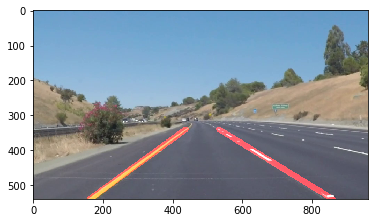

In [35]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Image Height : 720 Image Width: 1280

 Initial Left Values: 
 x1: 255 y1 : 685 
 x2: 631 y2: 432

 Initial Right Values pe: 
 x1: 664 y1 : 427 
 x2: 1094 y2: 675

 Initial Left Values: 
 x1: 279 y1 : 685 
 x2: 644 y2: 430

 Initial Right Values pe: 
 x1: 913 y1 : 580 
 x2: 1075 y2: 677

 Initial Left Values: 
 x1: 275 y1 : 686 
 x2: 641 y2: 430

 Initial Left Values: 
 x1: 356 y1 : 439 
 x2: 707 y2: 415

 Initial Left Values: 
 x1: 393 y1 : 491 
 x2: 597 y2: 437

 Initial Left Values: 
 x1: 274 y1 : 686 
 x2: 638 y2: 431

 Initial Left Values: 
 x1: 281 y1 : 520 
 x2: 544 y2: 450

 Initial Right Values pe: 
 x1: 976 y1 : 619 
 x2: 1072 y2: 677

 Initial Left Values: 
 x1: 514 y1 : 511 
 x2: 674 y2: 422

 Initial Left Values: 
 x1: 377 y1 : 435 
 x2: 621 y2: 418

 Initial Left Values: 
 x1: 376 y1 : 434 
 x2: 735 y2: 409

 Initial Right Values pe: 
 x1: 660 y1 : 427 
 x2: 1091 y2: 675

 Initial Left Values: 
 x1: 246 y1 : 686 
 x2: 583 y2: 468

 Initial Left Values: 
 x1: 636 y1 : 431 



  0%|          | 0/251 [00:00<?, ?it/s]

Image Height : 720 Image Width: 1280



  0%|          | 1/251 [00:00<00:25,  9.77it/s]


 Initial Left Values: 
 x1: 255 y1 : 685 
 x2: 631 y2: 432

 Initial Right Values pe: 
 x1: 664 y1 : 427 
 x2: 1094 y2: 675

 Initial Left Values: 
 x1: 279 y1 : 685 
 x2: 644 y2: 430

 Initial Right Values pe: 
 x1: 913 y1 : 580 
 x2: 1075 y2: 677

 Initial Left Values: 
 x1: 275 y1 : 686 
 x2: 641 y2: 430

 Initial Left Values: 
 x1: 356 y1 : 439 
 x2: 707 y2: 415

 Initial Left Values: 
 x1: 393 y1 : 491 
 x2: 597 y2: 437

 Initial Left Values: 
 x1: 274 y1 : 686 
 x2: 638 y2: 431

 Initial Left Values: 
 x1: 281 y1 : 520 
 x2: 544 y2: 450

 Initial Right Values pe: 
 x1: 976 y1 : 619 
 x2: 1072 y2: 677

 Initial Left Values: 
 x1: 514 y1 : 511 
 x2: 674 y2: 422

 Initial Left Values: 
 x1: 377 y1 : 435 
 x2: 621 y2: 418

 Initial Left Values: 
 x1: 376 y1 : 434 
 x2: 735 y2: 409

 Initial Right Values pe: 
 x1: 660 y1 : 427 
 x2: 1091 y2: 675

 Initial Left Values: 
 x1: 246 y1 : 686 
 x2: 583 y2: 468

 Initial Left Values: 
 x1: 636 y1 : 431 
 x2: 741 y2: 420

 Initial Left Value


 Initial Left Values: 
 x1: 252 y1 : 686 
 x2: 631 y2: 431

 Initial Left Values: 
 x1: 283 y1 : 519 
 x2: 581 y2: 440

 Initial Left Values: 
 x1: 278 y1 : 685 
 x2: 644 y2: 429

 Initial Left Values: 
 x1: 355 y1 : 439 
 x2: 721 y2: 414

 Initial Left Values: 
 x1: 255 y1 : 685 
 x2: 632 y2: 431

 Initial Right Values pe: 
 x1: 664 y1 : 426 
 x2: 1094 y2: 674

 Initial Right Values pe: 
 x1: 958 y1 : 607 
 x2: 1074 y2: 677

 Initial Left Values: 
 x1: 275 y1 : 685 
 x2: 640 y2: 430

 Initial Left Values: 
 x1: 359 y1 : 435 
 x2: 735 y2: 409

 Initial Left Values: 
 x1: 365 y1 : 498 
 x2: 595 y2: 437

 Initial Right Values pe: 
 x1: 956 y1 : 605 
 x2: 1076 y2: 677

 Initial Right Values pe: 
 x1: 663 y1 : 426 
 x2: 1094 y2: 675

 Initial Left Values: 
 x1: 505 y1 : 517 
 x2: 673 y2: 420

 Initial Left Values: 
 x1: 285 y1 : 518 
 x2: 349 y2: 501

 Initial Left Values: 
 x1: 603 y1 : 436 
 x2: 733 y2: 420

 Initial Left Values: 
 x1: 541 y1 : 494 
 x2: 651 y2: 428

 Initial Left Value


  1%|          | 3/251 [00:00<00:29,  8.43it/s]

Image Height : 720 Image Width: 1280

 Initial Left Values: 
 x1: 279 y1 : 685 
 x2: 645 y2: 429

 Initial Left Values: 
 x1: 256 y1 : 685 
 x2: 633 y2: 431

 Initial Left Values: 
 x1: 254 y1 : 685 
 x2: 630 y2: 432

 Initial Left Values: 
 x1: 355 y1 : 439 
 x2: 723 y2: 413

 Initial Left Values: 
 x1: 278 y1 : 685 
 x2: 643 y2: 429

 Initial Left Values: 
 x1: 949 y1 : 677 
 x2: 1086 y2: 677

 Initial Left Values: 
 x1: 340 y1 : 505 
 x2: 597 y2: 437

 Initial Left Values: 
 x1: 303 y1 : 514 
 x2: 578 y2: 441

 Initial Left Values: 
 x1: 280 y1 : 685 
 x2: 646 y2: 429

 Initial Left Values: 
 x1: 275 y1 : 685 
 x2: 639 y2: 430

 Initial Left Values: 
 x1: 361 y1 : 435 
 x2: 735 y2: 409

 Initial Left Values: 
 x1: 358 y1 : 436 
 x2: 616 y2: 418

 Initial Left Values: 
 x1: 549 y1 : 489 
 x2: 675 y2: 422

 Initial Right Values pe: 
 x1: 664 y1 : 421 
 x2: 1073 y2: 676

 Initial Right Values pe: 
 x1: 665 y1 : 419 
 x2: 1081 y2: 668

 Initial Left Values: 
 x1: 507 y1 : 518 
 x2: 637 

Image Height : 720 Image Width: 1280

 Initial Left Values: 
 x1: 283 y1 : 685 
 x2: 632 y2: 432

 Initial Left Values: 
 x1: 357 y1 : 439 
 x2: 721 y2: 414

 Initial Left Values: 
 x1: 257 y1 : 685 
 x2: 634 y2: 431

 Initial Left Values: 
 x1: 287 y1 : 519 
 x2: 592 y2: 438

 Initial Left Values: 
 x1: 437 y1 : 562 
 x2: 661 y2: 427

 Initial Left Values: 
 x1: 358 y1 : 436 
 x2: 612 y2: 419

 Initial Left Values: 
 x1: 281 y1 : 520 
 x2: 574 y2: 442

 Initial Left Values: 
 x1: 270 y1 : 685 
 x2: 663 y2: 420

 Initial Left Values: 
 x1: 621 y1 : 433 
 x2: 743 y2: 420

 Initial Left Values: 
 x1: 512 y1 : 514 
 x2: 662 y2: 420

 Initial Left Values: 
 x1: 471 y1 : 549 
 x2: 628 y2: 443

 Initial Left Values: 
 x1: 271 y1 : 685 
 x2: 665 y2: 420

 Initial Left Values: 
 x1: 360 y1 : 434 
 x2: 731 y2: 409

 Initial Right Values pe: 
 x1: 480 y1 : 304 
 x2: 884 y2: 556

 Initial Left Values: 
 x1: 498 y1 : 308 
 x2: 554 y2: 314

 Initial Right Values pe: 
 x1: 512 y1 : 309 
 x2: 797 y2:


  2%|▏         | 4/251 [00:00<00:29,  8.36it/s]

Image Height : 720 Image Width: 1280

 Initial Left Values: 
 x1: 280 y1 : 685 
 x2: 645 y2: 430

 Initial Left Values: 
 x1: 253 y1 : 685 
 x2: 659 y2: 421

 Initial Left Values: 
 x1: 283 y1 : 685 
 x2: 660 y2: 421

 Initial Left Values: 
 x1: 388 y1 : 596 
 x2: 643 y2: 430

 Initial Left Values: 
 x1: 279 y1 : 523 
 x2: 593 y2: 439

 Initial Left Values: 
 x1: 376 y1 : 496 
 x2: 577 y2: 442

 Initial Left Values: 
 x1: 354 y1 : 440 
 x2: 710 y2: 415

 Initial Left Values: 
 x1: 264 y1 : 685 
 x2: 407 y2: 680

 Initial Left Values: 
 x1: 267 y1 : 680 
 x2: 601 y2: 668

 Initial Left Values: 
 x1: 364 y1 : 432 
 x2: 702 y2: 415

 Initial Left Values: 
 x1: 264 y1 : 683 
 x2: 332 y2: 634

 Initial Left Values: 
 x1: 368 y1 : 623 
 x2: 605 y2: 457

 Initial Right Values pe: 
 x1: 731 y1 : 459 
 x2: 913 y2: 577

 Initial Right Values pe: 
 x1: 728 y1 : 461 
 x2: 811 y2: 517

 Initial Left Values: 
 x1: 650 y1 : 429 
 x2: 743 y2: 421

 Initial Left Values: 
 x1: 359 y1 : 436 
 x2: 736 y2:


  2%|▏         | 5/251 [00:00<00:31,  7.74it/s]

Image Height : 720 Image Width: 1280



  2%|▏         | 6/251 [00:00<00:33,  7.42it/s]


 Initial Left Values: 
 x1: 280 y1 : 686 
 x2: 646 y2: 430

 Initial Left Values: 
 x1: 282 y1 : 686 
 x2: 658 y2: 423

 Initial Left Values: 
 x1: 355 y1 : 440 
 x2: 709 y2: 415

 Initial Left Values: 
 x1: 258 y1 : 686 
 x2: 635 y2: 432

 Initial Left Values: 
 x1: 262 y1 : 686 
 x2: 640 y2: 431

 Initial Left Values: 
 x1: 300 y1 : 519 
 x2: 505 y2: 461

 Initial Left Values: 
 x1: 357 y1 : 437 
 x2: 610 y2: 420

 Initial Left Values: 
 x1: 554 y1 : 448 
 x2: 719 y2: 416

 Initial Right Values pe: 
 x1: 503 y1 : 310 
 x2: 952 y2: 602

 Initial Left Values: 
 x1: 388 y1 : 431 
 x2: 709 y2: 414

 Initial Left Values: 
 x1: 261 y1 : 685 
 x2: 548 y2: 492

 Initial Left Values: 
 x1: 280 y1 : 524 
 x2: 372 y2: 498

 Initial Left Values: 
 x1: 214 y1 : 686 
 x2: 279 y2: 686

 Initial Right Values pe: 
 x1: 732 y1 : 461 
 x2: 826 y2: 527

 Initial Left Values: 
 x1: 417 y1 : 487 
 x2: 556 y2: 448

 Initial Left Values: 
 x1: 653 y1 : 429 
 x2: 743 y2: 421

 Initial Left Values: 
 x1: 603


  3%|▎         | 8/251 [00:01<00:30,  8.01it/s]

Image Height : 720 Image Width: 1280

 Initial Left Values: 
 x1: 315 y1 : 667 
 x2: 654 y2: 421

 Initial Left Values: 
 x1: 263 y1 : 685 
 x2: 652 y2: 422

 Initial Left Values: 
 x1: 269 y1 : 682 
 x2: 656 y2: 421

 Initial Left Values: 
 x1: 331 y1 : 510 
 x2: 515 y2: 458

 Initial Left Values: 
 x1: 359 y1 : 439 
 x2: 707 y2: 415

 Initial Left Values: 
 x1: 290 y1 : 684 
 x2: 653 y2: 421

 Initial Left Values: 
 x1: 381 y1 : 620 
 x2: 655 y2: 421

 Initial Right Values pe: 
 x1: 489 y1 : 307 
 x2: 1080 y2: 676

 Initial Right Values pe: 
 x1: 493 y1 : 308 
 x2: 869 y2: 552

 Initial Left Values: 
 x1: 479 y1 : 426 
 x2: 757 y2: 421

 Initial Left Values: 
 x1: 540 y1 : 451 
 x2: 735 y2: 409

 Initial Left Values: 
 x1: 277 y1 : 525 
 x2: 473 y2: 469

 Initial Right Values pe: 
 x1: 485 y1 : 306 
 x2: 1079 y2: 677

 Initial Left Values: 
 x1: 354 y1 : 440 
 x2: 718 y2: 415

 Initial Left Values: 
 x1: 358 y1 : 436 
 x2: 728 y2: 410

 Initial Left Values: 
 x1: 539 y1 : 498 
 x2: 6


  4%|▍         | 10/251 [00:01<00:28,  8.46it/s]

Image Height : 720 Image Width: 1280

 Initial Left Values: 
 x1: 305 y1 : 679 
 x2: 648 y2: 421

 Initial Left Values: 
 x1: 271 y1 : 684 
 x2: 630 y2: 433

 Initial Left Values: 
 x1: 309 y1 : 659 
 x2: 649 y2: 421

 Initial Left Values: 
 x1: 514 y1 : 670 
 x2: 697 y2: 667

 Initial Left Values: 
 x1: 388 y1 : 493 
 x2: 652 y2: 422

 Initial Right Values pe: 
 x1: 843 y1 : 536 
 x2: 934 y2: 593

 Initial Left Values: 
 x1: 354 y1 : 440 
 x2: 706 y2: 416

 Initial Left Values: 
 x1: 230 y1 : 686 
 x2: 404 y2: 680

 Initial Left Values: 
 x1: 299 y1 : 683 
 x2: 631 y2: 433

 Initial Left Values: 
 x1: 698 y1 : 667 
 x2: 862 y2: 670

 Initial Left Values: 
 x1: 282 y1 : 685 
 x2: 655 y2: 424

 Initial Right Values pe: 
 x1: 744 y1 : 469 
 x2: 949 y2: 592

 Initial Left Values: 
 x1: 504 y1 : 426 
 x2: 759 y2: 422

 Initial Right Values pe: 
 x1: 745 y1 : 469 
 x2: 940 y2: 586

 Initial Right Values pe: 
 x1: 745 y1 : 473 
 x2: 937 y2: 593

 Initial Left Values: 
 x1: 294 y1 : 520 
 x2:


  4%|▍         | 11/251 [00:01<00:29,  8.17it/s]

Image Height : 720 Image Width: 1280

 Initial Left Values: 
 x1: 271 y1 : 685 
 x2: 633 y2: 432

 Initial Left Values: 
 x1: 293 y1 : 685 
 x2: 643 y2: 431

 Initial Right Values pe: 
 x1: 679 y1 : 429 
 x2: 1077 y2: 668

 Initial Left Values: 
 x1: 274 y1 : 685 
 x2: 635 y2: 432

 Initial Right Values pe: 
 x1: 477 y1 : 306 
 x2: 1056 y2: 668

 Initial Left Values: 
 x1: 387 y1 : 493 
 x2: 569 y2: 444

 Initial Right Values pe: 
 x1: 480 y1 : 307 
 x2: 1060 y2: 669

 Initial Left Values: 
 x1: 354 y1 : 440 
 x2: 740 y2: 413

 Initial Left Values: 
 x1: 297 y1 : 684 
 x2: 389 y2: 617

 Initial Left Values: 
 x1: 291 y1 : 685 
 x2: 641 y2: 431

 Initial Left Values: 
 x1: 356 y1 : 502 
 x2: 580 y2: 442

 Initial Left Values: 
 x1: 366 y1 : 436 
 x2: 729 y2: 410

 Initial Right Values pe: 
 x1: 724 y1 : 455 
 x2: 1079 y2: 668

 Initial Left Values: 
 x1: 634 y1 : 432 
 x2: 732 y2: 422

 Initial Left Values: 
 x1: 210 y1 : 685 
 x2: 295 y2: 685

 Initial Left Values: 
 x1: 365 y1 : 439 


OverflowError: cannot convert float infinity to integer

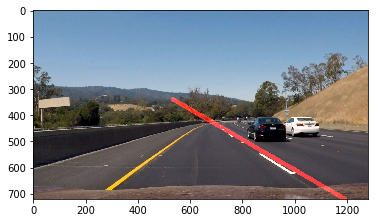

In [49]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))